# Section I: Generating PDFs for distance distribution 

This section illustrated how the PDFs over time in Figure 3. 
Each comparison are also subjected to a stimulated power analysis to guarantee a true significant value. The p value for each comparisons are generated using the Kolmogorov-Smirnov test p-value are also adjusted for multiple comparisons using FDR (Benjamini-Hochberg).  

## Import data and extract distance information. 

In [1]:
import os
import glob
import pandas as pd

def extract_distances_from_folders(base_path, stages):
    """
    Extracts distances (E1-PPE, E2-PPE, and E1-E2) from CSV files across multiple folders for different stages.

    Parameters:
        base_path (str): The base path where the stage folders are located.
        stages (list): A list of folder names (stages) to process (e.g., ['Nc12', 'Nc13']).

    Returns:
        dict: A dictionary containing DataFrames for each distance type ('3'-PPE', '5'-PPE', '3'-5') 
              for each stage.
    """
    result = {}

    for stage in stages:
        # Define the path to the folder containing the CSV files
        folder_path = os.path.join(base_path, stage)

        # Collect and concatenate only CSV files directly in the folder (no subdirectories)
        csv_files = sorted(glob.glob(os.path.join(folder_path, "*.csv")))
        li = []
        for f in csv_files:
            df = pd.read_csv(f)
            li.append(df)

        # Check if there are any CSV files
        if not li:
            print(f"No CSV files found in {folder_path} for stage: {stage}")
            continue

        # Concatenate all DataFrames in the list
        stage_distances = pd.concat(li, axis=0, ignore_index=True)

        # Extract rows where only 'leftDist' is present. Drop NA for subset in leftDist column only. Here, leftDist correspond to E2-PPE distance.
        # This is dependent on which fluorophore you chose to be in the Left box in the find_spots GUI. In this case, 488, which is E2 was chosen 
        # to be on the Left. Henceforth, leftDist is E2-PPE distance. 
        left_dist = stage_distances.dropna(subset=['leftDist'])[
            ['Xleft', 'Yleft', 'Zleft', 'Xmiddle', 'Ymiddle', 'Zmiddle',
             'Xright', 'Yright', 'Zright', 'leftDist']
        ].rename(columns={'leftDist': "E2-PPE distance (um)"})

        # Extract rows where only 'rightDist' is present. Drop NA for subset in rightDist column only. This correspond to E1-PPE distance. 
        right_dist = stage_distances.dropna(subset=['rightDist'])[
            ['Xleft', 'Yleft', 'Zleft', 'Xmiddle', 'Ymiddle', 'Zmiddle',
             'Xright', 'Yright', 'Zright', 'rightDist']
        ].rename(columns={'rightDist': "E1-PPE distance (um)"})

        # Extract rows where only 'leftRightDist' is present. Drop NA for subset in leftRightDist column only. This correspond to E1-E2 distance. 
        left_right_dist = stage_distances.dropna(subset=['leftRightDist'])[
            ['Xleft', 'Yleft', 'Zleft', 'Xmiddle', 'Ymiddle', 'Zmiddle',
             'Xright', 'Yright', 'Zright', 'leftRightDist']
        ].rename(columns={'leftRightDist': "E1-E2 distance (um)"})

        # Store the DataFrames in the result dictionary
        result[f'{stage}_E2-PPE'] = left_dist
        result[f'{stage}_E1-PPE'] = right_dist
        result[f'{stage}_E1-E2'] = left_right_dist

    return result

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Loading wild-type data
base_path = '../../../../10_03_SR_T3_2_doublets_2_thres/YW_distances/'
stages = ['Nc12/Male', 'Nc13/Male', 'Nc14_early/Male','Nc14_late/Male']

distance_data = extract_distances_from_folders(base_path, stages)

# Accessing the results for Nc12
YW_E2_PPE_nc12 = distance_data['Nc12/Male_E2-PPE']
YW_E1_PPE_nc12 = distance_data['Nc12/Male_E1-PPE']
YW_E1_E2_nc12 = distance_data['Nc12/Male_E1-E2']

# Accessing the results for Nc13
YW_E2_PPE_nc13 = distance_data['Nc13/Male_E2-PPE']
YW_E1_PPE_nc13 = distance_data['Nc13/Male_E1-PPE']
YW_E1_E2_nc13 = distance_data['Nc13/Male_E1-E2']

# Accessing the results for Nc14_early
YW_E2_PPE_nc14_early = distance_data['Nc14_early/Male_E2-PPE']
YW_E1_PPE_nc14_early = distance_data['Nc14_early/Male_E1-PPE']
YW_E1_E2_nc14_early = distance_data['Nc14_early/Male_E1-E2']

# Accessing the results for Nc14_late
YW_E2_PPE_nc14_late = distance_data['Nc14_late/Male_E2-PPE']
YW_E1_PPE_nc14_late = distance_data['Nc14_late/Male_E1-PPE']
YW_E1_E2_nc14_late = distance_data['Nc14_late/Male_E1-E2']

## Plotting PDFs for distance distributions:

In [3]:
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import bokeh.io
bokeh.io.output_notebook()
from bokeh.models import Legend
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import seaborn as sns
import matplotlib.patches as patches
from bokeh.plotting import figure, show
from bokeh.layouts import row
import iqplot
from bokeh.models import ColumnDataSource, HoverTool, Range1d, Legend, LegendItem
from bokeh.io import output_notebook  # Import for inline display


def generate_plots(dataframes, distance_column, phenotype_label, x_axis_label=None):
    """ This generate two different plots side-by-side: strip box plot (left) and PDF (right). Here, we are plotting visualization for all four stages 
    for a specific pairwise distance. 
    For the strip-box plot, we use swarm layout for points clarity.
    PDF is generated using KDE of distances per stage. PDF is generated through scipy.stats Gaussian Kernel Density Estimation (gaussian_kde) which is a 
    non-parametric way of visualizing all distances per stage without assuming any underlying distribution. This allows us to have a "smooth histogram" 
    to identify peaks, median and overall shape of the distance distribution. In the PDF, median line is also plotted. The x value for the peak of 
    each PDF is also outputted.
    """
    # Convert the DataFrame columns to Numpy arrays
    arrays = [df[distance_column].to_numpy() for df in dataframes]
    
    # Stages over time and color palette
    stages_labels = ['Pre-nc13', 'nc13', 'nc14-early', 'nc14-late']
    palette = ['red','#FF00FF','#3F7FFF','#00008B',]  # Light blue, neon blue, dark blue
    
    #Create dataframe for combining distances dynamically using passed 
    #distance column. 
    df_combined = pd.DataFrame({
        "phenotype": [phenotype_label] * sum(len(arr) for arr in arrays),
        distance_column: np.concatenate(arrays),  # Use the dynamic distance_column name
        "stages": np.concatenate([[stages_labels[i]] * len(arr) for i, arr in enumerate(arrays)])
    })

    label_to_use = x_axis_label if x_axis_label else distance_column
    
    # Create strip-box plot using iqplot with jitter spread
    strip_box_plot = iqplot.stripbox(
        df_combined,
        q=distance_column,  # Use the dynamic distance column
        cats="stages",
        title=f"{phenotype_label} \nDistance between {label_to_use} over time",  # Dynamic title
        x_axis_label=label_to_use,  # Dynamic x-axis label
        y_axis_label="Developmental Stages",
        frame_height=500,
        spread='swarm',  # Avoid exceeding max height
        palette=palette
    )
    
    # Dictionary to store the x-value of the peak for each stage
    pdf_peaks = {}
    
    # Create the PDF plot using Bokeh
    pdf_plot = figure(
        title=f"{phenotype_label} \nDistance between {label_to_use} over time",
        x_axis_label=label_to_use, # Dynamic x axis label. 
        y_axis_label="Probability Density",
        height=600, 
        width=1000
    )
    
    # Correct the x-axis label format
    micrometer_symbol = "μm"
    formatted_distance_label = distance_column.replace("(um)", f"({micrometer_symbol})")
    pdf_plot.xaxis.axis_label = label_to_use
    
    # Customize title and axes for boldness and larger font sizes
    pdf_plot.title.text_font_size = "13pt"  # Larger font for the title
    pdf_plot.title.align = "center"  # Center align the title
    pdf_plot.axis.axis_label_text_font_size = "25pt"  # Larger font size for axis labels
    pdf_plot.axis.axis_label_text_font_style = "bold"  # Bold axis labels
    pdf_plot.axis.major_label_text_font_size = "18pt"  # Larger font size for tick labels
    pdf_plot.axis.major_label_text_font_style = "bold"  # Bold tick labels
    pdf_plot.axis.axis_line_width = 2  # Thicker axis lines
    pdf_plot.axis.axis_line_color = "black"  # Darker axis lines for emphasis
    pdf_plot.axis.major_tick_line_width = 3  # Thicker major ticks
    pdf_plot.axis.major_tick_line_color = "black"  # Darker major ticks
    pdf_plot.axis.minor_tick_line_width = 2  # Optionally thicker minor ticks
    pdf_plot.axis.minor_tick_line_color = "black"  # Optionally make minor ticks visible
    pdf_plot.title.standoff = 20  # Move the title higher from the graph (adjust as needed)
    # Set the y-axis range to be from 0 to 2
    pdf_plot.y_range = Range1d(start=0, end=2.2)
    
    # Initialize legend items: 
    legend_items = []
    kde_results = {}
    
    # Iterate through each stage to plot the PDF and confidence intervals
    n_bootstraps = 1000  # Number of bootstrap samples for confidence intervals
    for i, stage in enumerate(stages_labels):
        # Get data for the current stage
        stage_data = arrays[i]

        # Calculate sample size and median
        n_samples = len(stage_data)
        median_value = np.median(stage_data)

        # Estimate KDE (PDF) for the current stage
        kde = gaussian_kde(stage_data)
        x_range = np.linspace(stage_data.min(), stage_data.max(), 2000)
        y_kde = kde(x_range)
        # Normalize the densities
        y_kde /= np.trapz(y_kde, x_range)  # Normalize PDF
        
        # Store in results
        kde_results[stage] = {"x": x_range, "y": y_kde}
        
        # Find the x-value of the peak
        peak_x_value = x_range[np.argmax(y_kde)]
        pdf_peaks[f"PDF_{stage.replace(' ', '_')}"] = peak_x_value  # Save peak x-value with stage-specific name

        # Bootstrapping for confidence intervals
        bootstrapped_y = np.zeros((n_bootstraps, len(x_range)))
        for b in range(n_bootstraps):
            bootstrap_sample = np.random.choice(stage_data, size=len(stage_data), replace=True)
            bootstrapped_kde = gaussian_kde(bootstrap_sample)
            bootstrapped_y[b] = bootstrapped_kde(x_range)

        # Calculate confidence intervals
        ci_lower = np.percentile(bootstrapped_y, 2.5, axis=0)
        ci_upper = np.percentile(bootstrapped_y, 97.5, axis=0)

        # Create ColumnDataSource for interactive plotting
        source_pdf = ColumnDataSource(data={'x': x_range, 'y': y_kde, 'ci_upper': ci_upper, 'ci_lower': ci_lower})

        # Plot the PDF curve with n and median in the legend label
        line = pdf_plot.line(
            'x', 'y', source=source_pdf, line_width=4, color=palette[i], 
            legend_label=f"{stage} (n={n_samples}, median={median_value:.2f})"
        )

        # Plot the confidence intervals as shaded area with the same legend label
        ci = pdf_plot.varea(
            x='x', y1='ci_lower', y2='ci_upper', source=source_pdf, fill_alpha=0.2, fill_color=palette[i], 
                       legend_label=f"{stage} (n={n_samples}, median={median_value:.2f})"
            
        )
        
        # Define the vertical range for the median line (shorter range)
        y_min = 0.05 * max(y_kde)  # 5% of max density (adjust as needed)
        y_max = 0.90 * max(y_kde)  # 90% of max density
        
         # ** Plot median as an unfilled elongated oval on the KDE curve **
        #center_y = kde(median_value)[0] + 0.07  # Shift up by 0.05 (adjust as needed)

        #median_ellipse = pdf_plot.ellipse(
            #x=[median_value],
            #y=[center_y],
            #width=0.1,
            #height=0.2,
            #line_color=palette[i],
            #line_width=5,
            #fill_alpha=0,
            #line_dash="dotted"  # Dotted effect
        #)
        
        # Add stage to legend items, including line and CI:
        legend_items.append(
            LegendItem(
                label=f"{stage} (n={n_samples}, median={median_value:.2f})",
                renderers=[line, ci]  # Include the ellipse here
            )
        )

        # Add hover tool for the PDF and confidence intervals
        hover = HoverTool(
            renderers=[pdf_plot.renderers[-1]],  # Attach hover to the curve and confidence intervals
            tooltips=[
                ("X-axis", "@x"),
                ("Density", "@y"),
                ("Confidence Interval", "(@ci_lower, @ci_upper)")
            ]
        )
        pdf_plot.add_tools(hover)

    # Explicitly remove the default legend
    pdf_plot.legend.visible = False
    pdf_plot.legend.items = []  # Completely remove the default legend

    # Move legend outside of the plot
    legend = Legend(items=legend_items, location="center")
    legend.label_text_font_size = "10pt"
    pdf_plot.add_layout(legend,'right')
    pdf_plot.legend.click_policy = "hide"  # Allow toggling the visibility of the curve and confidence intervals
    pdf_plot.xgrid.visible = False
    pdf_plot.ygrid.visible = False
    #pdf_plot.background_fill_color = None
    pdf_plot.border_fill_color = None
    
    # Display plots side by side
    show(row(strip_box_plot, pdf_plot))
    
    # Return the dictionary with peak x-values
    return pdf_peaks, kde_results

Loading BokehJS ...

## YW_PDF

In [4]:
### Comparison PDFs for E1-PPE distances over time.
pdf_peaks_e1_ppe, kde_results_e1_ppe = generate_plots(
    dataframes=[YW_E1_PPE_nc12, YW_E1_PPE_nc13, YW_E1_PPE_nc14_early, YW_E1_PPE_nc14_late],
    distance_column="E1-PPE distance (um)", # Column corresponds to E1-PPE
    phenotype_label="wild-type control",
    x_axis_label="E1-PPE (μm)"  # Custom label shown in plot
)

/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 132 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 156 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 226 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(


In [5]:
pdf_peaks_e1_ppe

{'PDF_Pre-nc13': 0.27590158562748274,
 'PDF_nc13': 0.24701766607939885,
 'PDF_nc14-early': 0.2368154711394174,
 'PDF_nc14-late': 0.2482030389932356}

In [6]:
### Comparison PDFs for E2-PPE distances over time.
pdf_peaks_e2_ppe, kde_results_e2_ppe = generate_plots(
    dataframes=[YW_E2_PPE_nc12, YW_E2_PPE_nc13, YW_E2_PPE_nc14_early, YW_E2_PPE_nc14_late],
    distance_column="E2-PPE distance (um)", # Column corresponds to E1-PPE
    phenotype_label="wild-type control",
    x_axis_label="E2-PPE (μm)"  # Custom label shown in plot
)

/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 2 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 5 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 22 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(


In [7]:
pdf_peaks_e2_ppe

{'PDF_Pre-nc13': 0.2972569499070783,
 'PDF_nc13': 0.30373568110842203,
 'PDF_nc14-early': 0.3207968439972851,
 'PDF_nc14-late': 0.33701146315214625}

In [8]:
### Comparison PDFs for E1-E2 distances over time.
pdf_peaks_e1_e2, kde_results_e1_e2 = generate_plots(
    dataframes=[YW_E1_E2_nc12, YW_E1_E2_nc13, YW_E1_E2_nc14_early, YW_E1_E2_nc14_late],
    distance_column="E1-E2 distance (um)", # Column corresponds to E1-E2
    phenotype_label="wild-type control",
    x_axis_label="E1-E2 (μm)"  # Custom label shown in plot
)

/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 2 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 19 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(


In [9]:
pdf_peaks_e1_e2

{'PDF_Pre-nc13': 0.321404421848136,
 'PDF_nc13': 0.30632868855047696,
 'PDF_nc14-early': 0.2995200371953187,
 'PDF_nc14-late': 0.31155205507897327}

## PPE_PDF

In [10]:
base_path = '../../../../10_03_SR_T3_2_doublets_2_thres/PPE_distances/'
stages = ['Nc12/Male', 'Nc13/Male', 'Nc14_early/Male','Nc14_late/Male']

distance_data = extract_distances_from_folders(base_path, stages)

# Accessing the results for Nc12
PPE_E2_PPE_nc12 = distance_data['Nc12/Male_E2-PPE']
PPE_E1_PPE_nc12 = distance_data['Nc12/Male_E1-PPE']
PPE_E1_E2_nc12 = distance_data['Nc12/Male_E1-E2']

# Accessing the results for Nc13
PPE_E2_PPE_nc13 = distance_data['Nc13/Male_E2-PPE']
PPE_E1_PPE_nc13 = distance_data['Nc13/Male_E1-PPE']
PPE_E1_E2_nc13 = distance_data['Nc13/Male_E1-E2']

# Accessing the results for Nc14_early
PPE_E2_PPE_nc14_early = distance_data['Nc14_early/Male_E2-PPE']
PPE_E1_PPE_nc14_early = distance_data['Nc14_early/Male_E1-PPE']
PPE_E1_E2_nc14_early = distance_data['Nc14_early/Male_E1-E2']

# Accessing the results for Nc14_late
PPE_E2_PPE_nc14_late = distance_data['Nc14_late/Male_E2-PPE']
PPE_E1_PPE_nc14_late = distance_data['Nc14_late/Male_E1-PPE']
PPE_E1_E2_nc14_late = distance_data['Nc14_late/Male_E1-E2']

In [11]:
ppe_pdf_peaks_e1_ppe, ppe_kde_results_e1_ppe = generate_plots(
    [PPE_E1_PPE_nc12, PPE_E1_PPE_nc13, PPE_E1_PPE_nc14_early, PPE_E1_PPE_nc14_late],
    distance_column="E1-PPE distance (um)", # Column corresponds to E1-PPE
    phenotype_label="Δ800bp PPE mutant",
    x_axis_label="E1-PPE (μm)"  # Custom label shown in plot
)

/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 1 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 79 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 39 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 87 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(


In [12]:
ppe_pdf_peaks_e1_ppe

{'PDF_Pre-nc13': 0.22845565264580814,
 'PDF_nc13': 0.2579796665054197,
 'PDF_nc14-early': 0.2196868551350672,
 'PDF_nc14-late': 0.2058958954592284}

In [13]:
ppe_pdf_peaks_e2_ppe, ppe_kde_results_e2_ppe = generate_plots(
    [PPE_E2_PPE_nc12, PPE_E2_PPE_nc13, PPE_E2_PPE_nc14_early, PPE_E2_PPE_nc14_late],
    distance_column="E2-PPE distance (um)", # Column corresponds to E2-PPE
    phenotype_label="Δ800bp PPE mutant",
    x_axis_label="E2-PPE (μm)"  # Custom label shown in plot
)

In [14]:
ppe_pdf_peaks_e2_ppe

{'PDF_Pre-nc13': 0.35798618792025844,
 'PDF_nc13': 0.3825478579144742,
 'PDF_nc14-early': 0.3300041977492858,
 'PDF_nc14-late': 0.3229337562064912}

In [15]:
ppe_pdf_peaks_e1_e2, ppe_kde_results_e1_e2 = generate_plots(
    [PPE_E1_E2_nc12, PPE_E1_E2_nc13, PPE_E1_E2_nc14_early, PPE_E1_E2_nc14_late],
    distance_column="E1-E2 distance (um)", # Column corresponds to E1-E2
    phenotype_label="Δ800bp PPE mutant",
    x_axis_label="E1-E2 (μm)"  # Custom label shown in plot
)

/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 3 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(


In [16]:
ppe_pdf_peaks_e1_e2

{'PDF_Pre-nc13': 0.35175678852702325,
 'PDF_nc13': 0.3017060890472918,
 'PDF_nc14-early': 0.2838747403933241,
 'PDF_nc14-late': 0.26870625462243164}

## MIMIC PDF

In [17]:
nc12_YW_csv_folder = '../../../../02-11-25_MiMiC/Distances/Nc12/'
nc13_YW_csv_folder = '../../../../02-11-25_MiMiC/Distances//Nc13/'
nc14_early_YW_csv_folder = '../../../../02-11-25_MiMiC/Distances/Nc14_early/'
nc14_late_YW_csv_folder = '../../../../02-11-25_MiMiC/Distances/Nc14_late/'

In [18]:
# Example usage
base_path = '../../../../02-11-25_MiMiC/Distances/'
stages = ['Nc12', 'Nc13', 'Nc14_early','Nc14_late']

distance_data = extract_distances_from_folders(base_path, stages)

# Accessing the results for Nc12
mimic_insert_E2_PPE_nc12 = distance_data['Nc12_E2-PPE']
mimic_insert_E1_PPE_nc12 = distance_data['Nc12_E1-PPE']
mimic_insert_E1_E2_nc12 = distance_data['Nc12_E1-E2']

# Accessing the results for Nc13
mimic_insert_E2_PPE_nc13 = distance_data['Nc13_E2-PPE']
mimic_insert_E1_PPE_nc13 = distance_data['Nc13_E1-PPE']
mimic_insert_E1_E2_nc13 = distance_data['Nc13_E1-E2']

# Accessing the results for Nc14_early
mimic_insert_E2_PPE_nc14_early = distance_data['Nc14_early_E2-PPE']
mimic_insert_E1_PPE_nc14_early = distance_data['Nc14_early_E1-PPE']
mimic_insert_E1_E2_nc14_early = distance_data['Nc14_early_E1-E2']

# Accessing the results for Nc14_late
mimic_insert_E2_PPE_nc14_late = distance_data['Nc14_late_E2-PPE']
mimic_insert_E1_PPE_nc14_late = distance_data['Nc14_late_E1-PPE']
mimic_insert_E1_E2_nc14_late = distance_data['Nc14_late_E1-E2']

In [19]:
### Comparison PDFs for E1-PPE distances over time.
mimic_pdf_peaks_e1_ppe, mimic_kde_results_e1_ppe = generate_plots(
    dataframes=[mimic_insert_E1_PPE_nc12, mimic_insert_E1_PPE_nc13, mimic_insert_E1_PPE_nc14_early, mimic_insert_E1_PPE_nc14_late],
    distance_column="E1-PPE distance (um)", # Column corresponds to E1-PPE
    phenotype_label="mimic",
    x_axis_label="E1-PPE (μm)"  # Custom label shown in plot
)

/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 16 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 54 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 47 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 484 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(


In [20]:
mimic_pdf_peaks_e1_ppe

{'PDF_Pre-nc13': 0.21888815703669473,
 'PDF_nc13': 0.22217203629655793,
 'PDF_nc14-early': 0.21103286727908588,
 'PDF_nc14-late': 0.23751113601943719}

In [21]:
### Comparison PDFs for E1-PPE distances over time.
mimic_pdf_peaks_e2_ppe, mimic_kde_results_e2_ppe = generate_plots(
    dataframes=[mimic_insert_E2_PPE_nc12, mimic_insert_E2_PPE_nc13, mimic_insert_E2_PPE_nc14_early, mimic_insert_E2_PPE_nc14_late],
    distance_column="E2-PPE distance (um)", # Column corresponds to E1-PPE
    phenotype_label="mimic",
    x_axis_label="E2-PPE (μm)"  # Custom label shown in plot
)

In [22]:
mimic_pdf_peaks_e2_ppe

{'PDF_Pre-nc13': 0.2652560703271767,
 'PDF_nc13': 0.22910649033939445,
 'PDF_nc14-early': 0.2289457954928359,
 'PDF_nc14-late': 0.28637814857005195}

In [23]:
### Comparison PDFs for E1-PPE distances over time.
mimic_pdf_peaks_e1_e2, mimic_kde_results_e1_e2 = generate_plots(
    dataframes=[mimic_insert_E1_E2_nc12, mimic_insert_E1_E2_nc13, mimic_insert_E1_E2_nc14_early, mimic_insert_E1_E2_nc14_late],
    distance_column="E1-E2 distance (um)", # Column corresponds to E1-PPE
    phenotype_label="mimic",
    x_axis_label="E1-E2 (μm)"  # Custom label shown in plot
)

In [24]:
mimic_pdf_peaks_e1_e2

{'PDF_Pre-nc13': 0.3031969915228129,
 'PDF_nc13': 0.282108477293377,
 'PDF_nc14-early': 0.2973909898974993,
 'PDF_nc14-late': 0.34447070294771176}

# Section II: Retrieving p-value for multiple over time comparisons.

Using Kolmogorov Smirnov test to get p-value for the comparison over time. Benjamini Hochberg (FDR) is utilized to adjust for multiple comparisons.

In [25]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from statsmodels.stats.multitest import multipletests

def perform_ks_tests(dataframes, labels, distance_column, alpha=0.05):
    """
    Perform K-S tests between different stages based on a specified distance column,
    apply Benjamini-Hochberg (FDR) correction, and return results in a DataFrame with rankings.
    
    Parameters:
    - dataframes: List of DataFrames containing distance data for each stage.
    - labels: List of labels corresponding to each DataFrame.
    - distance_column: The name of the column to perform the K-S tests on.
    - alpha: False Discovery Rate (FDR) threshold for significance.
    
    Returns:
    - results_df: DataFrame containing K-S test results with FDR rankings.
    """
    results = []
    p_values = []
    comparisons = []

    # Loop over each pair of DataFrames
    for i in range(len(dataframes)):
        for j in range(i + 1, len(dataframes)):
            # Select the distance data from the specified column
            data1 = dataframes[i][distance_column].dropna()  # Remove NaN values
            data2 = dataframes[j][distance_column].dropna()  # Remove NaN values
            
            # Perform K-S test
            D_statistic, p_value = ks_2samp(data1, data2)
            comparison = f"{labels[i]} vs {labels[j]}"
            comparisons.append(comparison)
            p_values.append(p_value)
            results.append([comparison, D_statistic, p_value])
    
    # Convert p-values to numpy array for sorting
    p_values = np.array(p_values)
    
    # Apply Benjamini-Hochberg (FDR) correction
    corrected_p_values = multipletests(p_values, method='fdr_bh')[1]

    # Sort p-values and apply original Benjamini-Hochberg ranking method
    sorted_indices = np.argsort(p_values)  # Sort indices by ascending p-values
    num_tests = len(p_values)
    
    fdr_significance = np.full(num_tests, "No")  # Default: not significant
    fdr_thresholds = np.zeros(num_tests)  # Store FDR thresholds for reference
    ranks = np.zeros(num_tests)  # Store ranks for each p-value
    
    for rank, idx in enumerate(sorted_indices, start=1):
        fdr_threshold = (rank / num_tests) * alpha
        fdr_thresholds[idx] = fdr_threshold  # Store threshold for reference
        ranks[idx] = rank  # Store the rank
        
        if p_values[idx] <= fdr_threshold:
            fdr_significance[idx] = "Yes"

    # Add corrected p-values, FDR thresholds, ranks, and significance assessments
    for idx, (comparison, D_statistic, p_value) in enumerate(results):
        corrected_significance = "Yes" if corrected_p_values[idx] < alpha else "No"
        results[idx] = [
            comparison, 
            D_statistic, 
            p_value, 
            corrected_p_values[idx], 
            corrected_significance, 
            fdr_thresholds[idx], 
            ranks[idx], 
            fdr_significance[idx]
        ]
    
    # Create a DataFrame to display the results
    results_df = pd.DataFrame(results, columns=[
        "Comparison", "D Statistic", "P-value", "Corrected P-value", 
        "Corrected Sig.", "FDR Threshold", "Rank", "FDR Sig."
    ])
    
    return results_df

In [26]:
# p-value comparison over time for E1-PPE pairwise distances
distance_dataframes_E1_PPE = [YW_E1_PPE_nc12, YW_E1_PPE_nc13, YW_E1_PPE_nc14_early, YW_E1_PPE_nc14_late]
labels_E1_PPE = [
    "Before nc13",
    "nc13",
    "nc14 early",
    "nc14 late",
]

In [27]:
YW_ks_results_E1_PPE = perform_ks_tests(distance_dataframes_E1_PPE, labels_E1_PPE, "E1-PPE distance (um)")
YW_ks_results_E1_PPE

Comparison  D Statistic   P-value  Corrected P-value  \
0        Before nc13 vs nc13     0.168561  0.000092           0.000276   
1  Before nc13 vs nc14 early     0.168340  0.000079           0.000276   
2   Before nc13 vs nc14 late     0.143027  0.000815           0.001629   
3         nc13 vs nc14 early     0.044126  0.596413           0.596413   
4          nc13 vs nc14 late     0.055000  0.263206           0.315848   
5    nc14 early vs nc14 late     0.055889  0.229928           0.315848   

  Corrected Sig.  FDR Threshold  Rank FDR Sig.  
0            Yes       0.016667   2.0       Ye  
1            Yes       0.008333   1.0       Ye  
2            Yes       0.025000   3.0       Ye  
3             No       0.050000   6.0       No  
4             No       0.041667   5.0       No  
5             No       0.033333   4.0       No

In [28]:
# p-value comparison over time for E2-PPE pairwise distances
distance_dataframes_E2_PPE = [YW_E2_PPE_nc12, YW_E2_PPE_nc13, YW_E2_PPE_nc14_early, YW_E2_PPE_nc14_late]
labels_E2_PPE = [
    "Before nc13",
    "nc13",
    "nc14 early",
    "nc14 late",
]

In [29]:
YW_ks_results_E2_PPE = perform_ks_tests(distance_dataframes_E2_PPE, labels_E2_PPE, "E2-PPE distance (um)")
YW_ks_results_E2_PPE

Comparison  D Statistic       P-value  Corrected P-value  \
0        Before nc13 vs nc13     0.232340  3.924715e-05       8.315617e-05   
1  Before nc13 vs nc14 early     0.280712  1.600646e-07       9.603877e-07   
2   Before nc13 vs nc14 late     0.218744  4.157808e-05       8.315617e-05   
3         nc13 vs nc14 early     0.101597  8.699602e-02       1.304940e-01   
4          nc13 vs nc14 late     0.073492  3.061523e-01       3.201691e-01   
5    nc14 early vs nc14 late     0.070681  3.201691e-01       3.201691e-01   

  Corrected Sig.  FDR Threshold  Rank FDR Sig.  
0            Yes       0.016667   2.0       Ye  
1            Yes       0.008333   1.0       Ye  
2            Yes       0.025000   3.0       Ye  
3             No       0.033333   4.0       No  
4             No       0.041667   5.0       No  
5             No       0.050000   6.0       No

In [30]:
# p-value comparison over time for E1-E2 pairwise distances
distance_dataframes_E1_E2 = [YW_E1_E2_nc12, YW_E1_E2_nc13, YW_E1_E2_nc14_early, YW_E1_E2_nc14_late]
labels_E1_E2 = [
    "Before nc13",
    "nc13",
    "nc14 early",
    "nc14 late",
]

In [31]:
YW_ks_results_E1_E2 = perform_ks_tests(distance_dataframes_E1_E2, labels_E1_E2, "E1-E2 distance (um)")
YW_ks_results_E1_E2

Comparison  D Statistic   P-value  Corrected P-value  \
0        Before nc13 vs nc13     0.125964  0.092870           0.139305   
1  Before nc13 vs nc14 early     0.206055  0.000564           0.003385   
2   Before nc13 vs nc14 late     0.081393  0.456040           0.501756   
3         nc13 vs nc14 early     0.113994  0.048780           0.097561   
4          nc13 vs nc14 late     0.062688  0.501756           0.501756   
5    nc14 early vs nc14 late     0.135896  0.003521           0.010564   

  Corrected Sig.  FDR Threshold  Rank FDR Sig.  
0             No       0.033333   4.0       No  
1            Yes       0.008333   1.0       Ye  
2             No       0.041667   5.0       No  
3             No       0.025000   3.0       No  
4             No       0.050000   6.0       No  
5            Yes       0.016667   2.0       Ye

In [32]:
PPE_ks_results_E1_PPE = perform_ks_tests(distance_dataframes_E1_PPE, labels_E1_PPE, "E1-PPE distance (um)")
PPE_ks_results_E1_PPE

Comparison  D Statistic   P-value  Corrected P-value  \
0        Before nc13 vs nc13     0.168561  0.000092           0.000276   
1  Before nc13 vs nc14 early     0.168340  0.000079           0.000276   
2   Before nc13 vs nc14 late     0.143027  0.000815           0.001629   
3         nc13 vs nc14 early     0.044126  0.596413           0.596413   
4          nc13 vs nc14 late     0.055000  0.263206           0.315848   
5    nc14 early vs nc14 late     0.055889  0.229928           0.315848   

  Corrected Sig.  FDR Threshold  Rank FDR Sig.  
0            Yes       0.016667   2.0       Ye  
1            Yes       0.008333   1.0       Ye  
2            Yes       0.025000   3.0       Ye  
3             No       0.050000   6.0       No  
4             No       0.041667   5.0       No  
5             No       0.033333   4.0       No

In [33]:
PPE_ks_results_E2_PPE = perform_ks_tests(distance_dataframes_E1_PPE, labels_E1_PPE, "E1-PPE distance (um)")
PPE_ks_results_E2_PPE

Comparison  D Statistic   P-value  Corrected P-value  \
0        Before nc13 vs nc13     0.168561  0.000092           0.000276   
1  Before nc13 vs nc14 early     0.168340  0.000079           0.000276   
2   Before nc13 vs nc14 late     0.143027  0.000815           0.001629   
3         nc13 vs nc14 early     0.044126  0.596413           0.596413   
4          nc13 vs nc14 late     0.055000  0.263206           0.315848   
5    nc14 early vs nc14 late     0.055889  0.229928           0.315848   

  Corrected Sig.  FDR Threshold  Rank FDR Sig.  
0            Yes       0.016667   2.0       Ye  
1            Yes       0.008333   1.0       Ye  
2            Yes       0.025000   3.0       Ye  
3             No       0.050000   6.0       No  
4             No       0.041667   5.0       No  
5             No       0.033333   4.0       No

In [34]:
PPE_ks_results_E3_PPE = perform_ks_tests(distance_dataframes_E1_PPE, labels_E1_PPE, "E1-PPE distance (um)")
PPE_ks_results_E3_PPE

Comparison  D Statistic   P-value  Corrected P-value  \
0        Before nc13 vs nc13     0.168561  0.000092           0.000276   
1  Before nc13 vs nc14 early     0.168340  0.000079           0.000276   
2   Before nc13 vs nc14 late     0.143027  0.000815           0.001629   
3         nc13 vs nc14 early     0.044126  0.596413           0.596413   
4          nc13 vs nc14 late     0.055000  0.263206           0.315848   
5    nc14 early vs nc14 late     0.055889  0.229928           0.315848   

  Corrected Sig.  FDR Threshold  Rank FDR Sig.  
0            Yes       0.016667   2.0       Ye  
1            Yes       0.008333   1.0       Ye  
2            Yes       0.025000   3.0       Ye  
3             No       0.050000   6.0       No  
4             No       0.041667   5.0       No  
5             No       0.033333   4.0       No

In [35]:
distance_dataframes_E1_PPE = [mimic_insert_E1_PPE_nc12, mimic_insert_E1_PPE_nc13, mimic_insert_E1_PPE_nc14_early, mimic_insert_E1_PPE_nc14_late]
labels_E1_PPE = [
    "nc12",
    "nc13",
    "nc14 early",
    "nc14 late",
]

In [36]:
YW_ks_results_E1_PPE = perform_ks_tests(distance_dataframes_E1_PPE, labels_E1_PPE, "E1-PPE distance (um)")
YW_ks_results_E1_PPE

Comparison  D Statistic   P-value  Corrected P-value  \
0             nc12 vs nc13     0.057321  0.449121           0.449121   
1       nc12 vs nc14 early     0.140105  0.000642           0.001283   
2        nc12 vs nc14 late     0.143509  0.000010           0.000057   
3       nc13 vs nc14 early     0.118116  0.003664           0.005496   
4        nc13 vs nc14 late     0.115285  0.000212           0.000637   
5  nc14 early vs nc14 late     0.077331  0.051343           0.061612   

  Corrected Sig.  FDR Threshold  Rank FDR Sig.  
0             No       0.050000   6.0       No  
1            Yes       0.025000   3.0       Ye  
2            Yes       0.008333   1.0       Ye  
3            Yes       0.033333   4.0       Ye  
4            Yes       0.016667   2.0       Ye  
5             No       0.041667   5.0       No

In [37]:
distance_dataframes_E2_PPE = [mimic_insert_E2_PPE_nc12, mimic_insert_E2_PPE_nc13, mimic_insert_E2_PPE_nc14_early, mimic_insert_E2_PPE_nc14_late]
labels_E2_PPE = [
    "nc12",
    "nc13",
    "nc14 early",
    "nc14 late",
]

In [38]:
YW_ks_results_E2_PPE = perform_ks_tests(distance_dataframes_E2_PPE, labels_E2_PPE, "E2-PPE distance (um)")
YW_ks_results_E2_PPE

Comparison  D Statistic   P-value  Corrected P-value  \
0             nc12 vs nc13     0.197032  0.008789           0.026366   
1       nc12 vs nc14 early     0.246441  0.003365           0.020188   
2        nc12 vs nc14 late     0.185071  0.018352           0.036704   
3       nc13 vs nc14 early     0.106043  0.366492           0.366492   
4        nc13 vs nc14 late     0.118597  0.086981           0.104377   
5  nc14 early vs nc14 late     0.169689  0.030821           0.046232   

  Corrected Sig.  FDR Threshold  Rank FDR Sig.  
0            Yes       0.016667   2.0       Ye  
1            Yes       0.008333   1.0       Ye  
2            Yes       0.025000   3.0       Ye  
3             No       0.050000   6.0       No  
4             No       0.041667   5.0       No  
5            Yes       0.033333   4.0       Ye

In [39]:
distance_dataframes_E1_E2 = [mimic_insert_E1_E2_nc12, mimic_insert_E1_E2_nc13, mimic_insert_E1_E2_nc14_early, mimic_insert_E1_E2_nc14_late]
labels_E1_E2 = [
    "nc12",
    "nc13",
    "nc14 early",
    "nc14 late",
]

In [40]:
YW_ks_results_E1_E2 = perform_ks_tests(distance_dataframes_E1_E2, labels_E1_E2, "E1-E2 distance (um)")
YW_ks_results_E1_E2 

Comparison  D Statistic   P-value  Corrected P-value  \
0             nc12 vs nc13     0.114746  0.457901           0.457901   
1       nc12 vs nc14 early     0.209783  0.035295           0.211770   
2        nc12 vs nc14 late     0.140849  0.233574           0.313050   
3       nc13 vs nc14 early     0.120388  0.200821           0.313050   
4        nc13 vs nc14 late     0.098600  0.254752           0.313050   
5  nc14 early vs nc14 late     0.113819  0.260875           0.313050   

  Corrected Sig.  FDR Threshold  Rank FDR Sig.  
0             No       0.050000   6.0       No  
1             No       0.008333   1.0       No  
2             No       0.025000   3.0       No  
3             No       0.016667   2.0       No  
4             No       0.033333   4.0       No  
5             No       0.041667   5.0       No

# Section III: Power analysis to make sure we have enough data

Power analysis to make sure we have enough data for significance differences. Here, we performed a stimulation-based power-analysis through the K-S test to determine the data size you'll need for detecting a statistically significance difference between 2 samples with desired power of 80%.

In [41]:
import numpy as np
import pandas as pd
import scipy.stats as stats

def perform_ks_test_lognormal(n, median1, sigma1, median2, sigma2, alpha=0.01):
    """ Lognormal stimulation using median and standard deviation. Log-normal stimulation was chosen because distance data is 
    strictly positive, has a peak near zero and right skewed with long right tail. Hence, it is good to use this model to stimulate 
    our data for power analysis. """
    
    sample1 = np.random.lognormal(np.log(median1), sigma1, n)
    sample2 = np.random.lognormal(np.log(median2), sigma2, n)
    ks_stat, p_value = stats.ks_2samp(sample1, sample2)
    return p_value < alpha

def power_analysis(sample1_name, mu1, sigma1, sample2_name, mu2, sigma2, distance, 
                   alpha=0.05, desired_power=0.8, max_n=1000, num_simulations=1000):
    """ This is the stimulation based power-analysis for each comparison using log-normal stimulations. """
    sample_sizes = np.arange(10, max_n, 10)
    power = []

    for n in sample_sizes:
        successes = sum(
            perform_ks_test_lognormal(n, mu1, sigma1, mu2, sigma2, alpha) 
            for _ in range(num_simulations)
        )
        power_value = successes / num_simulations
        power.append(power_value)

        if power_value >= desired_power:
            print(
                f"Desired power of {desired_power} between {sample1_name} and {sample2_name}"
                f" for {distance} achieved at sample size {n}."
            )
            break

def combined_power_analysis(analyses):
    """ Wrapper function to allow comparison multiple times. """
    for analysis in analyses:
        sample1_name, mu1, sigma1, sample2_name, mu2, sigma2, distance, alpha, desired_power, max_n, num_simulations = analysis
        power_analysis(sample1_name, mu1, sigma1, sample2_name, mu2, sigma2, distance, 
                       alpha, desired_power, max_n, num_simulations)

In [42]:
YW_nc12_median_E1_PPE = np.median(YW_E1_PPE_nc12["E1-PPE distance (um)"])
YW_nc13_median_E1_PPE = np.median(YW_E1_PPE_nc13["E1-PPE distance (um)"])
YW_nc14_early_median_E1_PPE = np.median(YW_E1_PPE_nc14_early["E1-PPE distance (um)"])
YW_nc14_late_median_E1_PPE = np.median(YW_E1_PPE_nc14_late["E1-PPE distance (um)"])

YW_nc12_std_E1_PPE = np.std(YW_E1_PPE_nc12["E1-PPE distance (um)"])
YW_nc13_std_E1_PPE = np.std(YW_E1_PPE_nc13["E1-PPE distance (um)"])
YW_nc14_early_std_E1_PPE = np.std(YW_E1_PPE_nc14_early["E1-PPE distance (um)"])
YW_nc14_late_std_E1_PPE = np.std(YW_E1_PPE_nc14_late["E1-PPE distance (um)"])

In [43]:
analyses = [
    ("Before nc13", YW_nc12_median_E1_PPE, YW_nc12_std_E1_PPE, "Nc13", YW_nc13_median_E1_PPE, YW_nc13_std_E1_PPE, "E1 - PPE (um)", 0.05, 0.8, 1000, 1000),
    ("Before nc12", YW_nc12_median_E1_PPE, YW_nc12_std_E1_PPE, "Nc14_early", YW_nc14_early_median_E1_PPE, YW_nc14_early_std_E1_PPE, "E1 - PPE (um)", 0.05, 0.8, 1000, 1000),
    ("Before nc13", YW_nc12_median_E1_PPE, YW_nc12_std_E1_PPE, "Nc14_late", YW_nc14_late_median_E1_PPE, YW_nc14_late_std_E1_PPE, "E1 - PPE (um)", 0.05, 0.8, 1000, 1000)
]

# Run the combined power analysis
results_df = combined_power_analysis(analyses)

# Display the results
results_df

Desired power of 0.8 between Before nc13 and Nc13 for E1 - PPE (um) achieved at sample size 130.
Desired power of 0.8 between Before nc12 and Nc14_early for E1 - PPE (um) achieved at sample size 100.
Desired power of 0.8 between Before nc13 and Nc14_late for E1 - PPE (um) achieved at sample size 180.


In [44]:
YW_nc12_median_E2_PPE = np.median(YW_E2_PPE_nc12["E2-PPE distance (um)"])
YW_nc13_median_E2_PPE = np.median(YW_E2_PPE_nc13["E2-PPE distance (um)"])
YW_nc14_early_median_E2_PPE = np.median(YW_E2_PPE_nc14_early["E2-PPE distance (um)"])
YW_nc14_late_median_E2_PPE = np.median(YW_E2_PPE_nc14_late["E2-PPE distance (um)"])

YW_nc12_std_E2_PPE = np.std(YW_E2_PPE_nc12["E2-PPE distance (um)"])
YW_nc13_std_E2_PPE = np.std(YW_E2_PPE_nc13["E2-PPE distance (um)"])
YW_nc14_early_std_E2_PPE = np.std(YW_E2_PPE_nc14_early["E2-PPE distance (um)"])
YW_nc14_late_std_E2_PPE = np.std(YW_E2_PPE_nc14_late["E2-PPE distance (um)"])

In [45]:
analyses = [
    ("Before nc13", YW_nc12_median_E2_PPE, YW_nc12_std_E2_PPE, "Nc13", YW_nc13_median_E2_PPE, YW_nc13_std_E2_PPE, "E2 - PPE (um)", 0.05, 0.8, 1000, 1000),
    ("Before nc13", YW_nc12_median_E2_PPE, YW_nc12_std_E2_PPE, "Nc14_early", YW_nc14_early_median_E2_PPE, YW_nc14_early_std_E2_PPE, "E2 - PPE (um)", 0.05, 0.8, 1000, 1000),
    ("Before nc13", YW_nc12_median_E2_PPE, YW_nc12_std_E2_PPE, "Nc14_late", YW_nc14_late_median_E2_PPE, YW_nc14_late_std_E2_PPE, "E2 - PPE (um)", 0.05, 0.8, 1000, 1000),
]
# Run the combined power analysis
results_df = combined_power_analysis(analyses)
# Display the results
results_df

Desired power of 0.8 between Before nc13 and Nc13 for E2 - PPE (um) achieved at sample size 30.
Desired power of 0.8 between Before nc13 and Nc14_early for E2 - PPE (um) achieved at sample size 20.
Desired power of 0.8 between Before nc13 and Nc14_late for E2 - PPE (um) achieved at sample size 30.


In [46]:
YW_nc12_median_E1_E2 = np.median(YW_E1_E2_nc12["E1-E2 distance (um)"])
YW_nc13_median_E1_E2 = np.median(YW_E1_E2_nc13["E1-E2 distance (um)"])
YW_nc14_early_median_E1_E2 = np.median(YW_E1_E2_nc14_early["E1-E2 distance (um)"])
YW_nc14_late_median_E1_E2 = np.median(YW_E1_E2_nc14_late["E1-E2 distance (um)"])

YW_nc12_std_E1_E2 = np.std(YW_E1_E2_nc12["E1-E2 distance (um)"])
YW_nc13_std_E1_E2 = np.std(YW_E1_E2_nc13["E1-E2 distance (um)"])
YW_nc14_early_std_E1_E2 = np.std(YW_E1_E2_nc14_early["E1-E2 distance (um)"])
YW_nc14_late_std_E1_E2 = np.std(YW_E1_E2_nc14_late["E1-E2 distance (um)"])

In [47]:
analyses = [("nc13", YW_nc13_median_E1_E2, YW_nc13_std_E1_E2, "Nc14_early", YW_nc14_early_median_E1_E2, YW_nc14_early_std_E1_E2, "E1_E2 distance (um)", 0.05, 0.8, 1000, 1000),
            ("Before nc13", YW_nc12_median_E1_E2, YW_nc12_std_E1_E2, "Nc14_early", YW_nc14_early_median_E1_E2, YW_nc14_early_std_E1_E2, "E1_E2 distance (um)", 0.05, 0.8, 1000, 1000),
            ("nc14 early", YW_nc14_early_median_E1_E2, YW_nc14_early_std_E1_E2, "Nc14_late", YW_nc14_late_median_E1_E2, YW_nc14_late_std_E1_E2, "E1_E2 distance (um)", 0.05, 0.8, 1000, 1000),
]

# Run the combined power analysis
results_df = combined_power_analysis(analyses)

# Display the results
results_df

Desired power of 0.8 between nc13 and Nc14_early for E1_E2 distance (um) achieved at sample size 180.
Desired power of 0.8 between Before nc13 and Nc14_early for E1_E2 distance (um) achieved at sample size 50.
Desired power of 0.8 between nc14 early and Nc14_late for E1_E2 distance (um) achieved at sample size 120.


In [48]:
PPE_nc12_median_PPE_E1_PPE = np.median(PPE_E1_PPE_nc12["E1-PPE distance (um)"])
PPE_nc13_median_PPE_E1_PPE = np.median(PPE_E1_PPE_nc13["E1-PPE distance (um)"])
PPE_nc14_early_median_PPE_E1_PPE = np.median(PPE_E1_PPE_nc14_early["E1-PPE distance (um)"])
PPE_nc14_late_median_PPE_E1_PPE = np.median(PPE_E1_PPE_nc14_late["E1-PPE distance (um)"])

PPE_nc12_std_E1_PPE = np.std(PPE_E1_PPE_nc12["E1-PPE distance (um)"])
PPE_nc13_std_E1_PPE = np.std(PPE_E1_PPE_nc13["E1-PPE distance (um)"])
PPE_nc14_early_std_E1_PPE = np.std(PPE_E1_PPE_nc14_early["E1-PPE distance (um)"])
PPE_nc14_late_std_E1_PPE = np.std(PPE_E1_PPE_nc14_late["E1-PPE distance (um)"])

In [49]:
analyses = [
    ("Before nc13", PPE_nc12_median_PPE_E1_PPE, PPE_nc12_std_E1_PPE, "Nc14_early", PPE_nc14_early_median_PPE_E1_PPE, PPE_nc14_early_std_E1_PPE, "E1 - PPE (um)", 0.05, 0.8, 1000, 1000),
    ("Before nc13", PPE_nc12_median_PPE_E1_PPE, PPE_nc12_std_E1_PPE, "Nc14_late", PPE_nc14_late_median_PPE_E1_PPE, PPE_nc14_late_std_E1_PPE , "E1 - PPE (um)", 0.05, 0.8, 1000, 1000), 
    ("nc13", PPE_nc13_median_PPE_E1_PPE, PPE_nc13_std_E1_PPE, "Nc14_early", PPE_nc14_early_median_PPE_E1_PPE, PPE_nc14_early_std_E1_PPE, "E1 - PPE (um)", 0.05, 0.8, 1000, 1000),
    ("nc13", PPE_nc13_median_PPE_E1_PPE, PPE_nc13_std_E1_PPE, "Nc14_late", PPE_nc14_late_median_PPE_E1_PPE, PPE_nc14_late_std_E1_PPE, "E1 - PPE (um)", 0.05, 0.8, 1000, 1000),   
]

# Run the combined power analysis
results_df = combined_power_analysis(analyses)

# Display the results
results_df

Desired power of 0.8 between Before nc13 and Nc14_early for E1 - PPE (um) achieved at sample size 90.
Desired power of 0.8 between Before nc13 and Nc14_late for E1 - PPE (um) achieved at sample size 50.
Desired power of 0.8 between nc13 and Nc14_early for E1 - PPE (um) achieved at sample size 140.
Desired power of 0.8 between nc13 and Nc14_late for E1 - PPE (um) achieved at sample size 70.


In [50]:
PPE_nc12_median_PPE_E2_PPE = np.median(PPE_E2_PPE_nc12["E2-PPE distance (um)"])
PPE_nc13_median_PPE_E2_PPE = np.median(PPE_E2_PPE_nc13["E2-PPE distance (um)"])
PPE_nc14_early_median_PPE_E2_PPE = np.median(PPE_E2_PPE_nc14_early["E2-PPE distance (um)"])
PPE_nc14_late_median_PPE_E2_PPE = np.median(PPE_E2_PPE_nc14_late["E2-PPE distance (um)"])

PPE_nc12_std_E2_PPE = np.std(PPE_E2_PPE_nc12["E2-PPE distance (um)"])
PPE_nc13_std_E2_PPE = np.std(PPE_E2_PPE_nc13["E2-PPE distance (um)"])
PPE_nc14_early_std_E2_PPE = np.std(PPE_E2_PPE_nc14_early["E2-PPE distance (um)"])
PPE_nc14_late_std_E2_PPE = np.std(PPE_E2_PPE_nc14_late["E2-PPE distance (um)"])

In [51]:
analyses = [
    ("Before nc13", PPE_nc12_median_PPE_E2_PPE, PPE_nc12_std_E2_PPE, "Nc14_early", PPE_nc14_early_median_PPE_E2_PPE, PPE_nc14_early_std_E2_PPE, "E2 - PPE (um)", 0.05, 0.8, 1000, 1000),
    ("Before nc13", PPE_nc12_median_PPE_E2_PPE, PPE_nc12_std_E2_PPE, "Nc14_late", PPE_nc14_late_median_PPE_E2_PPE, PPE_nc14_late_std_E2_PPE , "E2 - PPE (um)", 0.05, 0.8, 1000, 1000), 
    ("nc13", PPE_nc13_median_PPE_E2_PPE, PPE_nc13_std_E2_PPE, "Nc14_early", PPE_nc14_early_median_PPE_E2_PPE, PPE_nc14_early_std_E2_PPE, "E2 - PPE (um)", 0.05, 0.8, 1000, 1000),
    ("nc13", PPE_nc13_median_PPE_E2_PPE, PPE_nc13_std_E2_PPE, "Nc14_late", PPE_nc14_late_median_PPE_E2_PPE, PPE_nc14_late_std_E2_PPE, "E2 - PPE (um)", 0.05, 0.8, 1000, 1000),   
]

# Run the combined power analysis
results_df = combined_power_analysis(analyses)

# Display the results
results_df

Desired power of 0.8 between Before nc13 and Nc14_early for E2 - PPE (um) achieved at sample size 60.
Desired power of 0.8 between Before nc13 and Nc14_late for E2 - PPE (um) achieved at sample size 80.
Desired power of 0.8 between nc13 and Nc14_early for E2 - PPE (um) achieved at sample size 110.
Desired power of 0.8 between nc13 and Nc14_late for E2 - PPE (um) achieved at sample size 130.


In [52]:
PPE_nc12_median_PPE_E1_E2 = np.median(PPE_E1_E2_nc12["E1-E2 distance (um)"])
PPE_nc13_median_PPE_E1_E2 = np.median(PPE_E1_E2_nc13["E1-E2 distance (um)"])
PPE_nc14_early_median_PPE_E1_E2 = np.median(PPE_E1_E2_nc14_early["E1-E2 distance (um)"])
PPE_nc14_late_median_PPE_E1_E2 = np.median(PPE_E1_E2_nc14_late["E1-E2 distance (um)"])

PPE_nc12_std_E1_E2 = np.std(PPE_E1_E2_nc12["E1-E2 distance (um)"])
PPE_nc13_std_E1_E2 = np.std(PPE_E1_E2_nc13["E1-E2 distance (um)"])
PPE_nc14_early_std_E1_E2 = np.std(PPE_E1_E2_nc14_early["E1-E2 distance (um)"])
PPE_nc14_late_std_E1_E2 = np.std(PPE_E1_E2_nc14_late["E1-E2 distance (um)"])

In [53]:
analyses = [
    ("Before nc13", PPE_nc12_median_PPE_E1_E2, PPE_nc12_std_E1_E2, "Nc14_early", PPE_nc14_early_median_PPE_E1_E2, PPE_nc14_early_std_E1_E2, "E1-E2 (um)", 0.05, 0.8, 1000, 1000),
    ("Before nc13", PPE_nc12_median_PPE_E1_E2, PPE_nc12_std_E1_E2, "Nc14_late", PPE_nc14_late_median_PPE_E1_E2, PPE_nc14_late_std_E1_E2 , "E1-E2 (um)", 0.05, 0.8, 1000, 1000), 
    ("nc13", PPE_nc13_median_PPE_E1_E2, PPE_nc13_std_E1_E2, "Nc14_early", PPE_nc14_early_median_PPE_E1_E2, PPE_nc14_early_std_E1_E2, "E1-E2 (um)", 0.05, 0.8, 1000, 1000),
    ("nc13", PPE_nc13_median_PPE_E1_E2, PPE_nc13_std_E1_E2, "Nc14_late", PPE_nc14_late_median_PPE_E1_E2, PPE_nc14_late_std_E1_E2, "E1-E2 (um)", 0.05, 0.8, 1000, 1000),   
]

# Run the combined power analysis
results_df = combined_power_analysis(analyses)

# Display the results
results_df

Desired power of 0.8 between Before nc13 and Nc14_early for E1-E2 (um) achieved at sample size 40.
Desired power of 0.8 between Before nc13 and Nc14_late for E1-E2 (um) achieved at sample size 30.
Desired power of 0.8 between nc13 and Nc14_early for E1-E2 (um) achieved at sample size 240.
Desired power of 0.8 between nc13 and Nc14_late for E1-E2 (um) achieved at sample size 130.


In [54]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import iqplot
import bokeh.io
bokeh.io.output_notebook()
from bokeh.models import Legend
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import seaborn as sns
import matplotlib.patches as patches

Loading BokehJS ...

In [55]:
def generate_pvalue_heatmap_strict_individual_side(
    dataframes_1, dataframes_2, stages_labels, distance_column, 
    title="P-value Heatmap for K-S Test", x_axis_label="Comparison Group 1", 
    y_axis_label="Comparison Group 2"):
    """
    Generate a heatmap of p-values from Kolmogorov-Smirnov tests comparing two sets of data across stages.
    - Values between 0 and 0.05 will have a gradient resembling magma reverse.  
    - Values greater than 0.1 -1.0 will be black. 

    Parameters:
        dataframes_1 (list of DataFrames): First comparison group data.
        dataframes_2 (list of DataFrames): Second comparison group data.
        stages_labels (list of str): List of stage names.
        distance_column (str): Column name representing the distance to compare.
        title (str): Title for the heatmap.
        x_axis_label (str): Label for the x-axis.
        y_axis_label (str): Label for the y-axis.
    """
    # Initialize matrix to store p-values
    p_values = np.zeros((len(stages_labels), len(stages_labels)))

    # Perform K-S test for all pairs of stages
    for i, stage_1 in enumerate(stages_labels):
        for j, stage_2 in enumerate(stages_labels):
            ks_statistic, p_value = ks_2samp(
                dataframes_1[i][distance_column], 
                dataframes_2[j][distance_column]
            )
            p_values[i, j] = p_value

    # Convert p-values into a DataFrame for heatmap plotting
    p_value_df = pd.DataFrame(p_values, index=stages_labels, columns=stages_labels)


    # **Define Custom Color Mapping for p-value Ranges**
    levels = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 1.0]  # More transitions for p < 0.05
    cmap = plt.get_cmap("magma_r", len(levels) - 1)  # Get segmented Magma reverse colors
    norm = BoundaryNorm(levels, ncolors=len(levels) - 1, clip=True)

    # Create heatmap
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot heatmap
    heatmap = sns.heatmap(
    p_value_df, annot=False, fmt="", cmap=cmap, norm=norm,
    linewidths=1.0, cbar=True, annot_kws={"fontsize": 20}, linecolor='#808080',
)

    # Overlay diagonal hatching inside only the p = 1 boxes
    for i in range(p_value_df.shape[0]):
        for j in range(p_value_df.shape[1]):
            if p_value_df.iloc[i, j] == 1:
                # Hatched box with diagonal lines inside
                rect = patches.Rectangle(
                    (j, i), 1, 1, linewidth=2, edgecolor="#505050", linestyle="dashed", fill=False, hatch="////"
                )
                ax.add_patch(rect)
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)
        spine.set_color("black")  # Set frame color to black
        spine.set_linewidth(2)  # Make frame thicker if needed
                
    # Customize the colorbar (legend) size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)  # Increase scale bar number size
    cbar.set_label("p-value", fontsize=18, fontweight="bold")  # Increase label size
    
    # Title and labels
    plt.title(f"{title} ({distance_column})", fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(x_axis_label, fontsize=13, fontweight='bold', labelpad=20)
    ax.xaxis.set_label_position('top')  # Move x-axis label to top
    ax.xaxis.tick_top()  # Move x-axis ticks to the top
    plt.ylabel(y_axis_label, fontsize=13, fontweight='bold', labelpad=20)
    plt.xticks(rotation=45, fontsize=13, ha='right')
    plt.yticks(fontsize=13)

    # Adjust space between labels and plot
    plt.gcf().subplots_adjust(bottom=0.25, left=0.2)

    plt.show()

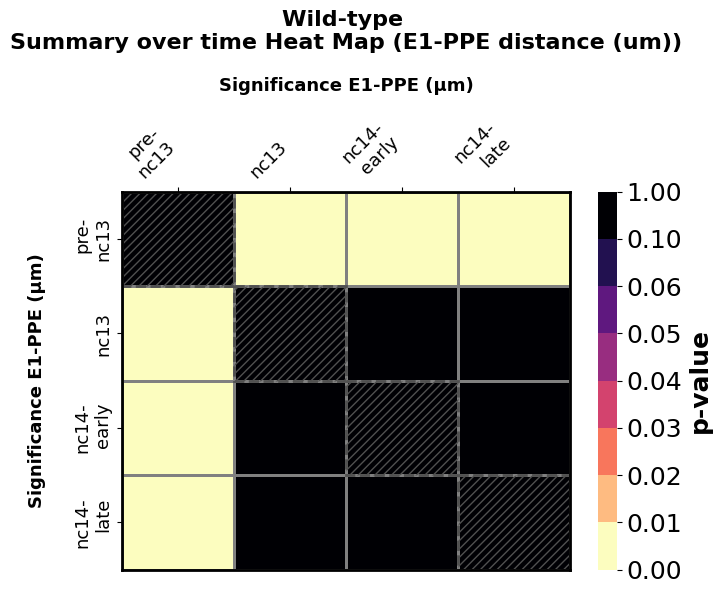

In [56]:
generate_pvalue_heatmap_strict_individual_side(
    dataframes_1=[YW_E1_PPE_nc12, YW_E1_PPE_nc13, YW_E1_PPE_nc14_early, YW_E1_PPE_nc14_late],
    dataframes_2=[YW_E1_PPE_nc12, YW_E1_PPE_nc13, YW_E1_PPE_nc14_early, YW_E1_PPE_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E1-PPE distance (um)",
    title="Wild-type \nSummary over time Heat Map",
    x_axis_label="Significance E1-PPE (μm)",
    y_axis_label="Significance E1-PPE (μm)"
)

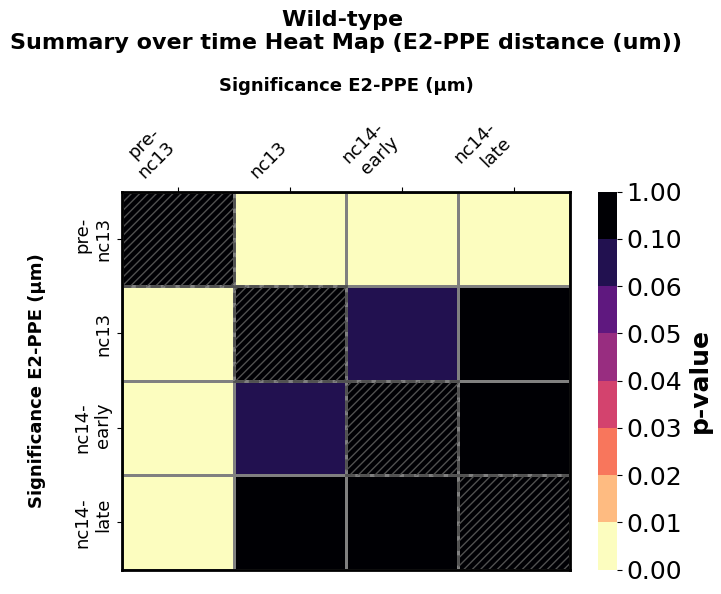

In [57]:
generate_pvalue_heatmap_strict_individual_side(
    dataframes_1=[YW_E2_PPE_nc12, YW_E2_PPE_nc13, YW_E2_PPE_nc14_early, YW_E2_PPE_nc14_late],
    dataframes_2=[YW_E2_PPE_nc12, YW_E2_PPE_nc13, YW_E2_PPE_nc14_early, YW_E2_PPE_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E2-PPE distance (um)",
    title="Wild-type \nSummary over time Heat Map",
    x_axis_label="Significance E2-PPE (μm)",
    y_axis_label="Significance E2-PPE (μm)"
)

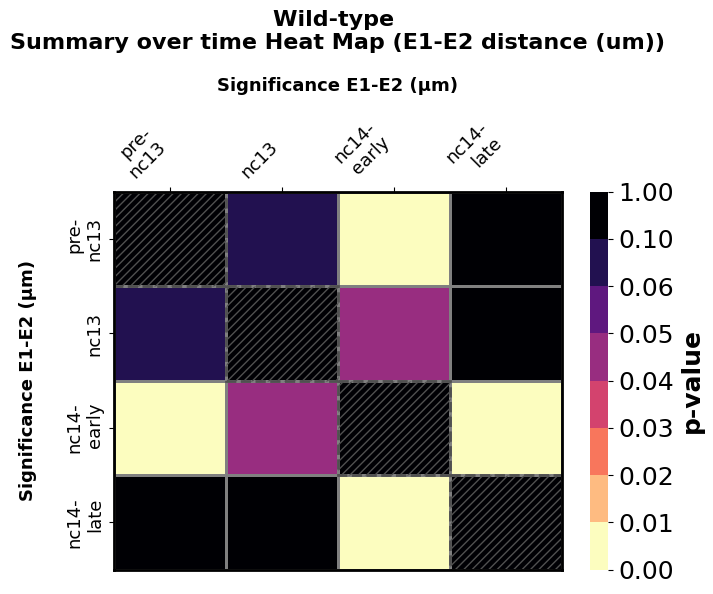

In [58]:
generate_pvalue_heatmap_strict_individual_side(
    dataframes_1=[YW_E1_E2_nc12, YW_E1_E2_nc13, YW_E1_E2_nc14_early, YW_E1_E2_nc14_late],
    dataframes_2=[YW_E1_E2_nc12, YW_E1_E2_nc13, YW_E1_E2_nc14_early, YW_E1_E2_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E1-E2 distance (um)",
    title="Wild-type \nSummary over time Heat Map",
    x_axis_label="Significance E1-E2 (μm)",
    y_axis_label="Significance E1-E2 (μm)"
)

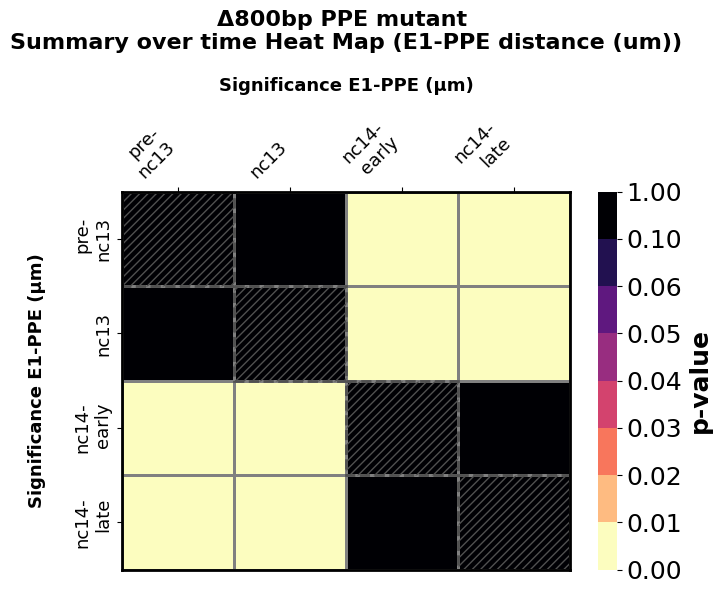

In [59]:
generate_pvalue_heatmap_strict_individual_side(
    dataframes_1=[PPE_E1_PPE_nc12, PPE_E1_PPE_nc13, PPE_E1_PPE_nc14_early, PPE_E1_PPE_nc14_late],
    dataframes_2=[PPE_E1_PPE_nc12, PPE_E1_PPE_nc13, PPE_E1_PPE_nc14_early, PPE_E1_PPE_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E1-PPE distance (um)",
    title="Δ800bp PPE mutant \nSummary over time Heat Map",
    x_axis_label="Significance E1-PPE (μm)",
    y_axis_label="Significance E1-PPE (μm)"
)

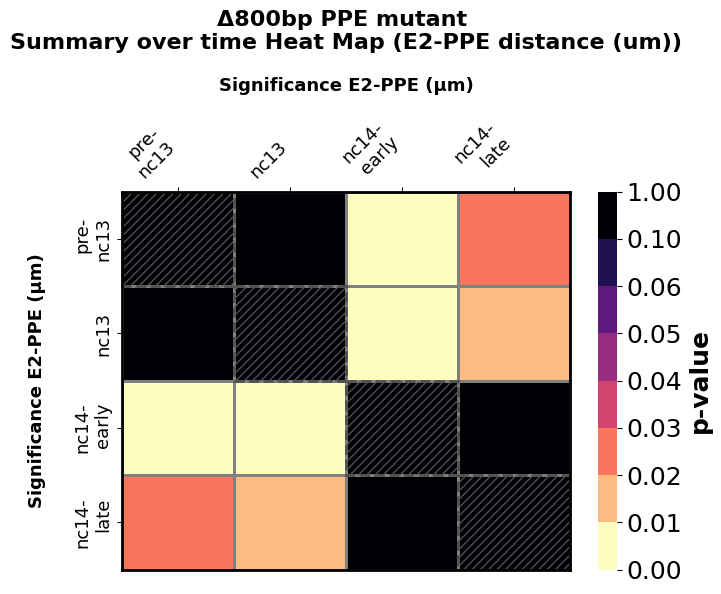

In [60]:
generate_pvalue_heatmap_strict_individual_side(
    dataframes_1=[PPE_E2_PPE_nc12, PPE_E2_PPE_nc13, PPE_E2_PPE_nc14_early, PPE_E2_PPE_nc14_late],
    dataframes_2=[PPE_E2_PPE_nc12, PPE_E2_PPE_nc13, PPE_E2_PPE_nc14_early, PPE_E2_PPE_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E2-PPE distance (um)",
    title="Δ800bp PPE mutant \nSummary over time Heat Map",
    x_axis_label="Significance E2-PPE (μm)",
    y_axis_label="Significance E2-PPE (μm)"
)

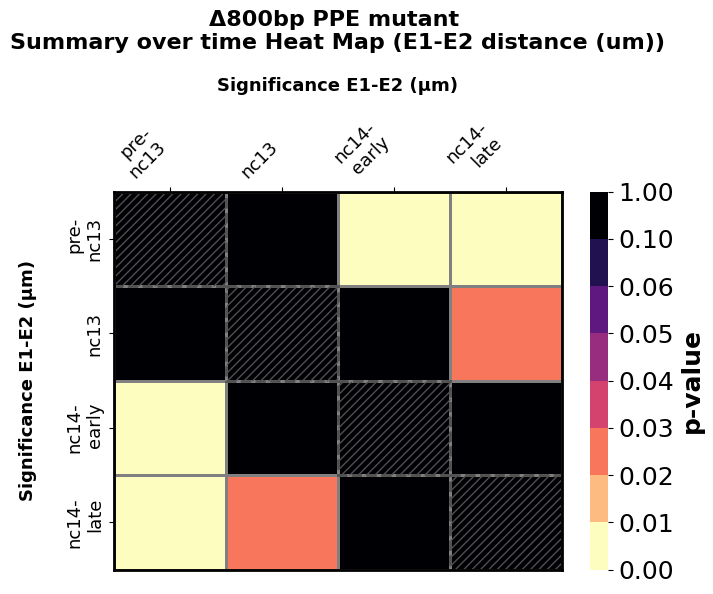

In [61]:
generate_pvalue_heatmap_strict_individual_side(
    dataframes_1=[PPE_E1_E2_nc12, PPE_E1_E2_nc13, PPE_E1_E2_nc14_early, PPE_E1_E2_nc14_late],
    dataframes_2=[PPE_E1_E2_nc12, PPE_E1_E2_nc13, PPE_E1_E2_nc14_early, PPE_E1_E2_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E1-E2 distance (um)",
    title="Δ800bp PPE mutant \nSummary over time Heat Map",
    x_axis_label="Significance E1-E2 (μm)",
    y_axis_label="Significance E1-E2 (μm)"
)

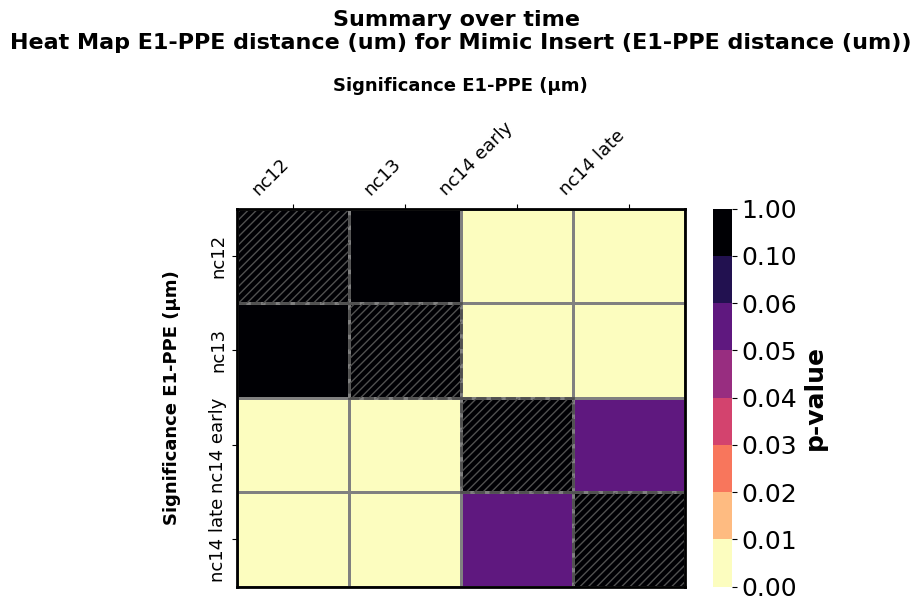

In [62]:
generate_pvalue_heatmap_strict_individual_side(
    dataframes_1=[mimic_insert_E1_PPE_nc12,mimic_insert_E1_PPE_nc13, mimic_insert_E1_PPE_nc14_early, mimic_insert_E1_PPE_nc14_late],
    dataframes_2=[mimic_insert_E1_PPE_nc12,mimic_insert_E1_PPE_nc13, mimic_insert_E1_PPE_nc14_early, mimic_insert_E1_PPE_nc14_late],
    stages_labels=["nc12","nc13", "nc14 early", "nc14 late"],
    distance_column="E1-PPE distance (um)",
    title="Summary over time \nHeat Map E1-PPE distance (um) for Mimic Insert",
    x_axis_label="Significance E1-PPE (μm)",
    y_axis_label="Significance E1-PPE (μm)"
)

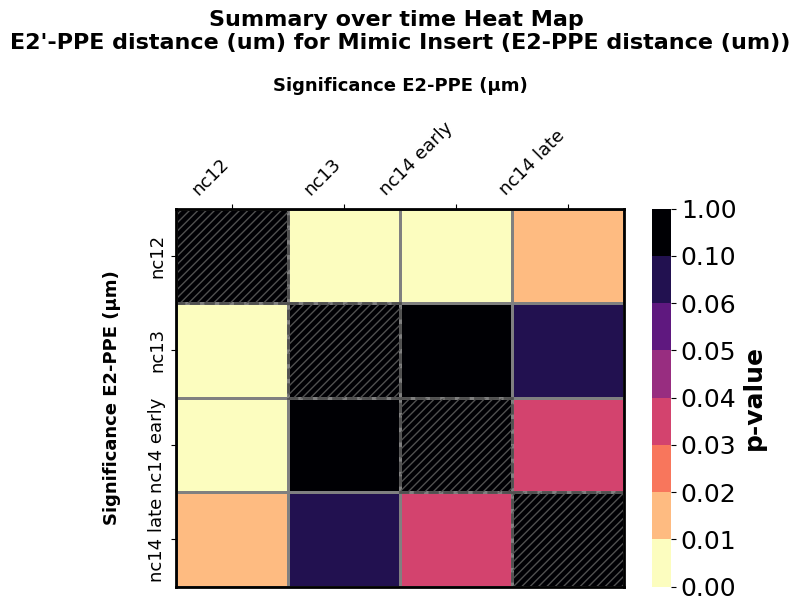

In [63]:
generate_pvalue_heatmap_strict_individual_side(
    dataframes_1=[mimic_insert_E2_PPE_nc12,mimic_insert_E2_PPE_nc13, mimic_insert_E2_PPE_nc14_early, mimic_insert_E2_PPE_nc14_late],
    dataframes_2=[mimic_insert_E2_PPE_nc12,mimic_insert_E2_PPE_nc13, mimic_insert_E2_PPE_nc14_early, mimic_insert_E2_PPE_nc14_late],
    stages_labels=["nc12","nc13", "nc14 early", "nc14 late"],
    distance_column="E2-PPE distance (um)",
    title="Summary over time Heat Map \nE2'-PPE distance (um) for Mimic Insert",
    x_axis_label="Significance E2-PPE (μm)",
    y_axis_label="Significance E2-PPE (μm)"
)

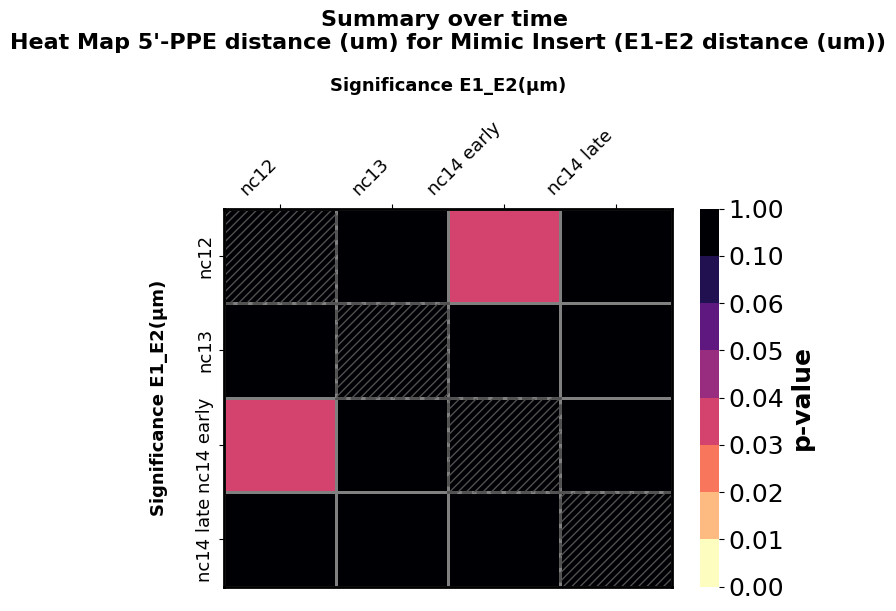

In [64]:
generate_pvalue_heatmap_strict_individual_side(
    dataframes_1=[mimic_insert_E1_E2_nc12,mimic_insert_E1_E2_nc13, mimic_insert_E1_E2_nc14_early, mimic_insert_E1_E2_nc14_late],
    dataframes_2=[mimic_insert_E1_E2_nc12,mimic_insert_E1_E2_nc13, mimic_insert_E1_E2_nc14_early, mimic_insert_E1_E2_nc14_late],
    stages_labels=["nc12","nc13", "nc14 early", "nc14 late"],
    distance_column="E1-E2 distance (um)",
    title="Summary over time \nHeat Map 5'-PPE distance (um) for Mimic Insert",
    x_axis_label="Significance E1_E2(μm)",
    y_axis_label="Significance E1_E2(μm)"
)

# Heat Map WT VS Mutant

In [65]:
def plot_single_row_pvalue_heatmap(
    dataframes_1, dataframes_2, stages_labels, distance_column, 
    title="WT vs PPE — Stage-matched KS p-values"):

    # Compute diagonal-only p-values
    p_values = []
    for df1, df2 in zip(dataframes_1, dataframes_2):
        _, p = ks_2samp(df1[distance_column], df2[distance_column])
        p_values.append(p)

    # Create a 1-row DataFrame
    p_value_df = pd.DataFrame([p_values], index=["WT vs PPE"], columns=stages_labels)

    # Define color map and normalization
    levels = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 1.0]
    cmap = plt.get_cmap("magma_r", len(levels) - 1)
    norm = BoundaryNorm(levels, ncolors=len(levels) - 1, clip=True)

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(10, 1.5))
    heatmap = sns.heatmap(
        p_value_df,
        cmap=cmap,
        norm=norm,
        linewidths=1,
        linecolor='gray',
        cbar=True,
        annot=False,
        fmt=".3f",
        annot_kws={"fontsize": 12},
        square=False,
        cbar_kws={"shrink": 2, "aspect": 20}
    )

    # Format
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label("p-value", fontsize=13, fontweight="bold")
    ax.set_title(f"{title} ({distance_column})", fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel("Developmental Stage", fontsize=12, labelpad=8)
    ax.set_ylabel("", fontsize=12)
    ax.set_yticks([0.5])
    ax.set_yticklabels(["WT vs PPE"], fontsize=12)
    ax.set_xticklabels(stages_labels, rotation=45, ha='right', fontsize=12)

    plt.tight_layout()
    plt.show()


## YW VS PPE

/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1091589485.py:46: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


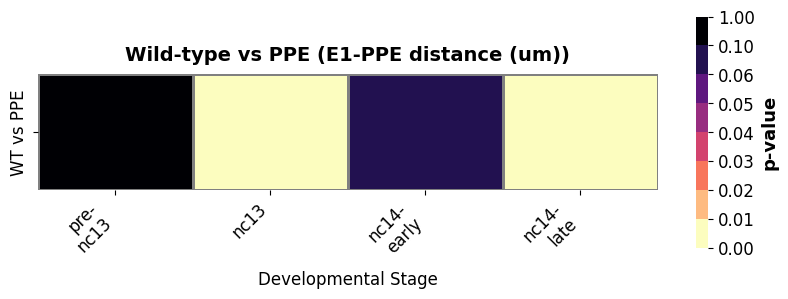

In [66]:
plot_single_row_pvalue_heatmap(
    dataframes_1=[YW_E1_PPE_nc12, YW_E1_PPE_nc13, YW_E1_PPE_nc14_early, YW_E1_PPE_nc14_late],
    dataframes_2=[PPE_E1_PPE_nc12, PPE_E1_PPE_nc13, PPE_E1_PPE_nc14_early, PPE_E1_PPE_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E1-PPE distance (um)",
    title="Wild-type vs PPE"
)

/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1091589485.py:46: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


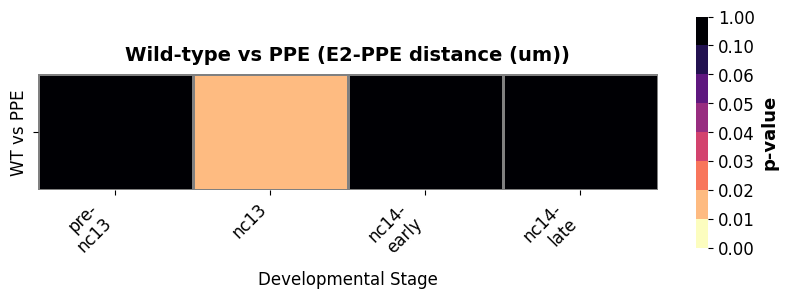

In [67]:
plot_single_row_pvalue_heatmap(
    dataframes_1=[YW_E2_PPE_nc12, YW_E2_PPE_nc13, YW_E2_PPE_nc14_early, YW_E2_PPE_nc14_late],
    dataframes_2=[PPE_E2_PPE_nc12, PPE_E2_PPE_nc13, PPE_E2_PPE_nc14_early, PPE_E2_PPE_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E2-PPE distance (um)",
    title="Wild-type vs PPE"
)

/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1091589485.py:46: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


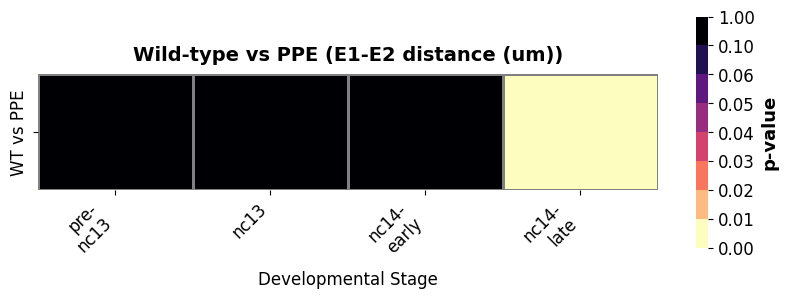

In [68]:
plot_single_row_pvalue_heatmap(
    dataframes_1=[YW_E1_E2_nc12, YW_E1_E2_nc13, YW_E1_E2_nc14_early, YW_E1_E2_nc14_late],
    dataframes_2=[PPE_E1_E2_nc12, PPE_E1_E2_nc13, PPE_E1_E2_nc14_early, PPE_E1_E2_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E1-E2 distance (um)",
    title="Wild-type vs PPE"
)

# YW VS MiMIC

/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1091589485.py:46: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


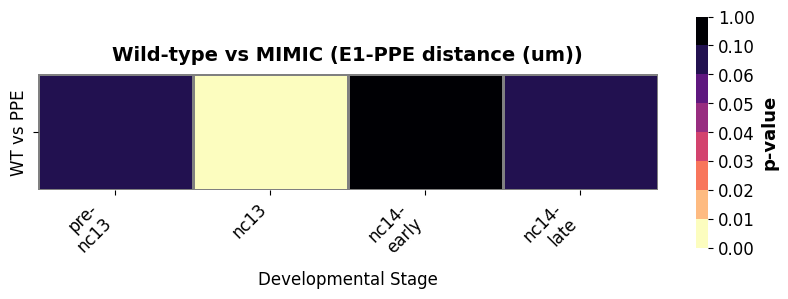

In [69]:
plot_single_row_pvalue_heatmap(
    dataframes_1=[YW_E1_PPE_nc12, YW_E1_PPE_nc13, YW_E1_PPE_nc14_early, YW_E1_PPE_nc14_late],
    dataframes_2=[mimic_insert_E1_PPE_nc12, mimic_insert_E1_PPE_nc13, mimic_insert_E1_PPE_nc14_early, mimic_insert_E1_PPE_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E1-PPE distance (um)",
    title="Wild-type vs MIMIC"
)

/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1091589485.py:46: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


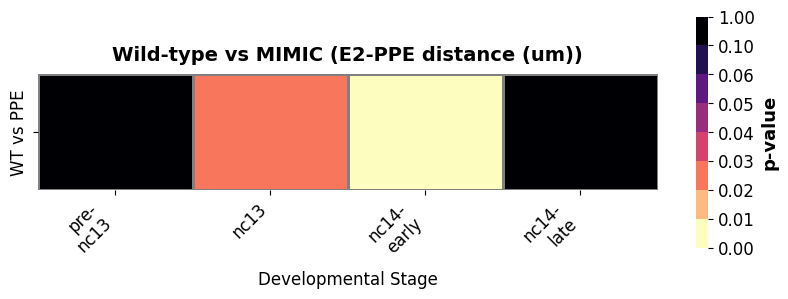

In [70]:
plot_single_row_pvalue_heatmap(
    dataframes_1=[YW_E2_PPE_nc12, YW_E2_PPE_nc13, YW_E2_PPE_nc14_early, YW_E2_PPE_nc14_late],
    dataframes_2=[mimic_insert_E2_PPE_nc12, mimic_insert_E2_PPE_nc13, mimic_insert_E2_PPE_nc14_early, mimic_insert_E2_PPE_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E2-PPE distance (um)",
    title="Wild-type vs MIMIC"
)

/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1091589485.py:46: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


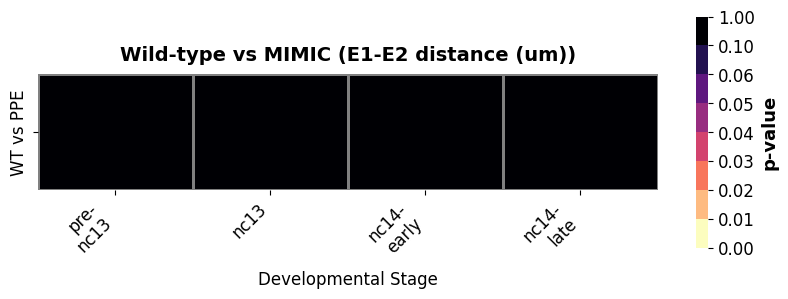

In [71]:
plot_single_row_pvalue_heatmap(
    dataframes_1=[YW_E1_E2_nc12, YW_E1_E2_nc13, YW_E1_E2_nc14_early, YW_E1_E2_nc14_late],
    dataframes_2=[mimic_insert_E1_E2_nc12, mimic_insert_E1_E2_nc13, mimic_insert_E1_E2_nc14_early, mimic_insert_E1_E2_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E1-E2 distance (um)",
    title="Wild-type vs MIMIC"
)

# PPE vs MIMIC

/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1091589485.py:46: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


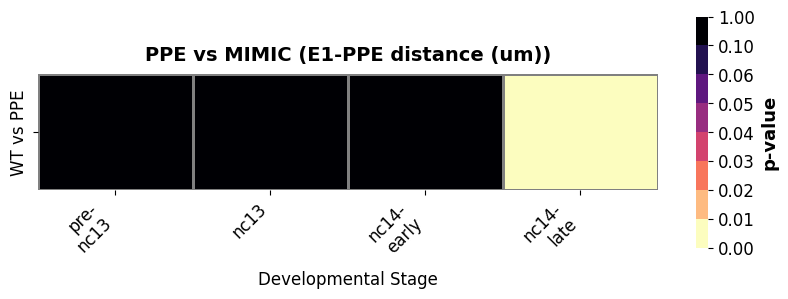

In [72]:
plot_single_row_pvalue_heatmap(
    dataframes_1=[PPE_E1_PPE_nc12, PPE_E1_PPE_nc13, PPE_E1_PPE_nc14_early, PPE_E1_PPE_nc14_late],
    dataframes_2=[mimic_insert_E1_PPE_nc12, mimic_insert_E1_PPE_nc13, mimic_insert_E1_PPE_nc14_early, mimic_insert_E1_PPE_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E1-PPE distance (um)",
    title="PPE vs MIMIC"
)

/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1091589485.py:46: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


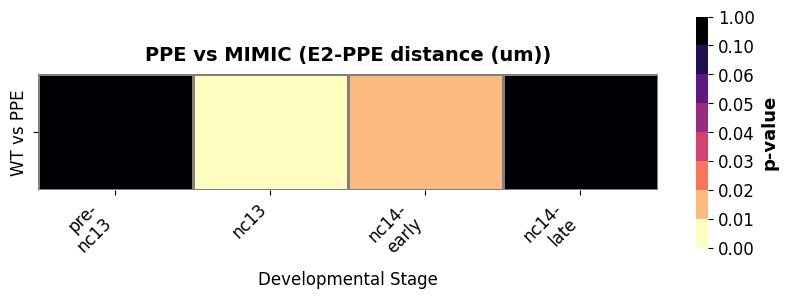

In [73]:
plot_single_row_pvalue_heatmap(
    dataframes_1=[PPE_E2_PPE_nc12, PPE_E2_PPE_nc13, PPE_E2_PPE_nc14_early, PPE_E2_PPE_nc14_late],
    dataframes_2=[mimic_insert_E2_PPE_nc12, mimic_insert_E2_PPE_nc13, mimic_insert_E2_PPE_nc14_early, mimic_insert_E2_PPE_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E2-PPE distance (um)",
    title="PPE vs MIMIC"
)

/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1091589485.py:46: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


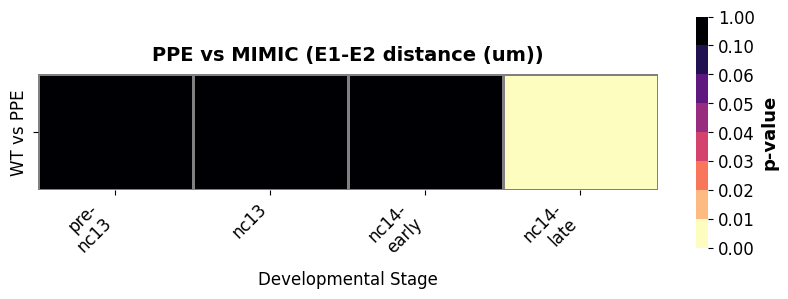

In [74]:
plot_single_row_pvalue_heatmap(
    dataframes_1=[PPE_E1_E2_nc12, PPE_E1_E2_nc13, PPE_E1_E2_nc14_early, PPE_E1_E2_nc14_late],
    dataframes_2=[mimic_insert_E1_E2_nc12, mimic_insert_E1_E2_nc13, mimic_insert_E1_E2_nc14_early, mimic_insert_E1_E2_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E1-E2 distance (um)",
    title="PPE vs MIMIC"
)

# Section V: PDF generation for mutant and wild-type comparison

Comparison PDFs between wildtype and two mutants in Figure S3, S4 are generated. 

In [75]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Legend, LegendItem, HoverTool
import numpy as np
from scipy.stats import gaussian_kde, ks_2samp
from bokeh.io import output_notebook  # Import for inline display
from bokeh.models import Range1d

output_notebook()  # Ensure inline plotting in Jupyter

def generate_pdf_comparison_mutant(sample1_dataframe, sample2_dataframe, distance_column, title_prefix, sample1_name, sample1_color, sample2_name, sample2_color):
    """
    Generate a PDF comparison plot for 2 samples adaptable name and color.
    """

    def preprocess_data(data):
        """Drop NaN values and add small jitter if necessary."""
        data = data.dropna().to_numpy()
        
        # If the data has very few unique values, add jitter
        if np.unique(data).size < 5:
            data += np.random.normal(0, 1e-3, size=data.shape)  # Small noise
        
        return data

    # Convert DataFrames to NumPy arrays
    sample1_data = preprocess_data(sample1_dataframe[distance_column])
    sample2_data = preprocess_data(sample2_dataframe[distance_column])

    # Create the PDF plot
    pdf_plot = figure(
        title=f"{title_prefix} - PDF of {distance_column}",
        x_axis_label=distance_column, y_axis_label="Probability Density",
        tools="pan,wheel_zoom,box_zoom,reset", height=500, width=1000, x_range=(-0.5, 3.5)
    )

    n_bootstraps = 1000  # Number of bootstrap samples

    def calculate_kde_and_ci(data, x_vals):
        """Compute KDE and confidence intervals using bootstrapping."""
        kde = gaussian_kde(data)
        y_vals = kde(x_vals)

        # Bootstrap for confidence intervals
        bootstrapped = np.array([
            gaussian_kde(np.random.choice(data, size=len(data), replace=True))(x_vals)
            for _ in range(n_bootstraps)
        ])
        ci_lower = np.percentile(bootstrapped, 2.5, axis=0)
        ci_upper = np.percentile(bootstrapped, 97.5, axis=0)

        return y_vals, ci_lower, ci_upper

    x_vals = np.linspace(min(sample1_data.min(), sample2_data.min()),
                         max(sample1_data.max(), sample2_data.max()), 100)

    # Calculate KDE and CI for each dataset
    y_sample1, ci_lower_sample1, ci_upper_sample1 = calculate_kde_and_ci(sample1_data, x_vals)
    y_sample2, ci_lower_sample2, ci_upper_sample2 = calculate_kde_and_ci(sample2_data, x_vals)

    # Calculate medians and number of data points
    median_sample1, median_sample2 = np.median(sample1_data), np.median(sample2_data)
    n_sample1, n_sample2 = len(sample1_data), len(sample2_data)
    
    # Customize title and axes for boldness and larger font sizes
    pdf_plot.title.text_font_size = "13pt"  # Larger font for the title
    pdf_plot.title.align = "center"  # Center align the title
    pdf_plot.axis.axis_label_text_font_size = "25pt"  # Larger font size for axis labels
    pdf_plot.axis.axis_label_text_font_style = "bold"  # Bold axis labels
    pdf_plot.axis.major_label_text_font_size = "18pt"  # Larger font size for tick labels
    pdf_plot.axis.major_label_text_font_style = "bold"  # Bold tick labels
    pdf_plot.axis.axis_line_width = 2  # Thicker axis lines
    pdf_plot.axis.axis_line_color = "black"  # Darker axis lines for emphasis
    pdf_plot.axis.major_tick_line_width = 3  # Thicker major ticks
    pdf_plot.axis.major_tick_line_color = "black"  # Darker major ticks
    pdf_plot.axis.minor_tick_line_width = 2  # Optionally thicker minor ticks
    pdf_plot.axis.minor_tick_line_color = "black"  # Optionally make minor ticks visible
    pdf_plot.title.standoff = 20  # Move the title higher from the graph (adjust as needed)
    pdf_plot.x_range = Range1d(start=-0.1, end=2)
    pdf_plot.y_range = Range1d(start=0, end=2.2)
    

    # Function to add sample1 glyphs
    def add_sample1_glyphs(pdf_plot, x_vals, y_vals, ci_lower, ci_upper, sample1_name, color, n_sample1, median_sample1): 
        """ Creating mutant PDF with shaded confidence intervals. """
        source_sample1 = ColumnDataSource(data={'x':x_vals, 'y':y_vals, 'ci_lower':ci_lower, 'ci_upper':ci_upper})
        
        # Line and shading for mutant: 
        line_sample1 = pdf_plot.line('x','y', source=source_sample1, line_width=3, color=color, name=sample1_name)
        area_sample1 = pdf_plot.varea(x='x', y1='ci_lower', y2='ci_upper', source=source_sample1, fill_alpha=0.25, fill_color=color)

        # Create legend item with adaptable name
        legend_sample1 = LegendItem(label=f"{sample1_name}", renderers=[line_sample1, area_sample1])
        
        return line_sample1, area_sample1, legend_sample1
    
    # Adding mutant glyphs dynamically
    _, _, legend_sample1 = add_sample1_glyphs(
        pdf_plot, x_vals, y_sample1, ci_lower_sample1, ci_upper_sample1,
        sample1_name, sample1_color, n_sample1, median_sample1
    )
    
    # Function to add sample2 glyphs
    def add_sample2_glyphs(pdf_plot, x_vals, y_vals, ci_lower, ci_upper, sample2_name, color, n_sample2, median_sample2): 
        """ Creating mutant PDF with shaded confidence intervals. """
        source_sample2 = ColumnDataSource(data={'x':x_vals, 'y':y_vals, 'ci_lower':ci_lower, 'ci_upper':ci_upper})
        
        # Line and shading for mutant: 
        line_sample2 = pdf_plot.line('x','y', source=source_sample2, line_width=3, color=color, name=sample2_name)
        area_sample2 = pdf_plot.varea(x='x', y1='ci_lower', y2='ci_upper', source=source_sample2, fill_alpha=0.25, fill_color=color)

        # Create legend item with adaptable name
        legend_sample2 = LegendItem(label=f"{sample2_name}", renderers=[line_sample2, area_sample2])
        
        return line_sample2, area_sample2, legend_sample2
    
    #Adding mutant glyphs dynamically
    _, _, legend_sample2 = add_sample2_glyphs(
        pdf_plot, x_vals, y_sample2, ci_lower_sample2, ci_upper_sample2,
        sample2_name, sample2_color, n_sample2, median_sample2
    
    )
    # Compute min and max for median line range
    y_min_sample_1 = min(y_sample1)  # Smallest density value for sample 1 
    y_max_sample_1 = max(y_sample1)  # Largest density value for sample 1 

    y_min_sample_2 = min(y_sample2)  # Smallest density value for sample 2 
    y_max_sample_2 = max(y_sample2)  # Largest density value for sample 2 

    kde_sample1 = gaussian_kde(sample1_data)
    kde_sample2 = gaussian_kde(sample2_data)
    
    center_y1 = kde_sample1(median_sample1)[0] + 0.05
    center_y2 = kde_sample2(median_sample2)[0] + 0.05
    
    # Sample YW
    #pdf_plot.ellipse(
        #x=[median_sample1],
        #y=[center_y1],
        #width=0.1,
        #height=0.2,
        #line_color=sample1_color,
        #line_width=3,
        #fill_alpha=0,
        #line_dash="dotted"
    #)

    # Sample PPE
    #pdf_plot.ellipse(
        #x=[median_sample2],
        #y=[center_y2],
        #width=0.1,
        #height=0.2,
        #line_color=sample2_color,
        #line_width=3,
        #fill_alpha=0,
        #line_dash="dotted"
    #)
    
    # Add legends to the plot
    legend = Legend(items=[legend_sample1, legend_sample2])
    pdf_plot.add_layout(legend, 'right')
    pdf_plot.legend.click_policy = "hide"  # Interactive hiding
    # Remove gridlines
    pdf_plot.xgrid.visible = False
    pdf_plot.ygrid.visible = False

    # Hover tool
    pdf_plot.add_tools(HoverTool(tooltips=[("x", "$x"), ("y", "$y")]))

    # Perform K-S tests
    ks_pval = ks_2samp(sample1_data, sample2_data).pvalue
    print(f"K-S Test ({sample1_name} vs {sample2_name}): {ks_pval:.10f}")

    # Show the plot inline
    show(pdf_plot)

Loading BokehJS ...

### Comparing pre- nc13 Wild-type and PPE Mutant. 

In [76]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_PPE_nc12,
    sample2_dataframe=PPE_E1_PPE_nc12,
    distance_column="E1-PPE distance (um)",
    title_prefix="Comparison of YW, PPE for nc12",
    sample1_name = "Wild-type control nc12",
    sample1_color = "#505050",
    sample2_name = "Δ800PPE nc12",
    sample2_color = "#1E90FF"
)

K-S Test (Wild-type control nc12 vs Δ800PPE nc12): 0.1005590536


In [77]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E2_PPE_nc12,
    sample2_dataframe=PPE_E2_PPE_nc12,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE for nc12",
    sample1_name = "Wild-type control nc12",
    sample1_color = "#505050",
    sample2_name = "Δ800PPE nc12",
    sample2_color ="#1E90FF"
)

K-S Test (Wild-type control nc12 vs Δ800PPE nc12): 0.1356241350


In [78]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_E2_nc12,
    sample2_dataframe=PPE_E1_E2_nc12,
    distance_column="E1-E2 distance (um)",
    title_prefix="Comparison of YW, PPE for nc12",
    sample1_name = "Wild-type control nc12",
    sample1_color = "#505050",
    sample2_name = "Δ800PPE nc12",
    sample2_color ="#1E90FF"
)

K-S Test (Wild-type control nc12 vs Δ800PPE nc12): 0.8936059350


### Comparing nc13 Wild-type and PPE Mutant. 

In [79]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_PPE_nc13,
    sample2_dataframe=PPE_E1_PPE_nc13,
    distance_column="E1-PPE distance (um)",
    title_prefix="Comparison of YW, PPE for nc13",
    sample1_name = "Wild-type control nc13",
    sample1_color = "#505050",
    sample2_name = "Δ800PPE nc13",
    sample2_color ="#1E90FF")

K-S Test (Wild-type control nc13 vs Δ800PPE nc13): 0.0025520452


In [80]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E2_PPE_nc13,
    sample2_dataframe=PPE_E2_PPE_nc13,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE for nc13",
    sample1_name = "Wild-type control nc13",
    sample1_color = "#505050",
    sample2_name = "Δ800PPE nc13",
    sample2_color ="#1E90FF"
)

K-S Test (Wild-type control nc13 vs Δ800PPE nc13): 0.0133833546


In [81]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_E2_nc13,
    sample2_dataframe=PPE_E1_E2_nc13,
    distance_column="E1-E2 distance (um)",
    title_prefix="Comparison of YW, PPE for nc13",
    sample1_name = "Wild-type control nc13",
    sample1_color = "#505050",
    sample2_name = "Δ800PPE nc13",
    sample2_color ="#1E90FF"
)

K-S Test (Wild-type control nc13 vs Δ800PPE nc13): 0.7778180048


### Comparing nc14 early Wild-type and PPE Mutant. 

In [82]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_PPE_nc14_early,
    sample2_dataframe=PPE_E1_PPE_nc14_early,
    distance_column="E1-PPE distance (um)",
    title_prefix="Comparison of YW, PPE for nc14 early",
    sample1_name = "Wild-type control nc14 early",
    sample1_color = "#505050",
    sample2_name = "Δ800PPE nc14 early",
    sample2_color ="#1E90FF"
)

K-S Test (Wild-type control nc14 early vs Δ800PPE nc14 early): 0.0994568677


In [83]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E2_PPE_nc14_early,
    sample2_dataframe=PPE_E2_PPE_nc14_early,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE for nc14 early",
    sample1_name = "Wild-type control nc14_early",
    sample1_color = "#505050",
    sample2_name = "Δ800PPE nc14 early",
    sample2_color ="#1E90FF"
)

K-S Test (Wild-type control nc14_early vs Δ800PPE nc14 early): 0.9966660592


In [84]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_E2_nc14_early,
    sample2_dataframe=PPE_E1_E2_nc14_early,
    distance_column="E1-E2 distance (um)",
    title_prefix="Comparison of YW, PPE for nc14 early",
    sample1_name = "Wild-type control nc14_early",
    sample1_color = "#505050",
    sample2_name = "Δ800PPE nc14 early",
    sample2_color ="#1E90FF"
)

K-S Test (Wild-type control nc14_early vs Δ800PPE nc14 early): 0.5318133759


### Comparing nc14 late Wild-type and PPE Mutant. 

In [85]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_PPE_nc14_late,
    sample2_dataframe=PPE_E1_PPE_nc14_late,
    distance_column="E1-PPE distance (um)",
    title_prefix="Comparison of YW, PPE for nc14 late",
    sample1_name = "Wild-type control nc14 late",
    sample1_color = "#505050",
    sample2_name = "Δ800PPE nc14 late",
    sample2_color ="#1E90FF"
)

K-S Test (Wild-type control nc14 late vs Δ800PPE nc14 late): 0.0000836718


In [86]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E2_PPE_nc14_late,
    sample2_dataframe=PPE_E2_PPE_nc14_late,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE for nc14 late",
    sample1_name = "Wild-type control nc14-late",
    sample1_color = "#505050",
    sample2_name = "Δ800PPE nc14 late",
    sample2_color ="#1E90FF"
)

K-S Test (Wild-type control nc14-late vs Δ800PPE nc14 late): 0.4164983613


In [87]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_E2_nc14_late,
    sample2_dataframe=PPE_E1_E2_nc14_late,
    distance_column="E1-E2 distance (um)",
    title_prefix="Comparison of YW, PPE for nc14 late",
    sample1_name = "Wild-type control nc14-late",
    sample1_color = "#505050",
    sample2_name = "Δ800PPE nc14 late",
    sample2_color ="#1E90FF"
)

K-S Test (Wild-type control nc14-late vs Δ800PPE nc14 late): 0.0025454864


# MIMIC VS YW ovetime

In [88]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_PPE_nc12,
    sample2_dataframe=mimic_insert_E1_PPE_nc12,
    distance_column="E1-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 for nc12",
    sample1_name = "Wild-type control",
    sample1_color = "#505050",
    sample2_name = "MiMIC Insertion nc13",
    sample2_color ="#DC143C"
)

K-S Test (Wild-type control vs MiMIC Insertion nc13): 0.0812852118


In [89]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E2_PPE_nc12,
    sample2_dataframe=mimic_insert_E2_PPE_nc12,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 for nc12",
    sample1_name = "Wild-type control",
    sample1_color = "#505050",
    sample2_name = "MiMIC Insertion nc13",
    sample2_color ="#DC143C"
)

K-S Test (Wild-type control vs MiMIC Insertion nc13): 0.3774451409


In [90]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_E2_nc12,
    sample2_dataframe=mimic_insert_E1_E2_nc12,
    distance_column="E1-E2 distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 for nc12",
    sample1_name = "Wild-type control",
    sample1_color = "#505050",
    sample2_name = "MiMIC Insertion nc13",
    sample2_color ="#DC143C"
)

K-S Test (Wild-type control vs MiMIC Insertion nc13): 0.9773394321


In [91]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_PPE_nc13,
    sample2_dataframe=mimic_insert_E1_PPE_nc13,
    distance_column="E1-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc13",
    sample1_name = "Wild-type control",
    sample1_color = "#505050",
    sample2_name = "MiMIC Insertion nc13",
    sample2_color ="#DC143C"
)

K-S Test (Wild-type control vs MiMIC Insertion nc13): 0.0014809993


In [92]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E2_PPE_nc13,
    sample2_dataframe=mimic_insert_E2_PPE_nc13,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc13",
    sample1_name = "Wild-type control",
    sample1_color = "#505050",
    sample2_name = "MiMIC Insertion nc13",
    sample2_color ="#DC143C"
)

K-S Test (Wild-type control vs MiMIC Insertion nc13): 0.0274874860


In [93]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_E2_nc13,
    sample2_dataframe=mimic_insert_E1_E2_nc13,
    distance_column="E1-E2 distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc13",
    sample1_name = "Wild-type control",
    sample1_color = "#505050",
    sample2_name = "MiMIC Insertion nc13",
    sample2_color ="#DC143C"
)

K-S Test (Wild-type control vs MiMIC Insertion nc13): 0.5863480085


In [94]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_PPE_nc14_early,
    sample2_dataframe=mimic_insert_E1_PPE_nc14_early,
    distance_column="E1-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 for nc14 early",
    sample1_name = "Wild-type control",
    sample1_color = "#505050",
    sample2_name = "MiMIC Insertion nc14 early",
    sample2_color ="#DC143C"
)

K-S Test (Wild-type control vs MiMIC Insertion nc14 early): 0.1534403296


In [95]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E2_PPE_nc14_early,
    sample2_dataframe=mimic_insert_E2_PPE_nc14_early,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 for nc14 early",
    sample1_name = "Wild-type control",
    sample1_color = "#505050",
    sample2_name = "MiMIC Insertion nc14 early",
    sample2_color ="#DC143C"
)

K-S Test (Wild-type control vs MiMIC Insertion nc14 early): 0.0057921817


In [96]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_E2_nc14_early,
    sample2_dataframe=mimic_insert_E1_E2_nc14_early,
    distance_column="E1-E2 distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 for nc14 early",
    sample1_name = "Wild-type control",
    sample1_color = "#505050",
    sample2_name = "MiMIC Insertion nc14 early",
    sample2_color ="#DC143C"
)

K-S Test (Wild-type control vs MiMIC Insertion nc14 early): 0.1953524294


In [97]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E2_PPE_nc14_early,
    sample2_dataframe=mimic_insert_E2_PPE_nc14_early,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E2 for nc14 early",
    sample1_name = "Wild-type control",
    sample1_color = "#505050",
    sample2_name = "MiMIC Insertion nc14 late",
    sample2_color ="#DC143C"
)

K-S Test (Wild-type control vs MiMIC Insertion nc14 late): 0.0057921817


In [98]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_PPE_nc14_late,
    sample2_dataframe=mimic_insert_E1_PPE_nc14_late,
    distance_column="E1-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc14 late",
    sample1_name = "Wild-type control",
    sample1_color = "#505050",
    sample2_name = "MiMIC Insertion nc14 late",
    sample2_color ="#DC143C"
)

K-S Test (Wild-type control vs MiMIC Insertion nc14 late): 0.0726294654


In [99]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E2_PPE_nc14_late,
    sample2_dataframe=mimic_insert_E2_PPE_nc14_late,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc14 late",
    sample1_name = "Wild-type control",
    sample1_color = "#505050",
    sample2_name = "MiMIC Insertion nc14 late",
    sample2_color ="#DC143C"
)

K-S Test (Wild-type control vs MiMIC Insertion nc14 late): 0.1898731805


In [100]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_E2_nc14_late,
    sample2_dataframe=mimic_insert_E1_E2_nc14_late,
    distance_column="E1-E2 distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc14 late",
    sample1_name = "Wild-type control",
    sample1_color = "#505050",
    sample2_name = "MiMIC Insertion nc14 late",
    sample2_color ="#DC143C"
)

K-S Test (Wild-type control vs MiMIC Insertion nc14 late): 0.5767303017


## PPE vs MIMIC

In [101]:
generate_pdf_comparison_mutant(
    sample1_dataframe=PPE_E1_PPE_nc12,
    sample2_dataframe=mimic_insert_E1_PPE_nc12,
    distance_column="E1-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc12",
    sample1_name = "PPE",
    sample1_color ="#1E90FF",
    sample2_name = "MiMIC Insertion nc12",
    sample2_color ="#DC143C"
)

K-S Test (PPE vs MiMIC Insertion nc12): 0.2990813184


In [102]:
generate_pdf_comparison_mutant(
    sample1_dataframe=PPE_E2_PPE_nc12,
    sample2_dataframe=mimic_insert_E2_PPE_nc12,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc12",
    sample1_name = "PPE",
    sample1_color ="#1E90FF",
    sample2_name = "MiMIC Insertion nc12",
    sample2_color ="#DC143C"
)

K-S Test (PPE vs MiMIC Insertion nc12): 0.2233957240


In [103]:
generate_pdf_comparison_mutant(
    sample1_dataframe=PPE_E1_E2_nc13,
    sample2_dataframe=mimic_insert_E1_E2_nc13,
    distance_column="E1-E2 distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc13",
    sample1_name = "PPE",
    sample1_color ="#1E90FF",
    sample2_name = "MiMIC Insertion nc13",
    sample2_color ="#DC143C"
)

K-S Test (PPE vs MiMIC Insertion nc13): 0.8261394834


In [104]:
generate_pdf_comparison_mutant(
    sample1_dataframe=PPE_E1_PPE_nc13,
    sample2_dataframe=mimic_insert_E1_PPE_nc13,
    distance_column="E1-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc13",
    sample1_name = "PPE",
    sample1_color ="#1E90FF",
    sample2_name = "MiMIC Insertion nc13",
    sample2_color ="#DC143C"
)

K-S Test (PPE vs MiMIC Insertion nc13): 0.1866062178


In [105]:
generate_pdf_comparison_mutant(
    sample1_dataframe=PPE_E2_PPE_nc13,
    sample2_dataframe=mimic_insert_E2_PPE_nc13,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc13",
    sample1_name = "PPE",
    sample1_color ="#1E90FF",
    sample2_name = "MiMIC Insertion nc13",
    sample2_color ="#DC143C"
)

K-S Test (PPE vs MiMIC Insertion nc13): 0.0000035326


In [106]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_E2_nc13,
    sample2_dataframe=mimic_insert_E1_E2_nc13,
    distance_column="E1-E2 distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc13",
    sample1_name = "PPE",
    sample1_color ="#1E90FF",
    sample2_name = "MiMIC Insertion nc13",
    sample2_color ="#DC143C"
)

K-S Test (PPE vs MiMIC Insertion nc13): 0.5863480085


In [107]:
generate_pdf_comparison_mutant(
    sample1_dataframe=PPE_E1_PPE_nc14_early,
    sample2_dataframe=mimic_insert_E1_PPE_nc14_early,
    distance_column="E1-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc14_early",
    sample1_name = "PPE",
    sample1_color ="#1E90FF",
    sample2_name = "MiMIC Insertion nc14 early",
    sample2_color ="#DC143C"
)

K-S Test (PPE vs MiMIC Insertion nc14 early): 0.9770288670


In [108]:
generate_pdf_comparison_mutant(
    sample1_dataframe=PPE_E2_PPE_nc14_early,
    sample2_dataframe=mimic_insert_E2_PPE_nc14_early,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc14_early",
    sample1_name = "PPE",
    sample1_color ="#1E90FF",
    sample2_name = "MiMIC Insertion nc14 late",
    sample2_color ="#DC143C"
)

K-S Test (PPE vs MiMIC Insertion nc14 late): 0.0125873166


In [109]:
generate_pdf_comparison_mutant(
    sample1_dataframe=PPE_E1_E2_nc14_early,
    sample2_dataframe=mimic_insert_E1_E2_nc14_early,
    distance_column="E1-E2 distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc14_early",
    sample1_name = "PPE",
    sample1_color ="#1E90FF",
    sample2_name = "MiMIC Insertion nc14 early",
    sample2_color ="#DC143C"
)

K-S Test (PPE vs MiMIC Insertion nc14 early): 0.5663529920


In [110]:
generate_pdf_comparison_mutant(
    sample1_dataframe=PPE_E1_PPE_nc14_late,
    sample2_dataframe=mimic_insert_E1_PPE_nc14_late,
    distance_column="E1-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc14_late",
    sample1_name = "PPE",
    sample1_color ="#1E90FF",
    sample2_name = "MiMIC Insertion nc14 early",
    sample2_color ="#DC143C"
)

K-S Test (PPE vs MiMIC Insertion nc14 early): 0.0002534647


In [111]:
generate_pdf_comparison_mutant(
    sample1_dataframe=PPE_E2_PPE_nc14_late,
    sample2_dataframe=mimic_insert_E2_PPE_nc14_late,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc14_late",
    sample1_name = "PPE",
    sample1_color ="#1E90FF",
    sample2_name = "MiMIC Insertion nc14 late",
    sample2_color ="#DC143C"
)

K-S Test (PPE vs MiMIC Insertion nc14 late): 0.2807038855


In [112]:
generate_pdf_comparison_mutant(
    sample1_dataframe=PPE_E1_E2_nc14_late,
    sample2_dataframe=mimic_insert_E1_E2_nc14_late,
    distance_column="E1-E2 distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at E1 enhancer for nc14_late",
    sample1_name = "PPE",
    sample1_color ="#1E90FF",
    sample2_name = "MiMIC Insertion nc14 late",
    sample2_color ="#DC143C"
)

K-S Test (PPE vs MiMIC Insertion nc14 late): 0.0014171121


In [114]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon

def calculate_triangle_vertices_OG(d1, d2, d3):
    """
    Calculate the vertices of a triangle in 2D space given three distances:
    d1, d2, and d3.

    Parameters:
        d3 (float): Distance between point A and point B.
        d1 (float): Distance between point B and point C.
        d2 (float): Distance between point A and point C.

    Returns:
        tuple: Three vertices of the triangle in 2D space as (A, B, C).
               Each vertex is a tuple (x, y).
    """
    if not (d1 + d2 >= d3 and d1 + d3 > d2 and d2 + d3 >= d1):
        raise ValueError("The provided distances do not form a valid triangle.")
    A = (0, 0)
    B = (d3, 0)
    x_C = (d3**2 + d2**2 - d1**2) / (2 * d3)
    y_C = np.sqrt(d2**2 - x_C**2)
    C = (x_C, y_C)
    return A, B, C

# Contour triangles

In [120]:
def compute_triangle_vertices_from_PDF(d1_arr, d2_arr, p_d1_arr, p_d2_arr, d3):
    """
    Vectorized computation of triangle coordinates and joint PDF values.
    Here, we assumes that d1 and d2 are independent so the joint PDF is the product
    of individual d1 and d2. 
    
    Triangle Inequality Mask is also applied to make sure only valid triangles.  
    are kept.
    
    This generated a 2D scatter showing likely triangle configurations based on
    observed pairwise distances.
    """
    D1, D2 = np.meshgrid(d1_arr, d2_arr, indexing='ij')
    P1, P2 = np.meshgrid(p_d1_arr, p_d2_arr, indexing='ij')
    p = P1 * P2

    # Triangle inequality mask
    valid = (D1 + D2 >= d3) & (D1 + d3 >= D2) & (D2 + d3 >= D1)

    # Coordinates
    x_C = np.where(valid, (d3**2 + D2**2 - D1**2) / (2 * d3), np.nan)
    y_C = np.where(valid, np.sqrt(np.maximum(0, D2**2 - x_C**2)), np.nan)

    return x_C, y_C, np.where(valid, p, np.nan)

def enhance_plot_axis(ax, font_size=18, line_width=3):
    """
    Enhances the plot axis by increasing font size, bolding text, and thickening lines.

    Parameters:
        ax (matplotlib.axes.Axes): The axis to modify.
        font_size (int): The size of the tick labels.
        line_width (int): The width of the axis lines.
    """
    # Set font size and bold text for axis labels and tick labels
    ax.xaxis.label.set_fontsize(font_size)
    ax.yaxis.label.set_fontsize(font_size)
    ax.xaxis.label.set_fontweight('bold')
    ax.yaxis.label.set_fontweight('bold')
    
    ax.tick_params(axis='both', which='major', labelsize=font_size, width=line_width)
    
    # Increase axis line thickness
    for spine in ax.spines.values():
        spine.set_linewidth(line_width)

In [121]:
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import NearestNDInterpolator
import numpy as np

def compute_weighted_Z(d1_arr, d2_arr, p_d1_arr, p_d2_arr,
                       d3_arr, p_d3_arr, xi, yi,
                       num_samples=50, subsample_stride=3,tail_frac=0.1, tail_boost=3, return_mode_d3=False):
    """
    Compute a weighted 2D PDF surface by integrating over triangle space
    using evenly spaced d3 values and normalized weights.

    Returns:
        Z_weighted: 2D array of weighted probability surface
        X_grid, Y_grid: coordinate grids
        mode_d3 (optional): d3 value whose PDF gives triangle closest to PDF peak
        
    First we created a 2D grid in which we evalulate triangle vertex coordinates. 
    In order to save time, we picks even spaced d3 to avoid bias. In order 
    to make sure everything is a valid PDF we normalizes the sum to 1. 
    
    Riemann sum approximation to get the weights of the d3 to ensure that contributions
    to final surface are proportional to the total probability density area under p_d3. 
    
    Second, we initializes an empty PDF grid which iterates over all sampled d3 values
    and their weights. For each fixed d3 we compute a triangle shapes from d1, d3 also. 
    This can give us a set of triangle coordinates (x_C, y_C) with a corresponding joint probability
    value (p_val) for each triangle. However, these triangle coordinates are irregularly
    spaced and is not evenly spaced on a rectangular grid. Hence, the interpolator (NearestNDInterpolator)
    takes the valid triangle positions and their probability, interpolates the values to 
    a smooth defined grid. Hence, each point on the grid get assigned a value from the
    nearest original data point in (x,y) triangle space. 
    
    After plotted, the interpolator is normalizes so the whole PDF surface sums to 1. 
    Then, PDF is multiplied by the weight (probability of d3). 
    This weighted contribution is added to the joint probability density. 
    Final normalization ensures the total surface d1,d2,d3 joint probability intergrates to 1 across all d3. 
    """
    # Create grid
    X_grid, Y_grid = np.meshgrid(xi, yi)

   # --- Evenly spaced d3 sampling ---
    indices_even = np.linspace(0, len(d3_arr) - 1, num_samples, dtype=int)
    d3_sampled = d3_arr[indices_even]
    p_d3_sampled = p_d3_arr[indices_even]
    p_d3_sampled /= np.sum(p_d3_sampled)  # normalize
    
    # Convert p_d3 to weights via numerical integration (Riemann sum)
    bin_edges = np.concatenate([
        [d3_sampled[0] - (d3_sampled[1] - d3_sampled[0]) / 2],
        (d3_sampled[:-1] + d3_sampled[1:]) / 2,
        [d3_sampled[-1] + (d3_sampled[-1] - d3_sampled[-2]) / 2]
    ])
    
    bin_widths = np.diff(bin_edges)
    weights = p_d3_sampled * bin_widths
    weights /= np.sum(weights)

    # --- Optional subsampling for performance ---
    d1_sub = d1_arr[::subsample_stride]
    p_d1_sub = p_d1_arr[::subsample_stride]
    d2_sub = d2_arr[::subsample_stride]
    p_d2_sub = p_d2_arr[::subsample_stride]

    Z_weighted = np.zeros_like(X_grid)
    total_weight = 0
    dx, dy = xi[1] - xi[0], yi[1] - yi[0]  # Grid resolution for area normalization
    for d3, w in zip(d3_sampled, weights):
        x_coords, y_coords, p_vals = compute_triangle_vertices_from_PDF(
            d1_sub, d2_sub, p_d1_sub, p_d2_sub, d3
        )

        valid = ~np.isnan(x_coords) & ~np.isnan(y_coords) & ~np.isnan(p_vals)
        if np.count_nonzero(valid) == 0:
            continue
            
        interpolator = NearestNDInterpolator(
            list(zip(x_coords[valid], y_coords[valid])), 
            p_vals[valid]
        )
        Z_interp = interpolator(X_grid, Y_grid)
        #print("Fraction of NaNs in Z_interp:", np.isnan(Z_interp).mean())
        #Z_interp = np.nan_to_num(Z_interp, nan=0.0)
        area = np.sum(Z_interp) * dx * dy
        if area > 0:
            Z_interp /= area  # Normalize each surface
            Z_weighted += Z_interp * w
            if return_mode_d3:
                Z_stack.append(Z_interp)
                d3_used.append(d3)
        total_weight += w
    if total_weight == 0:
        raise ValueError("Total weight is zero in compute_weighted_Z.")
    Z_weighted /= total_weight
    print (total_weight)
    print(f"Final normalized Z surface area: {np.sum(Z_weighted) * dx * dy:.5f}")
    
    return Z_weighted, X_grid, Y_grid

In [122]:
import numpy as np

def triangle_from_fixed_ppe_and_d3(ppe_xy, d3_mode):
    """
    Given PPE (x, y) fixed at KDE peak and E1 = (0, 0), compute triangle
    where E2 lies on x-axis at (d3_mode, 0).
    
    Returns:
        E1, E2, PPE, d1, d2, d3_mode
    """
    E1 = np.array([0.0, 0.0])
    E2 = np.array([d3_mode, 0.0])
    PPE = np.array(ppe_xy)
    
    d1 = np.linalg.norm(PPE - E1)
    d2 = np.linalg.norm(PPE - E2)
    
    return E1, E2, PPE, d1, d2, d3_mode

In [123]:
from scipy.interpolate import griddata
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
from matplotlib.patches import Polygon
from matplotlib import cm
from matplotlib import colormaps
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import LinearNDInterpolator
from scipy.stats import rv_discrete
from scipy.interpolate import interpn


def plot_contour_stage(d1_arr, d2_arr, p_d1_arr, p_d2_arr,
                       d3_arr, p_d3_arr, title,show_legend=True, x_tick_limit=None, num_samples=10, vmin=None, vmax=None):
    """
    Plots a normalized 2D PDF contour for a single condition (e.g., YW or PPE).

    Args:
        d1_arr, d2_arr: distance arrays
        p_d1_arr, p_d2_arr: PDF values along d1 and d2
        yw_mode: scalar distance for triangle construction
        mode_values: tuple of (d1, d2, d3) for triangle mode
        title: plot title
        vmin, vmax: color scale bounds
        xi, yi: grid coordinates
        
    This is the plotting function. First we define the actual grid for the contour.
    Then, using previous function we compute a 2D joint PDF over triangle vertex
    positions (from combination of d1,d2,d3) which result in a probability 
    density map of how the PPE (vertex C) is positioned in a triangle space. 
    
    Then, we locate the higest density PPE point and plot the green dot. 
    We place E1 (0,0) and E2 on the x-axis with the most probable E1-E2 distance. 
    Triangles were drawn. 
    Red dots projects sampled d3_array of distances for E1-E2 on the x-axis. 
    
    Contourf function creates a smoothed density heatmap of the PPE positions. 
    """
    # Create a regular grid to interpolate onto
    xi = np.linspace(-0.8, 2, 100)
    yi = np.linspace(-0, 1, 75)
    
    Z_weighted, X_grid, Y_grid = compute_weighted_Z(d1_arr, d2_arr, p_d1_arr, p_d2_arr,
                       d3_arr, p_d3_arr, xi, yi,
                       num_samples=50, subsample_stride=3
   )

    # --- PPE KDE peak ---
    peak_idx = np.unravel_index(np.argmax(Z_weighted), Z_weighted.shape)
    peak_x = X_grid[peak_idx]
    peak_y = Y_grid[peak_idx]
    ppe_xy = np.array([peak_x, peak_y])  # This will be your green dot

    # --- Most probable E1–E2 distance ---
    i_mode = np.argmax(p_d3_arr)
    d3_mode = d3_arr[i_mode]
    
    # Anchor E1 and E2 along the x-axis
    E1 = np.array([0.0, 0.0])
    E2 = np.array([d3_mode, 0.0])  # Red dot at d3_mode
    
    # Make sure to define ax before plotting
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # --- Hybrid triangle: PPE at KDE peak, E2 at d3 mode ---
    ax.plot([E1[0], E2[0]], [E1[1], E2[1]], 'k-', linewidth = 3)         # E1–E2 base
    ax.plot([E1[0], ppe_xy[0]], [E1[1], ppe_xy[1]], 'k-', linewidth = 3) # E1–PPE
    ax.plot([E2[0], ppe_xy[0]], [E2[1], ppe_xy[1]], 'k-', linewidth = 3) # E2–PPE

    # Plot the three dots
    ax.plot(*E1, 'o', color='blue', markersize=15, label='E1 (fixed)', zorder=5)
    ax.plot(*E2, 'o', color='red', markersize=15, label='E2 (d3 mode)', zorder=5)
    ax.plot(*ppe_xy, 'o', color='green', markersize=15, label='PPE (KDE peak)', zorder=6)

    #Define colormap
    white_purple_hot_orange = LinearSegmentedColormap.from_list(
        "white_purple_hot_orange",
        [
            (0.0, "white"),
            (0.15, "#D8BFD8"),   # lighter purple sooner
            (0.25, "purple"),    # narrower purple
            (0.55, "#FFD580"),   # expand soft orange
            (0.8, "#FF8C00"),    # strong orange
            (1.0, "#FF4500")     # fire orange
        ]
    )
    
    # --- Plot ---
    
    # --- E1–E2 PDF as red dots along the E1–E2 axis ---
    E1 = np.array([0, 0])
    E2 = np.array([d3_mode, 0.0])

    # Compute direction vector from E1 to E2
    direction = E2 - E1
    norm = np.linalg.norm(direction)
    if norm == 0:
        direction = np.array([1, 0])  # fallback if E1 and E2 are the same
    else:
        direction /= norm

    # Fewer red dots: stride of 50
    stride = 50
    d3_sparse = d3_arr[::stride]
    p_sparse = p_d3_arr[::stride]

    # Always include the closest d3 to this E2
    d3_mode = np.linalg.norm(E2 - E1)
    closest_idx = np.argmin(np.abs(d3_sparse - d3_mode))

    # Precompute dot positions and sizes
    positions = direction[None, :] * d3_sparse[:, None]
    sizes = np.sqrt(p_sparse * 100)

    # Plot uniform small red dots along E1–E2 axis
    for (x, y), size in zip(positions, sizes):
        ax.plot(x, y, 'o', color='red', alpha=0.3, markersize=6, zorder=4)


    # Contours
    levels = np.linspace(vmin, vmax, 15) if vmin is not None and vmax is not None else 15
    contour = ax.contourf(X_grid, Y_grid, Z_weighted, levels=levels, cmap=white_purple_hot_orange, vmin=vmin, vmax=vmax)
    plt.colorbar(contour, shrink=0.6, ax=ax)

    # --- Formatting ---
    if x_tick_limit is not None:
        plt.xlim(-1, x_tick_limit)
    else:
        plt.xlim(-0.8, 1.2)
    plt.ylim(-0.1, 1)
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_aspect('equal', adjustable='box')
    plt.xticks(fontsize=9, fontweight='bold')
    plt.yticks(fontsize=9, fontweight='bold')

    # --- Hide Axes & Grid ---
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)  # Hide gridlines
    enhance_plot_axis(ax, font_size=18, line_width=3)

    # --- Legend ---
    if show_legend:
        plt.legend(
            loc='center left',
            bbox_to_anchor=(1.25, 0.5),  # Push legend further to the right
            fontsize=12,
            title="Legend"
        )

    # --- Adjust layout to make space on the right ---
    plt.subplots_adjust(right=0.75)  # Reserves space for colorbar (~0.85) and legend (~1.25)
    plt.show()
    return Z_weighted, X_grid, Y_grid, E1, E2, ppe_xy


/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1372475675.py:21: RuntimeWarning: divide by zero encountered in divide
  x_C = np.where(valid, (d3**2 + D2**2 - D1**2) / (2 * d3), np.nan)


0.9807755287849194
Final normalized Z surface area: 1.00000


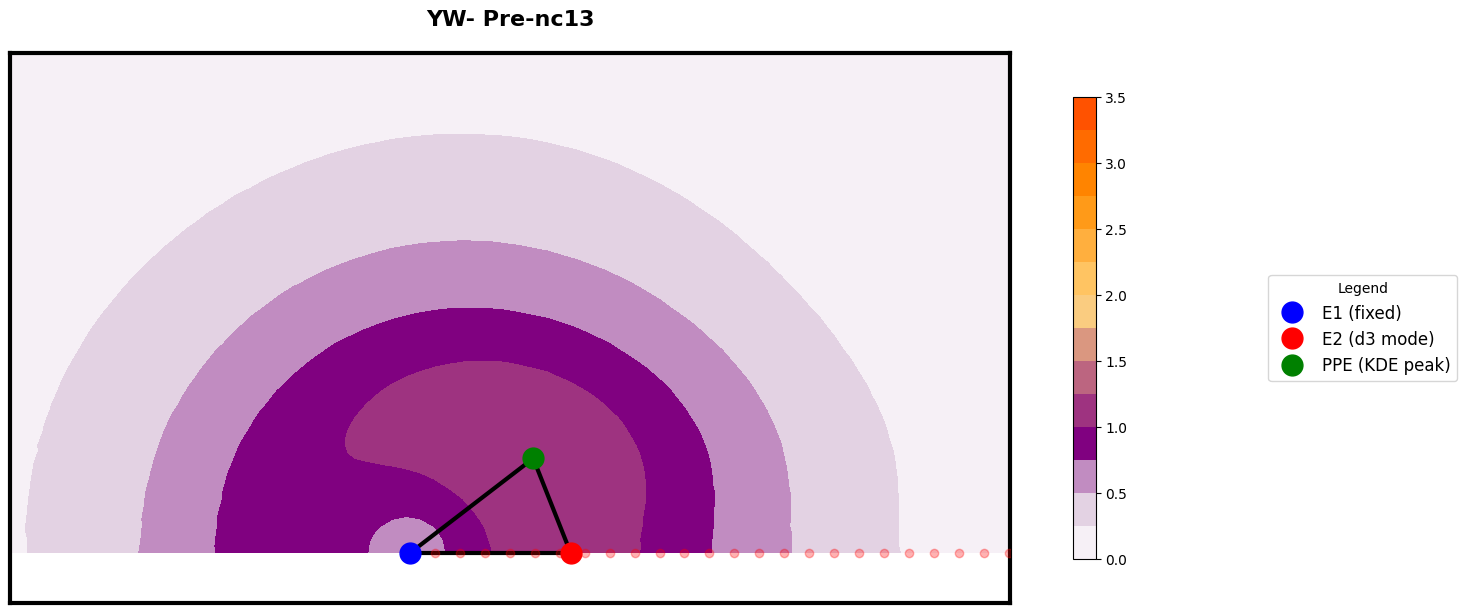

In [124]:
Z_weighted_pre_nc13_yw, X_grid_pre_nc13_yw, Y_grid_pre_nc13_yw, E1_yw_pre_nc13, E2_yw_pre_nc13, PPE_yw_pre_nc13 = plot_contour_stage(kde_results_e2_ppe['Pre-nc13']['x'], kde_results_e1_ppe['Pre-nc13']['x'], 
                   kde_results_e2_ppe['Pre-nc13']['y'], kde_results_e1_ppe['Pre-nc13']['y'], 
                   kde_results_e1_e2['Pre-nc13']['x'], kde_results_e1_e2['Pre-nc13']['y'],
                   title="YW- Pre-nc13", show_legend=True, x_tick_limit=None, num_samples=10, vmin=0, vmax=3.5)

0.9999999999999999
Final normalized Z surface area: 1.00000


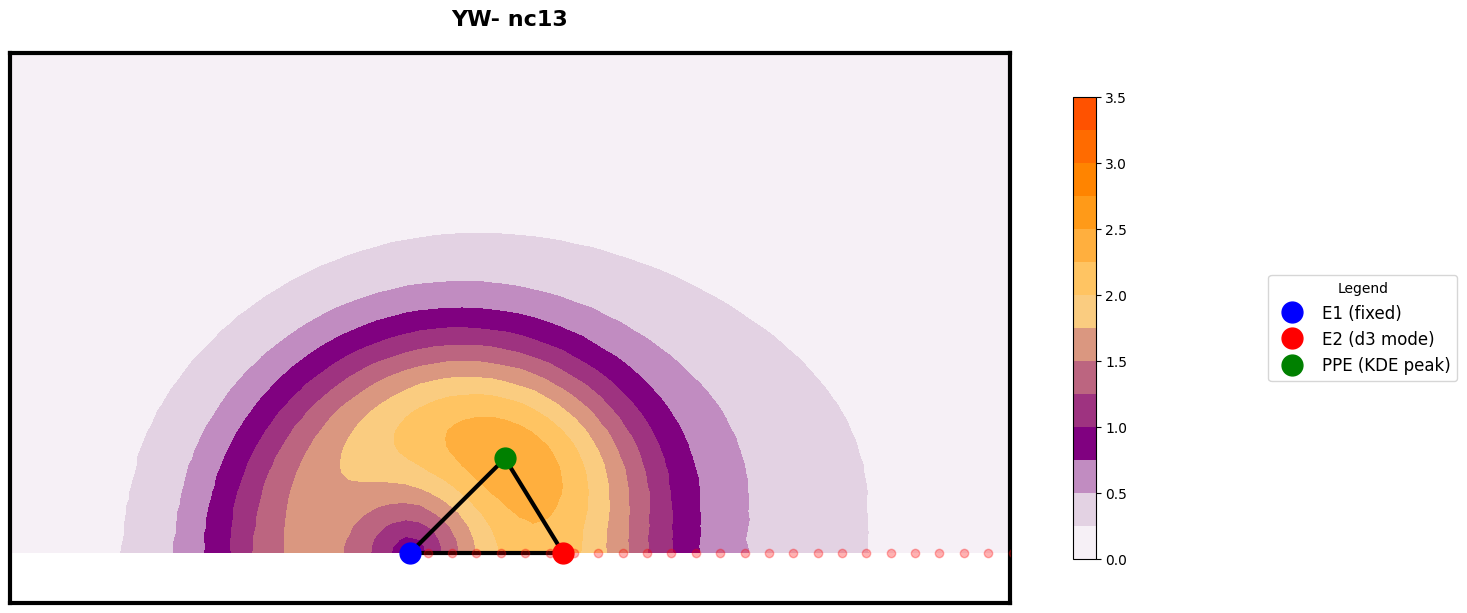

In [125]:
Z_weighted_nc13_yw, X_grid_nc13_yw, Y_grid_nc13_yw, E1_yw_nc13, E2_yw_nc13, PPE_yw_nc13 = plot_contour_stage(kde_results_e2_ppe['nc13']['x'], kde_results_e1_ppe['nc13']['x'], 
                   kde_results_e2_ppe['nc13']['y'], kde_results_e1_ppe['nc13']['y'], 
                   kde_results_e1_e2['nc13']['x'], kde_results_e1_e2['nc13']['y'],
                   title="YW- nc13", show_legend=True, x_tick_limit=None, num_samples=10, vmin=0., vmax=3.5)

/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1372475675.py:21: RuntimeWarning: divide by zero encountered in divide
  x_C = np.where(valid, (d3**2 + D2**2 - D1**2) / (2 * d3), np.nan)


0.9825094040177187
Final normalized Z surface area: 1.00000


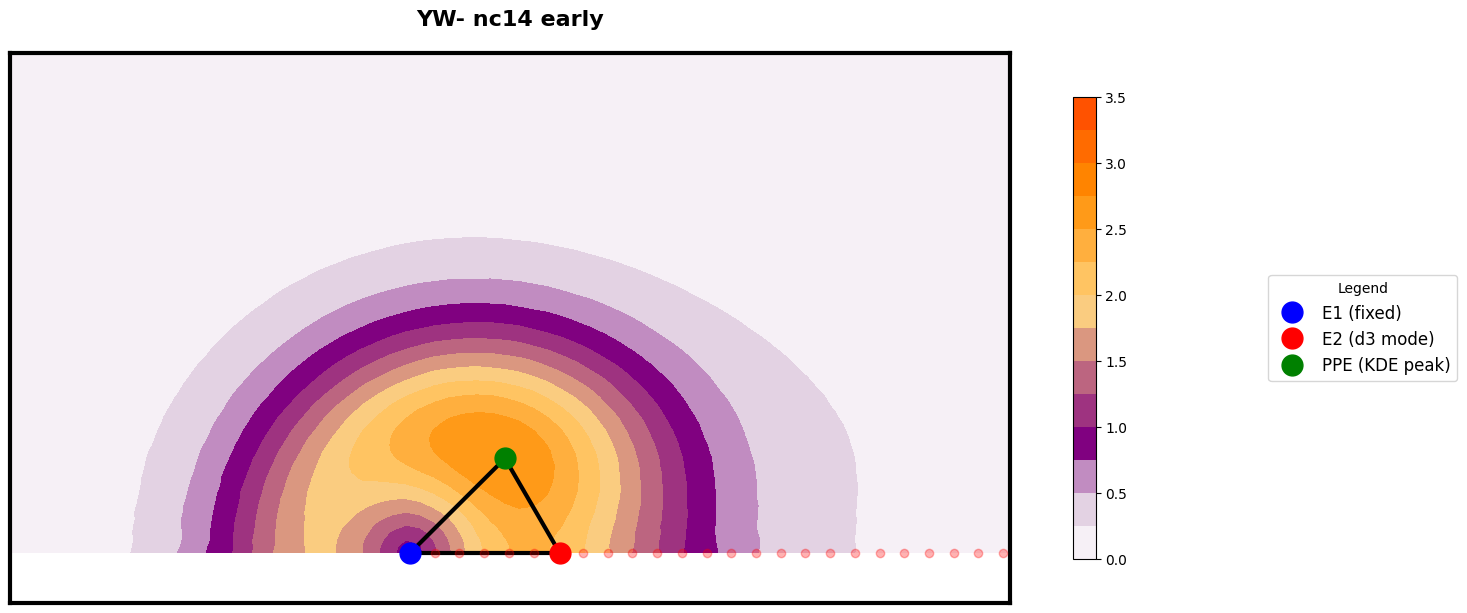

In [126]:
Z_weighted_nc14_early_yw, X_grid_nc14_early_yw, Y_grid_nc14_early_yw, E1_yw_nc14_early, E2_yw_nc14_early, PPE_yw_nc14_early = plot_contour_stage(kde_results_e2_ppe['nc14-early']['x'], kde_results_e1_ppe['nc14-early']['x'], 
                   kde_results_e2_ppe['nc14-early']['y'], kde_results_e1_ppe['nc14-early']['y'], 
                   kde_results_e1_e2['nc14-early']['x'], kde_results_e1_e2['nc14-early']['y'],
                   title="YW- nc14 early", show_legend=True, x_tick_limit=None, num_samples=10, vmin=0, vmax=3.5)

1.0
Final normalized Z surface area: 1.00000


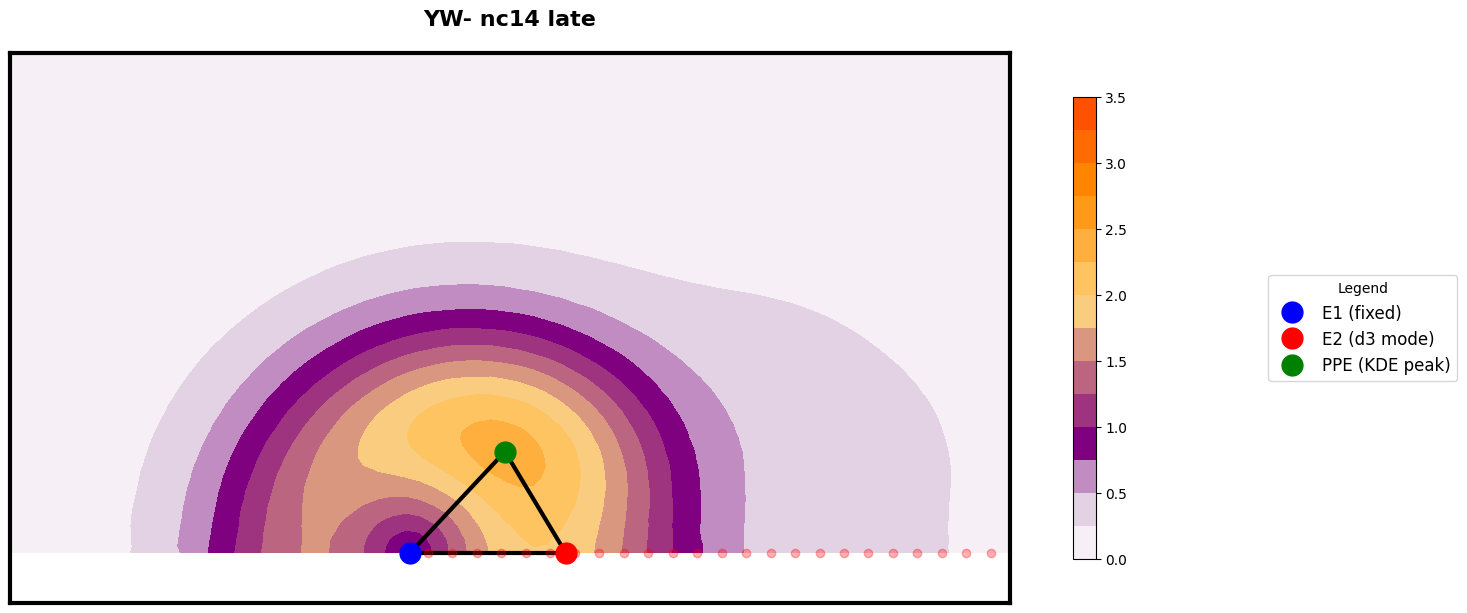

In [127]:
Z_weighted_nc14_late_yw, X_grid_nc14_late_yw, Y_grid_nc14_late_yw,E1_yw_nc14_late, E2_yw_nc14_late, PPE_yw_nc14_late = plot_contour_stage(kde_results_e2_ppe['nc14-late']['x'], kde_results_e1_ppe['nc14-late']['x'], 
                   kde_results_e2_ppe['nc14-late']['y'], kde_results_e1_ppe['nc14-late']['y'], 
                   kde_results_e1_e2['nc14-late']['x'], kde_results_e1_e2['nc14-late']['y'],
                   title="YW- nc14 late", show_legend=True, x_tick_limit=None, num_samples=10, vmin=0, vmax=3.5)

1.0000000000000002
Final normalized Z surface area: 1.00000


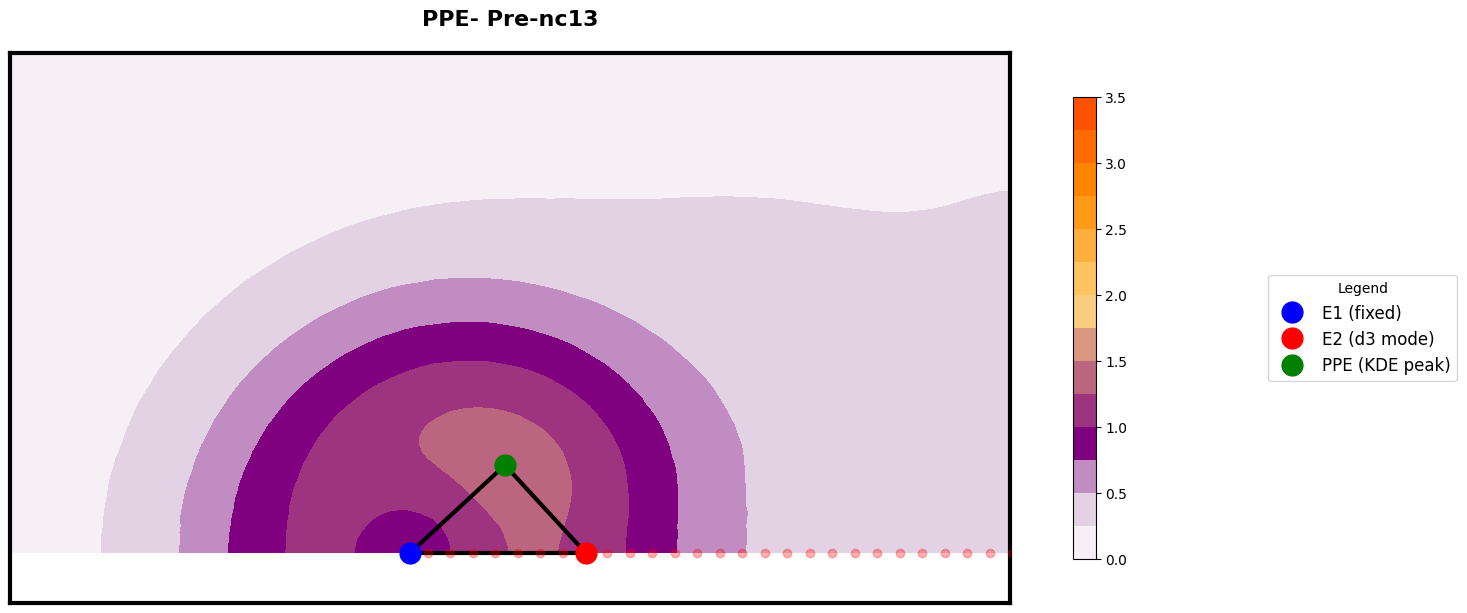

In [128]:
Z_weighted_pre_nc13_ppe, X_grid_pre_nc13_ppe, Y_grid_pre_nc13_ppe, E1_ppe_pre_nc13, E2_ppe_pre_nc13, PPE_ppe_pre_nc13 = plot_contour_stage(ppe_kde_results_e2_ppe['Pre-nc13']['x'], ppe_kde_results_e1_ppe['Pre-nc13']['x'], 
                   ppe_kde_results_e2_ppe['Pre-nc13']['y'], ppe_kde_results_e1_ppe['Pre-nc13']['y'], 
                   ppe_kde_results_e1_e2['Pre-nc13']['x'], ppe_kde_results_e1_e2['Pre-nc13']['y'],
                   title="PPE- Pre-nc13", show_legend=True, x_tick_limit=None, num_samples=10, vmin=0, vmax=3.5)

/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1372475675.py:21: RuntimeWarning: divide by zero encountered in divide
  x_C = np.where(valid, (d3**2 + D2**2 - D1**2) / (2 * d3), np.nan)
/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1372475675.py:21: RuntimeWarning: invalid value encountered in divide
  x_C = np.where(valid, (d3**2 + D2**2 - D1**2) / (2 * d3), np.nan)


0.9819970176204637
Final normalized Z surface area: 1.00000


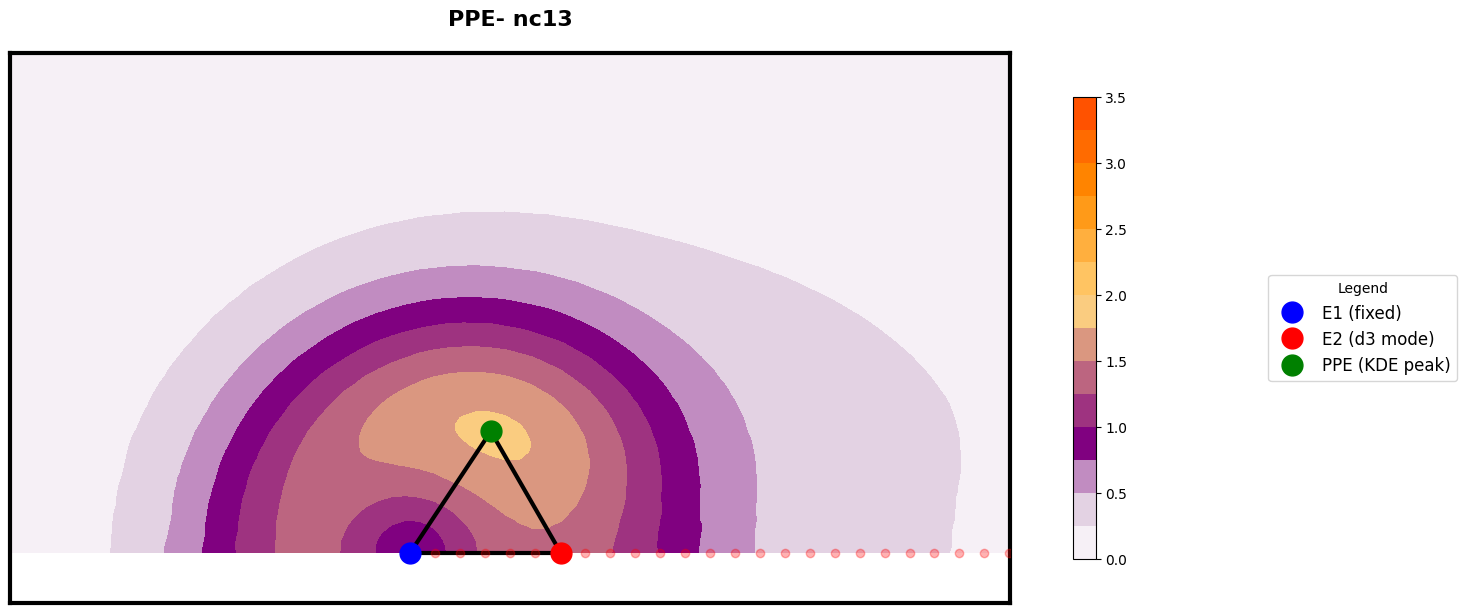

In [129]:
Z_weighted_nc13_ppe, X_grid_nc13_ppe, Y_grid_nc13_ppe, E1_ppe_nc13, E2_ppe_nc13, PPE_ppe_nc13 = plot_contour_stage(ppe_kde_results_e2_ppe['nc13']['x'], ppe_kde_results_e1_ppe['nc13']['x'], 
                   ppe_kde_results_e2_ppe['nc13']['y'], ppe_kde_results_e1_ppe['nc13']['y'], 
                   ppe_kde_results_e1_e2['nc13']['x'], ppe_kde_results_e1_e2['nc13']['y'],
                   title="PPE- nc13", show_legend=True, x_tick_limit=None, num_samples=10, vmin=0, vmax=3.5)

/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1372475675.py:21: RuntimeWarning: divide by zero encountered in divide
  x_C = np.where(valid, (d3**2 + D2**2 - D1**2) / (2 * d3), np.nan)


0.9790052864106236
Final normalized Z surface area: 1.00000


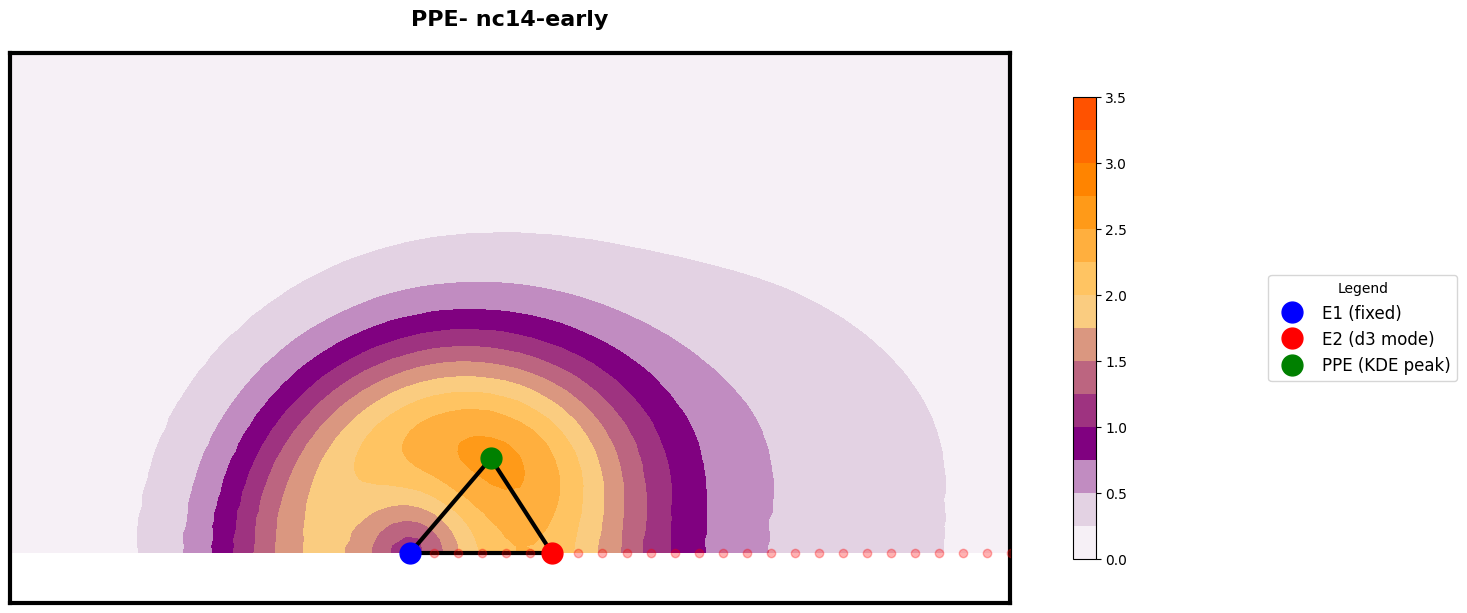

In [130]:
Z_weighted_nc14_early_ppe, X_grid_nc14_early_ppe, Y_grid_nc14_early_ppe, E1_ppe_nc14_early, E2_ppe_nc14_early, PPE_ppe_nc14_early = plot_contour_stage(ppe_kde_results_e2_ppe['nc14-early']['x'], ppe_kde_results_e1_ppe['nc14-early']['x'], 
                   ppe_kde_results_e2_ppe['nc14-early']['y'], ppe_kde_results_e1_ppe['nc14-early']['y'], 
                   ppe_kde_results_e1_e2['nc14-early']['x'], ppe_kde_results_e1_e2['nc14-early']['y'],
                   title="PPE- nc14-early", show_legend=True, x_tick_limit=None, num_samples=10, vmin=0, vmax=3.5)

/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1372475675.py:21: RuntimeWarning: divide by zero encountered in divide
  x_C = np.where(valid, (d3**2 + D2**2 - D1**2) / (2 * d3), np.nan)
/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1372475675.py:21: RuntimeWarning: invalid value encountered in divide
  x_C = np.where(valid, (d3**2 + D2**2 - D1**2) / (2 * d3), np.nan)


0.9777054691234051
Final normalized Z surface area: 1.00000


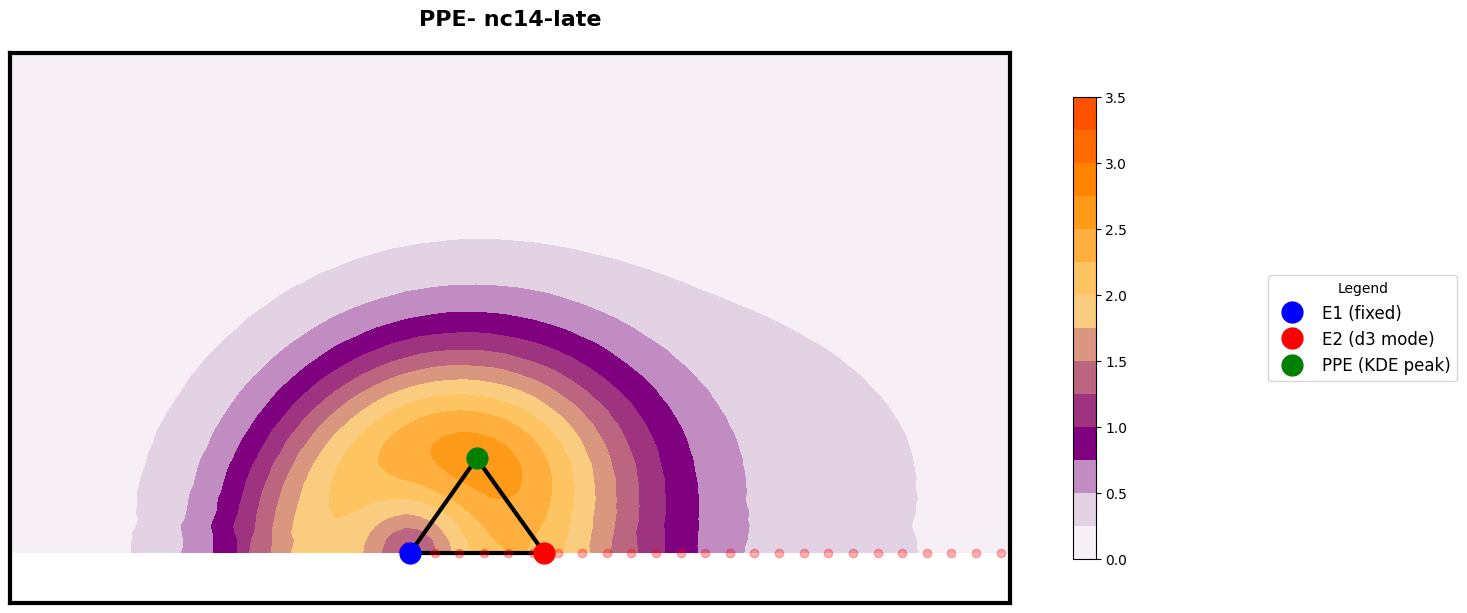

In [131]:
Z_weighted_nc14_late_ppe, X_grid_nc14_late_ppe, Y_grid_nc14_late_ppe, E1_ppe_nc14_late, E2_ppe_nc14_late, PPE_ppe_nc14_late = plot_contour_stage(ppe_kde_results_e2_ppe['nc14-late']['x'], ppe_kde_results_e1_ppe['nc14-late']['x'], 
                   ppe_kde_results_e2_ppe['nc14-late']['y'], ppe_kde_results_e1_ppe['nc14-late']['y'], 
                   ppe_kde_results_e1_e2['nc14-late']['x'], ppe_kde_results_e1_e2['nc14-late']['y'],
                   title="PPE- nc14-late", show_legend=True, x_tick_limit=None, num_samples=10, vmin=0, vmax=3.5)

0.9999999999999999
Final normalized Z surface area: 1.00000


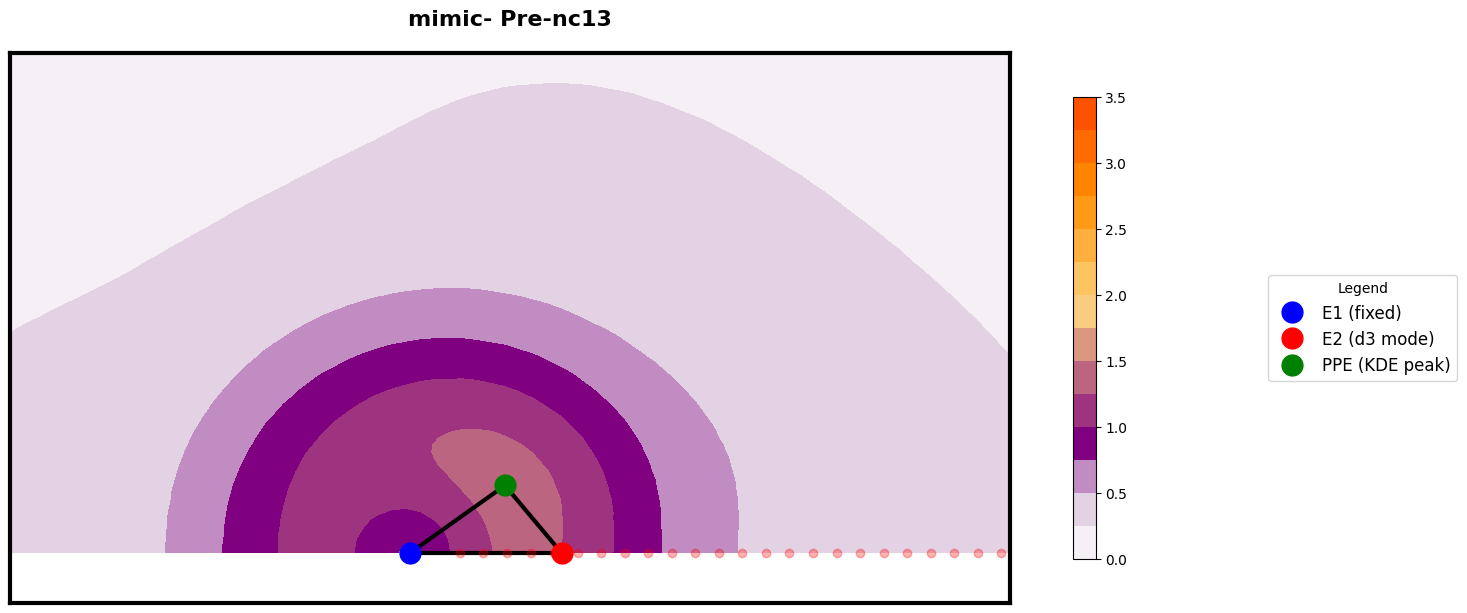

In [132]:
Z_weighted_pre_nc13_mimic, X_grid_pre_nc13_mimic, Y_grid_pre_nc13_mimic, E1_mimic_pre_nc13, E2_mimic_pre_nc13, PPE_mimic_pre_nc13 = plot_contour_stage(mimic_kde_results_e2_ppe['Pre-nc13']['x'], mimic_kde_results_e1_ppe['Pre-nc13']['x'], 
                   mimic_kde_results_e2_ppe['Pre-nc13']['y'], mimic_kde_results_e1_ppe['Pre-nc13']['y'], 
                   mimic_kde_results_e1_e2['Pre-nc13']['x'], mimic_kde_results_e1_e2['Pre-nc13']['y'],
                   title="mimic- Pre-nc13", show_legend=True, x_tick_limit=None, num_samples=10, vmin=0, vmax=3.5)

/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1372475675.py:21: RuntimeWarning: divide by zero encountered in divide
  x_C = np.where(valid, (d3**2 + D2**2 - D1**2) / (2 * d3), np.nan)


0.9785164495295005
Final normalized Z surface area: 1.00000


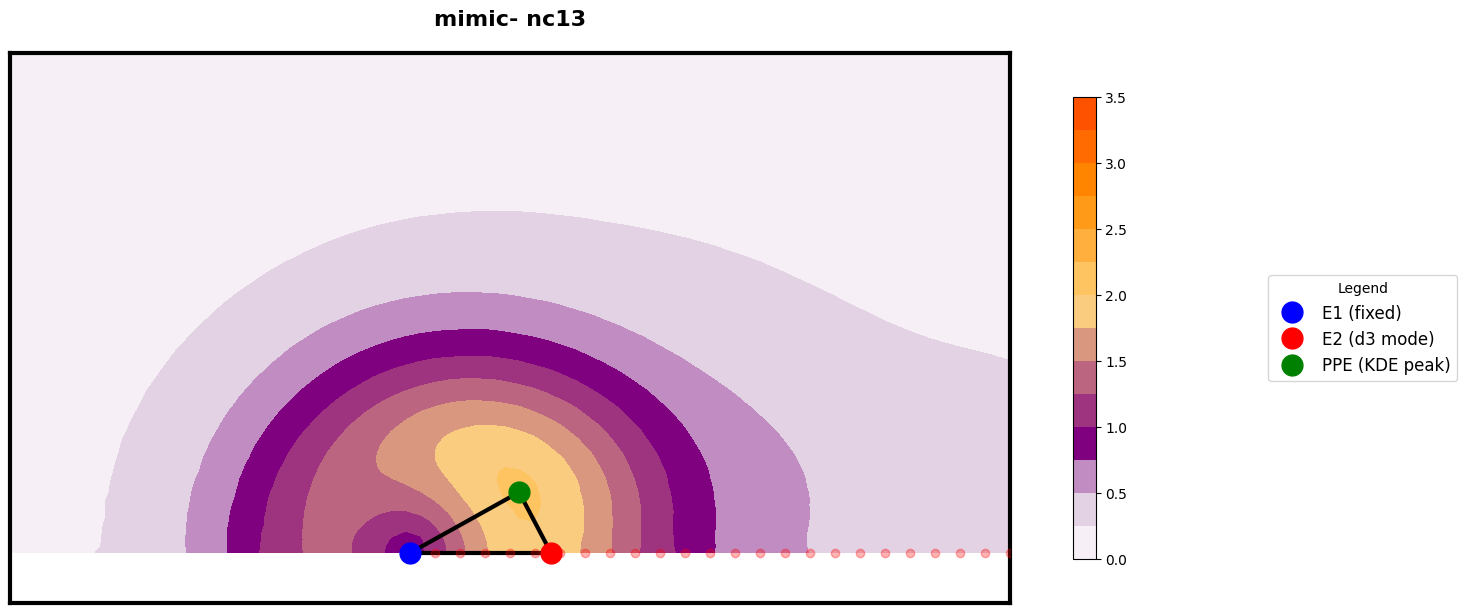

In [133]:
Z_weighted_nc13_mimic, X_grid_nc13_mimic, Y_grid_nc13_mimic, E1_mimic_nc13, E2_mimic_nc13, PPE_mimic_nc13 = plot_contour_stage(mimic_kde_results_e2_ppe['nc13']['x'], mimic_kde_results_e1_ppe['nc13']['x'], 
                   mimic_kde_results_e2_ppe['nc13']['y'], mimic_kde_results_e1_ppe['nc13']['y'], 
                   mimic_kde_results_e1_e2['nc13']['x'], mimic_kde_results_e1_e2['nc13']['y'],
                   title="mimic- nc13", show_legend=True, x_tick_limit=None, num_samples=10, vmin=0, vmax=3.5)

1.0000000000000002
Final normalized Z surface area: 1.00000


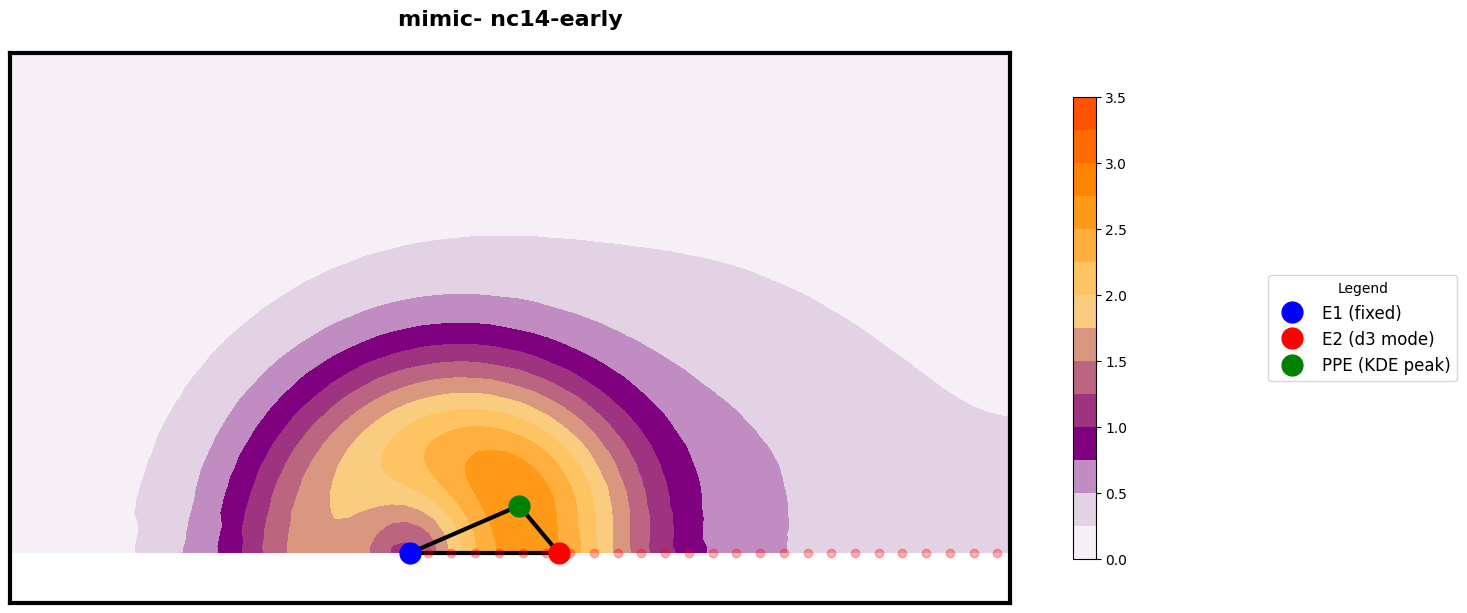

In [134]:
Z_weighted_nc14_early_mimic, X_grid_nc14_early_mimic, Y_grid_nc14_early_mimic, E1_mimic_nc14_early, E2_mimic_nc14_early, PPE_mimic_nc14_early = plot_contour_stage(mimic_kde_results_e2_ppe['nc14-early']['x'], mimic_kde_results_e1_ppe['nc14-early']['x'], 
                   mimic_kde_results_e2_ppe['nc14-early']['y'], mimic_kde_results_e1_ppe['nc14-early']['y'], 
                   mimic_kde_results_e1_e2['nc14-early']['x'], mimic_kde_results_e1_e2['nc14-early']['y'],
                   title="mimic- nc14-early", show_legend=True, x_tick_limit=None, num_samples=10, vmin=0, vmax=3.5)

/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1372475675.py:21: RuntimeWarning: divide by zero encountered in divide
  x_C = np.where(valid, (d3**2 + D2**2 - D1**2) / (2 * d3), np.nan)
/var/folders/6g/g2plc5bd3jv_sqpbk23jqwm40000gn/T/ipykernel_2895/1372475675.py:21: RuntimeWarning: invalid value encountered in divide
  x_C = np.where(valid, (d3**2 + D2**2 - D1**2) / (2 * d3), np.nan)


0.9830676605265267
Final normalized Z surface area: 1.00000


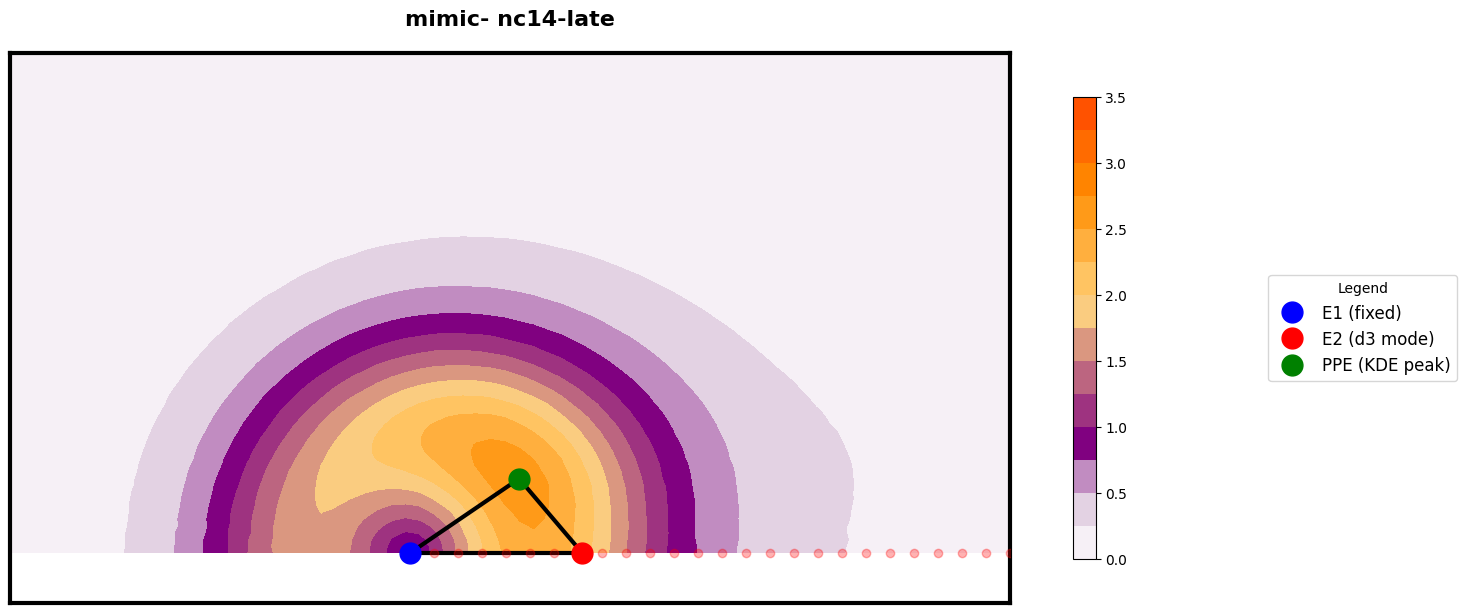

In [135]:
Z_weighted_nc14_late_mimic, X_grid_nc14_late_mimic, Y_grid_nc14_late_mimic, E1_mimic_nc14_late, E2_mimic_nc14_late, PPE_mimic_nc14_late = plot_contour_stage(mimic_kde_results_e2_ppe['nc14-late']['x'], mimic_kde_results_e1_ppe['nc14-late']['x'], 
                   mimic_kde_results_e2_ppe['nc14-late']['y'], mimic_kde_results_e1_ppe['nc14-late']['y'], 
                   mimic_kde_results_e1_e2['nc14-late']['x'], mimic_kde_results_e1_e2['nc14-late']['y'],
                   title="mimic- nc14-late", show_legend=True, x_tick_limit=None, num_samples=10, vmin=0, vmax=3.5)

# Subtraction contouring

In [136]:
# Re-import necessary libraries after kernel reset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import LinearNDInterpolator

# Re-define the function after kernel reset
def plot_difference_contour(Z_weight_s1,X_grid_s1,Y_grid_s1,
                            Z_weight_s2,X_grid_s2,Y_grid_s2, 
                            E1_yw, E2_yw, PPE_yw,
                            E1_ppe, E2_ppe, PPE_ppe,
                            title="Difference: Z1-Z2"):

    # Subtract and plot the difference
    Z_diff = Z_weight_s1 - Z_weight_s2

    fig, ax = plt.subplots(figsize=(20, 10))
    base = plt.get_cmap("coolwarm")
    # Use more samples on the tails, fewer near the center
    custom_positions = np.concatenate([
        np.linspace(0, 0.2, 10, endpoint=False),
        np.linspace(0.2, 0.8, 10, endpoint=False),
        np.linspace(0.8, 1.0, 10)
    ])
    discrete_cmap = ListedColormap(base(custom_positions))
    contour = ax.contourf(
        X_grid_s1, Y_grid_s1, Z_diff,
        levels=20,
        cmap=discrete_cmap,
        vmin=-np.max(np.abs(Z_diff)),
        vmax=np.max(np.abs(Z_diff))
    )
    # Add colorbar and shrink it
    cbar = plt.colorbar(contour, ax=ax, label="Z1-Z2", shrink=0.6)
    # --- YW triangle ---
    ax.plot([E1_yw[0], E2_yw[0]], [E1_yw[1], E2_yw[1]], 'k-',linewidth=3)         # base
    ax.plot([E1_yw[0], PPE_yw[0]], [E1_yw[1], PPE_yw[1]], 'k-',linewidth=3)       # E1–PPE
    ax.plot([E2_yw[0], PPE_yw[0]], [E2_yw[1], PPE_yw[1]], 'k-',linewidth=3)       # E2–PPE

    ax.plot(*E1_yw, 'o', color='blue', markersize=20, label='YW E1')
    ax.plot(*E2_yw, 'o', color='red', markersize=20, label='YW E2 (d3 mode)')
    ax.plot(*PPE_yw, 'o', color='green', markersize=20, label='YW PPE (KDE peak)')

    # --- PPE triangle ---
    ax.plot([E1_ppe[0], E2_ppe[0]], [E1_ppe[1], E2_ppe[1]], 'k--', linewidth=3)  # base
    ax.plot([E1_ppe[0], PPE_ppe[0]], [E1_ppe[1], PPE_ppe[1]], 'k--', linewidth=3)  # E1–PPE
    ax.plot([E2_ppe[0], PPE_ppe[0]], [E2_ppe[1], PPE_ppe[1]], 'k--', linewidth=3)  # E2–PPE

    ax.plot(*E1_ppe, 'o', color='blue', markersize=20, alpha=0.6, label='PPE E1')
    ax.plot(*E2_ppe, 'o', color='hotpink', markersize=20, alpha=0.6, label='PPE E2 (d3 mode)')
    ax.plot(*PPE_ppe, 'o', color='lime', markersize=20, alpha=0.6, label='PPE PPE (KDE peak)')

    # Formatting
    ax.set_xlim(-0.8, 1.2)
    ax.set_ylim(-0.1, 1.05)  # Start y from -0.1 for visibility
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    ax.grid(False)

    plt.tight_layout()
    plt.show()

## YW vs PPE

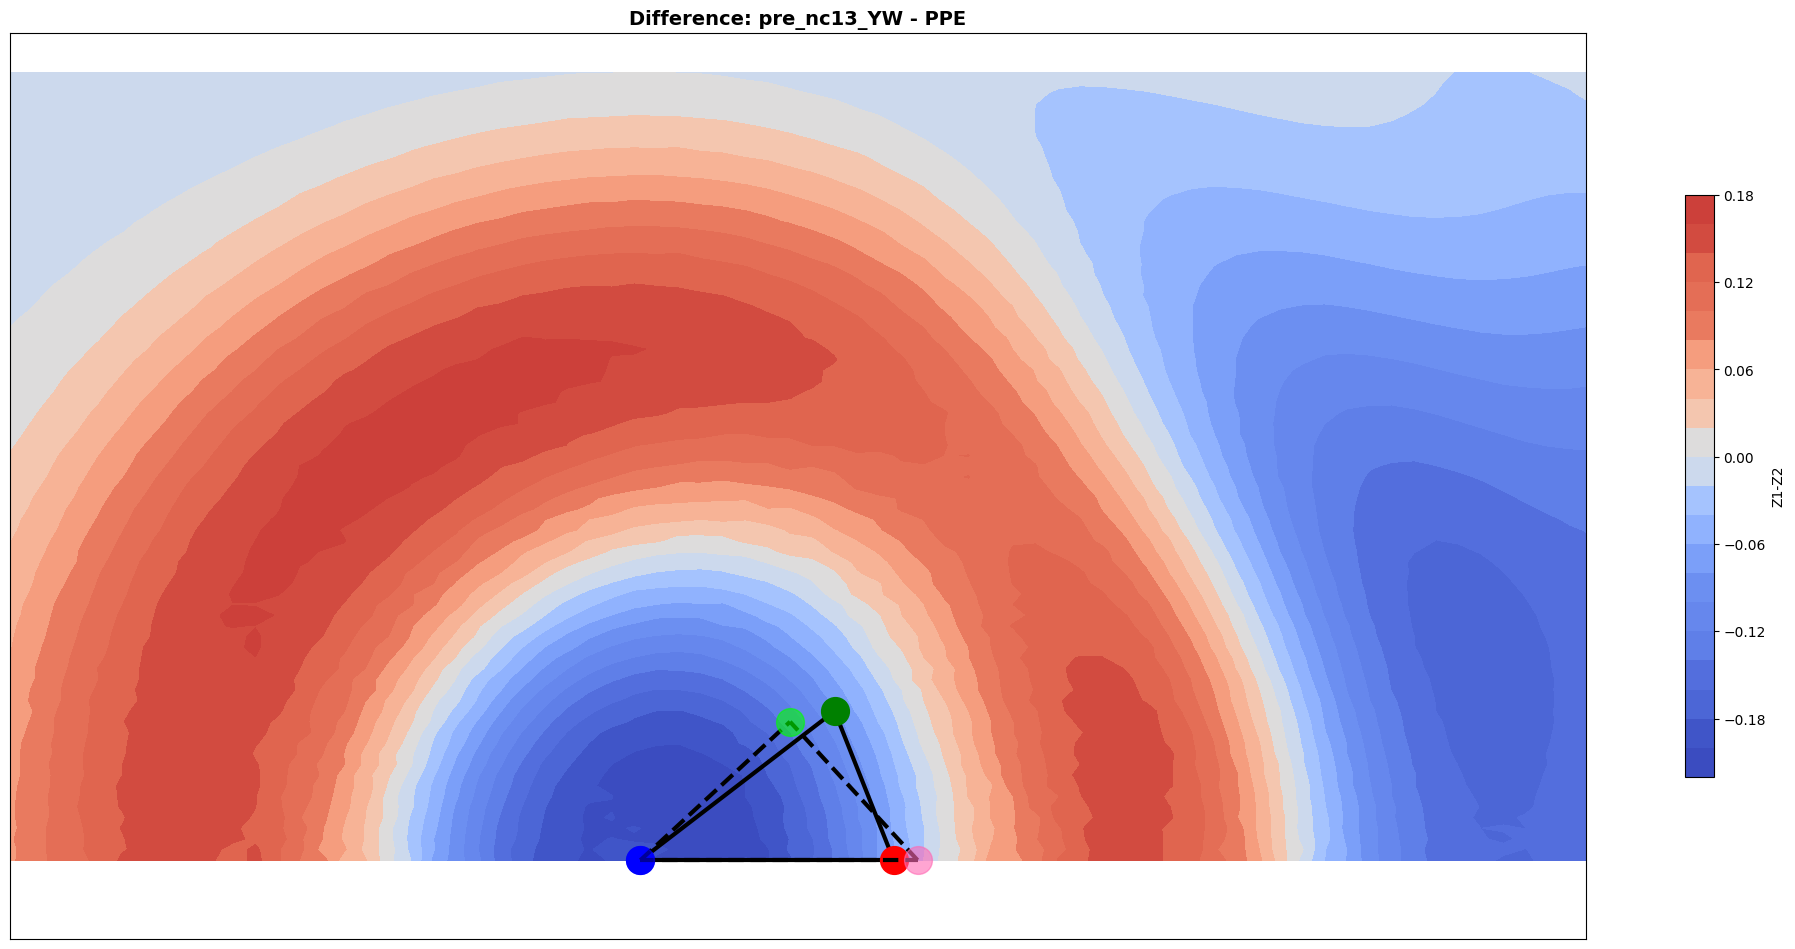

In [137]:
plot_difference_contour(Z_weighted_pre_nc13_yw, X_grid_pre_nc13_yw,Y_grid_pre_nc13_yw,
                        Z_weighted_pre_nc13_ppe, X_grid_nc13_ppe,Y_grid_pre_nc13_ppe, 
                        E1_yw_pre_nc13, E2_yw_pre_nc13, PPE_yw_pre_nc13,
                        E1_ppe_pre_nc13, E2_ppe_pre_nc13, PPE_ppe_pre_nc13,
                        title="Difference: pre_nc13_YW - PPE")

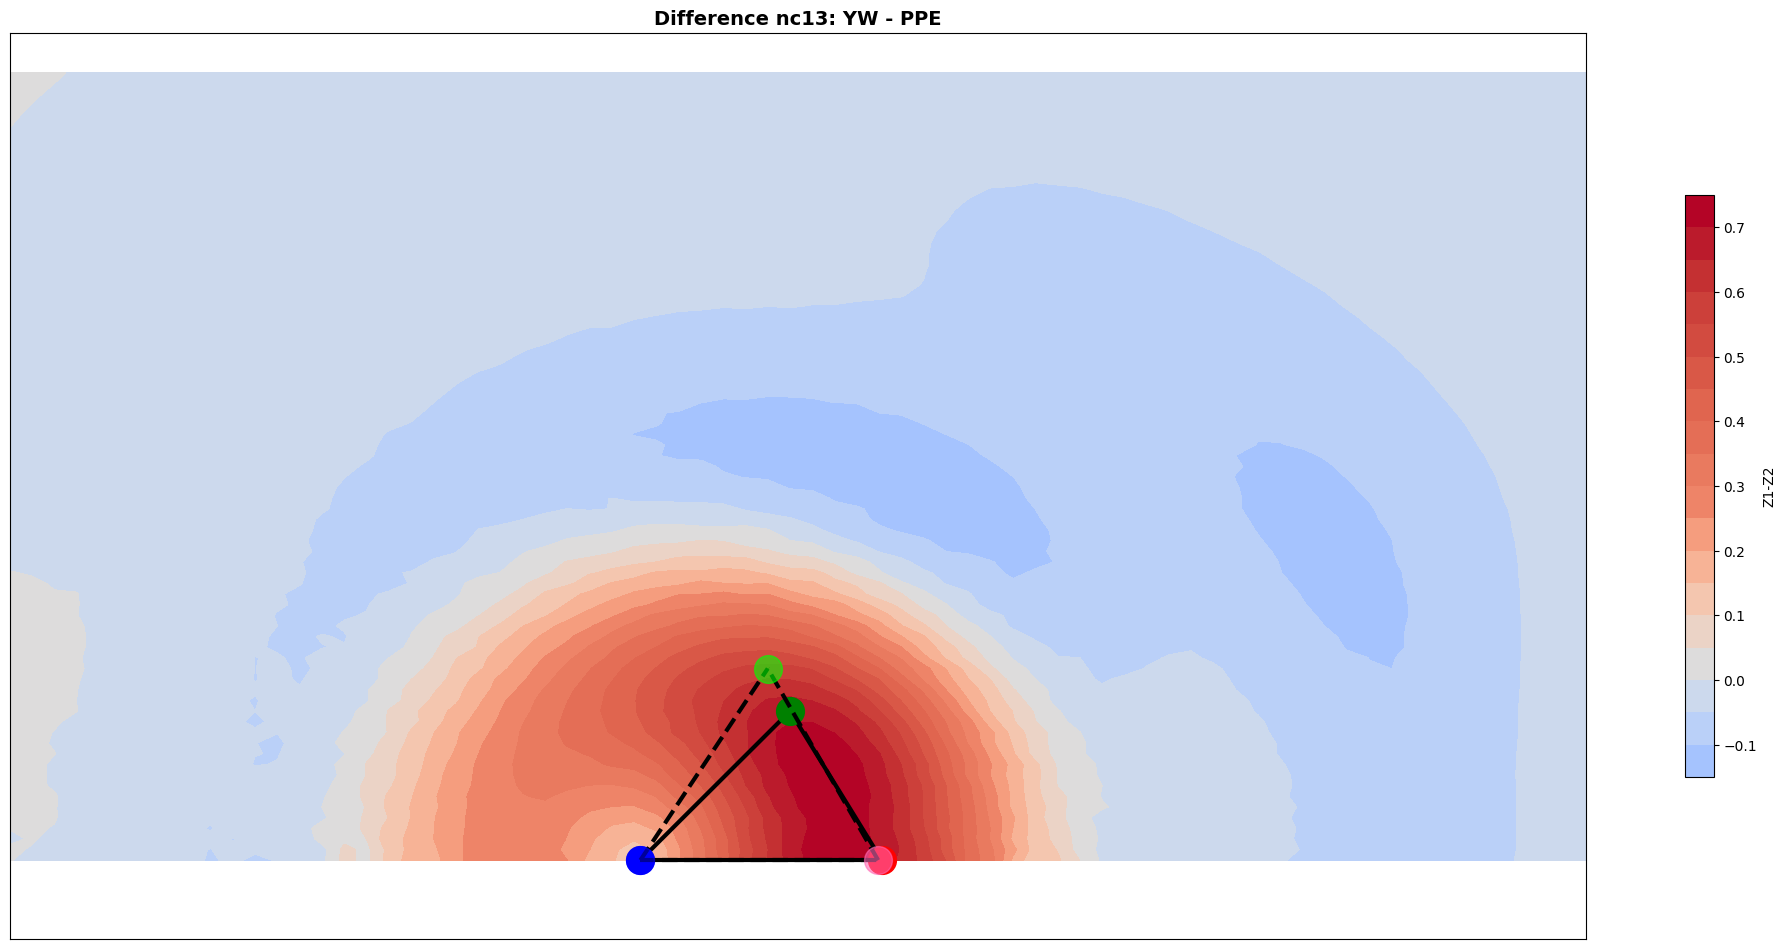

In [138]:
plot_difference_contour(Z_weighted_nc13_yw, X_grid_nc13_yw,Y_grid_nc13_yw,
                        Z_weighted_nc13_ppe, X_grid_nc13_ppe,Y_grid_nc13_ppe, 
                        E1_yw_nc13, E2_yw_nc13, PPE_yw_nc13,
                        E1_ppe_nc13, E2_ppe_nc13, PPE_ppe_nc13,
                        title="Difference nc13: YW - PPE")

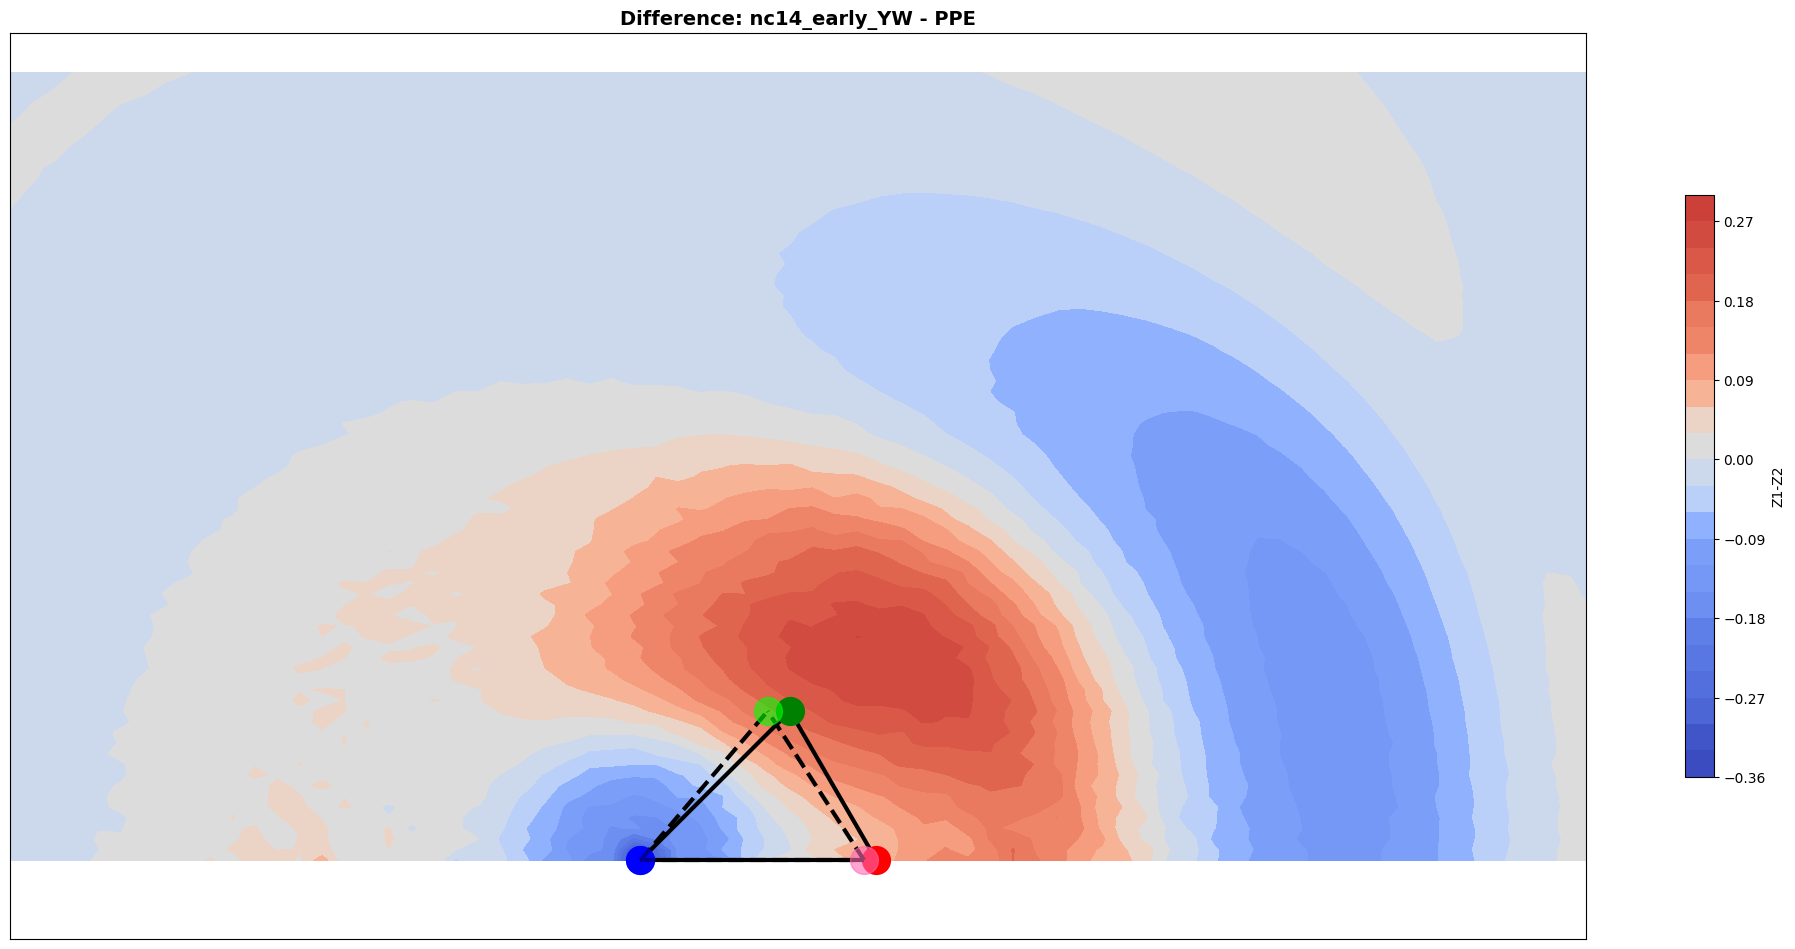

In [139]:
plot_difference_contour(Z_weighted_nc14_early_yw, X_grid_nc14_early_yw,Y_grid_nc14_early_yw,
                        Z_weighted_nc14_early_ppe, X_grid_nc14_early_yw,Y_grid_nc14_early_ppe,
                        E1_yw_nc14_early, E2_yw_nc14_early, PPE_yw_nc14_early,
                        E1_ppe_nc14_early, E2_ppe_nc14_early, PPE_ppe_nc14_early,
                        title="Difference: nc14_early_YW - PPE")

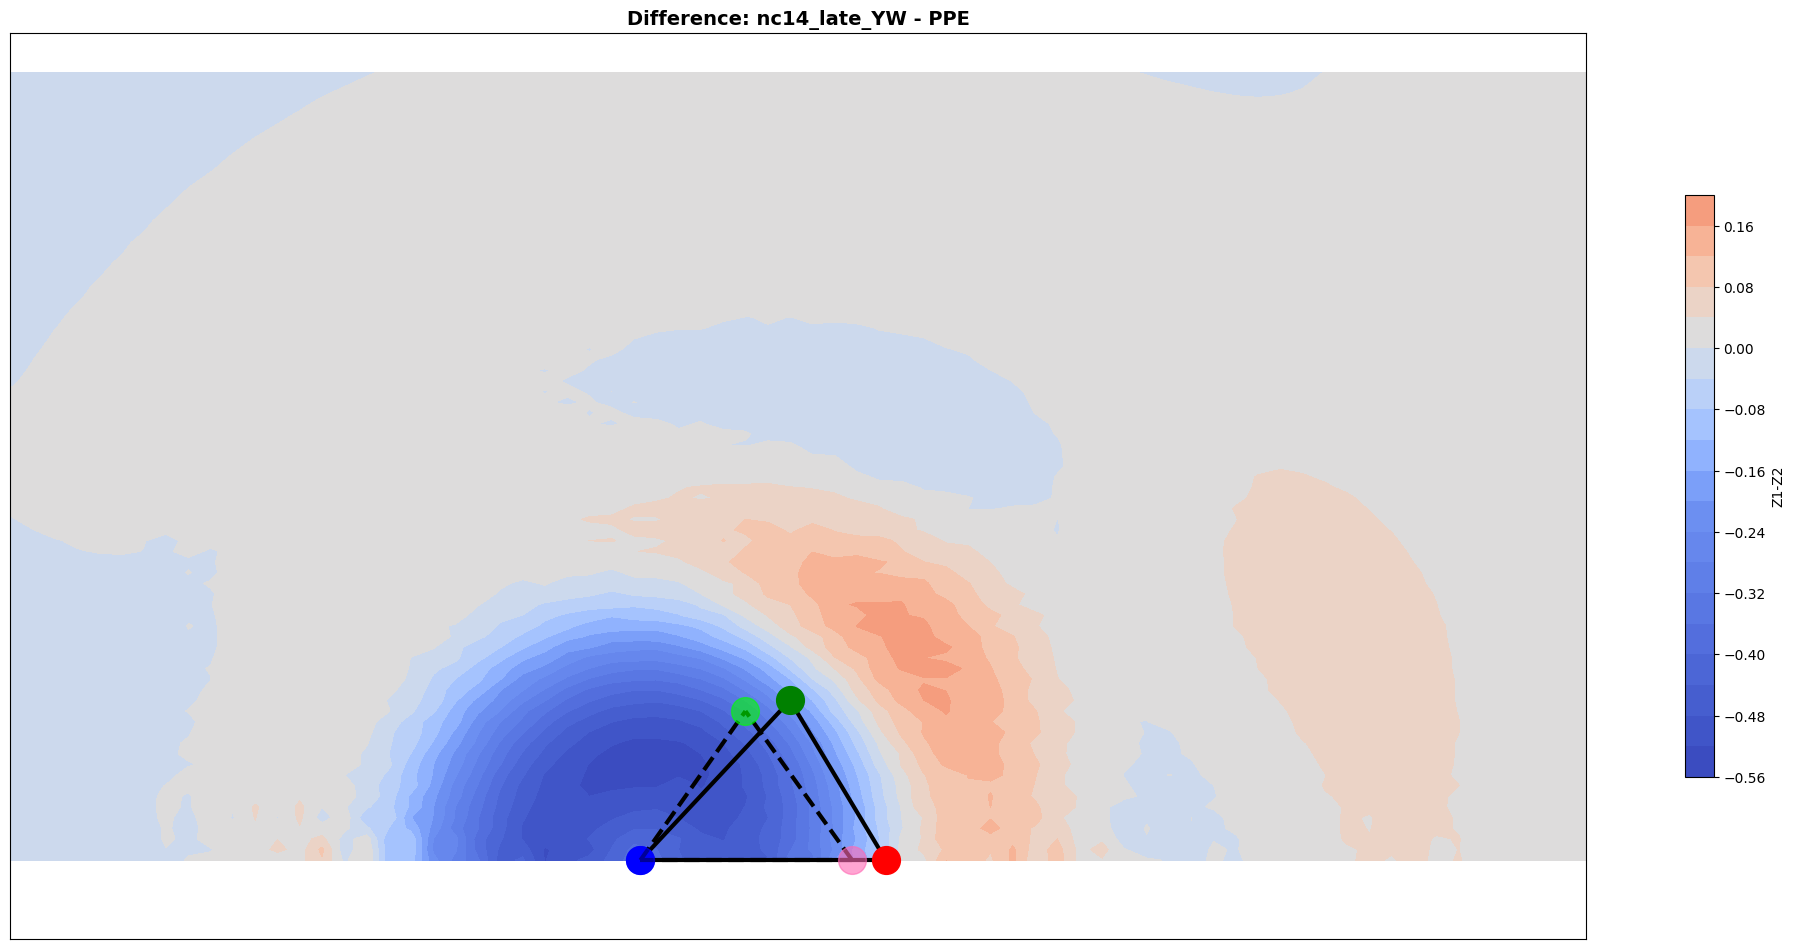

In [140]:
plot_difference_contour(Z_weighted_nc14_late_yw, X_grid_nc14_late_yw,Y_grid_nc14_late_yw,
                        Z_weighted_nc14_late_ppe, X_grid_nc14_late_yw,Y_grid_nc14_late_ppe,
                        E1_yw_nc14_late, E2_yw_nc14_late, PPE_yw_nc14_late,
                        E1_ppe_nc14_late, E2_ppe_nc14_late, PPE_ppe_nc14_late,
                        title="Difference: nc14_late_YW - PPE")

## Contour difference YW pre-nc13 vs nc13 late: nc13 - pre-nc13

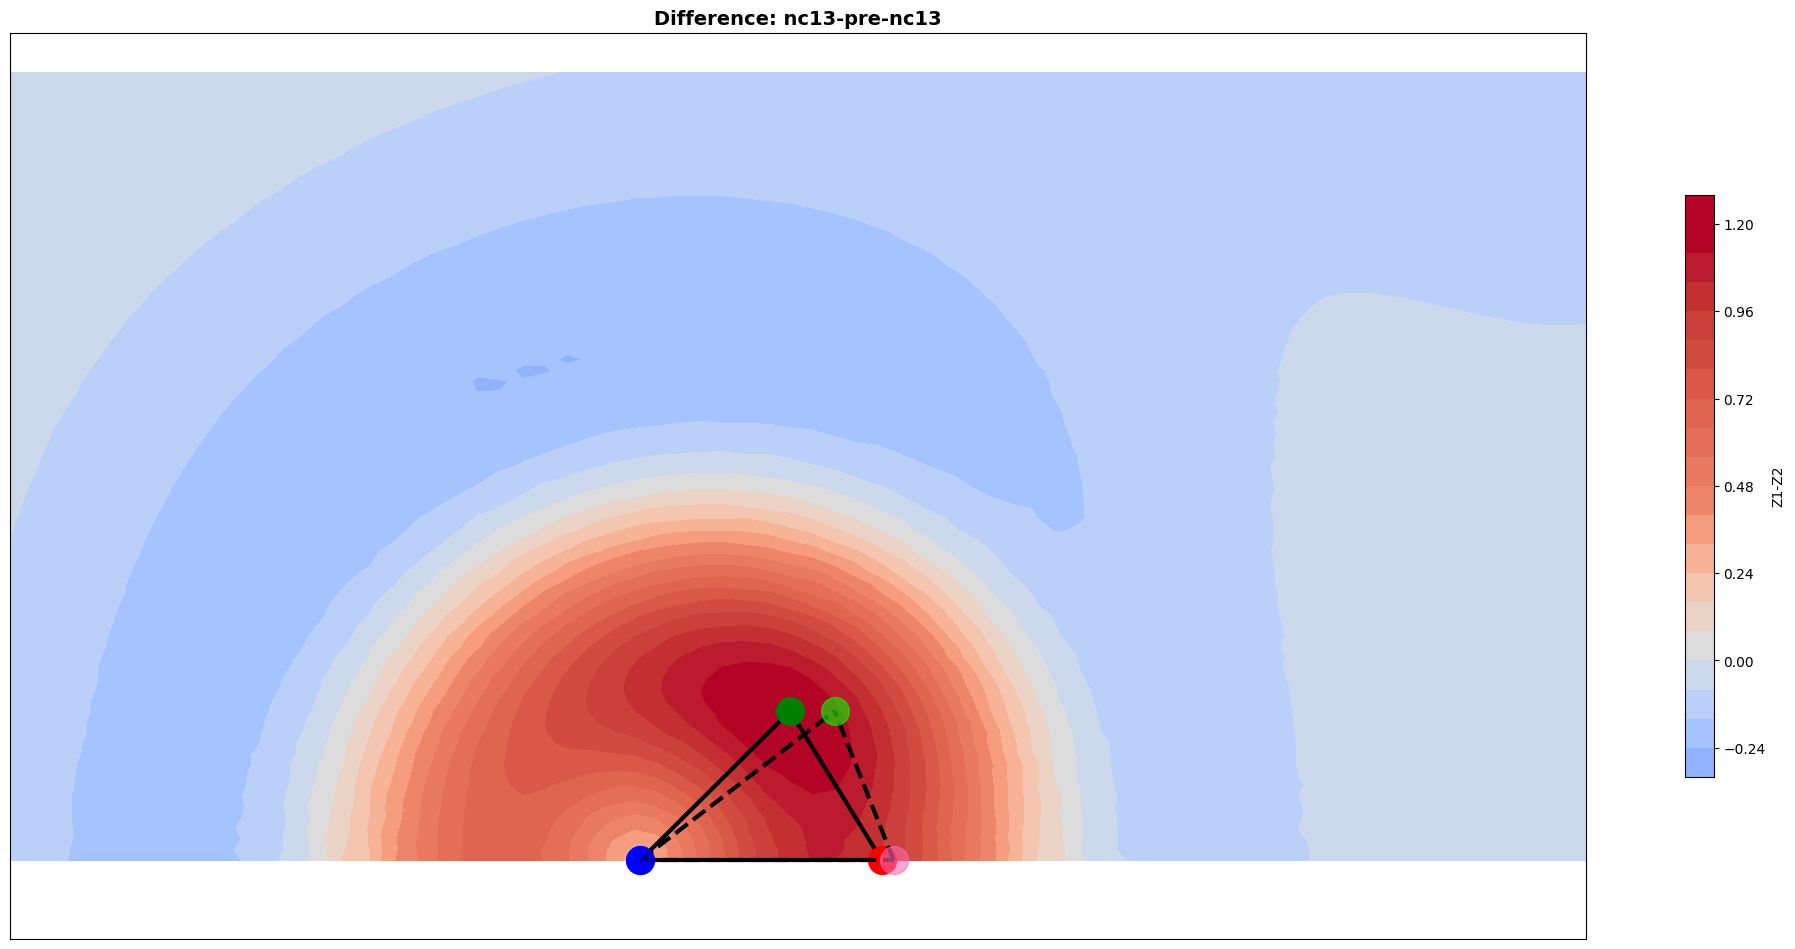

In [141]:
plot_difference_contour(Z_weighted_nc13_yw, X_grid_nc13_yw,Y_grid_nc13_yw,
                        Z_weighted_pre_nc13_yw, X_grid_pre_nc13_yw,Y_grid_pre_nc13_yw,
                        E1_yw_nc13, E2_yw_nc13, PPE_yw_nc13,
                        E1_yw_pre_nc13, E2_yw_pre_nc13, PPE_yw_pre_nc13,
                        title="Difference: nc13-pre-nc13")

## Contour difference YW nc13 vs nc14 late: nc14 late - nc13

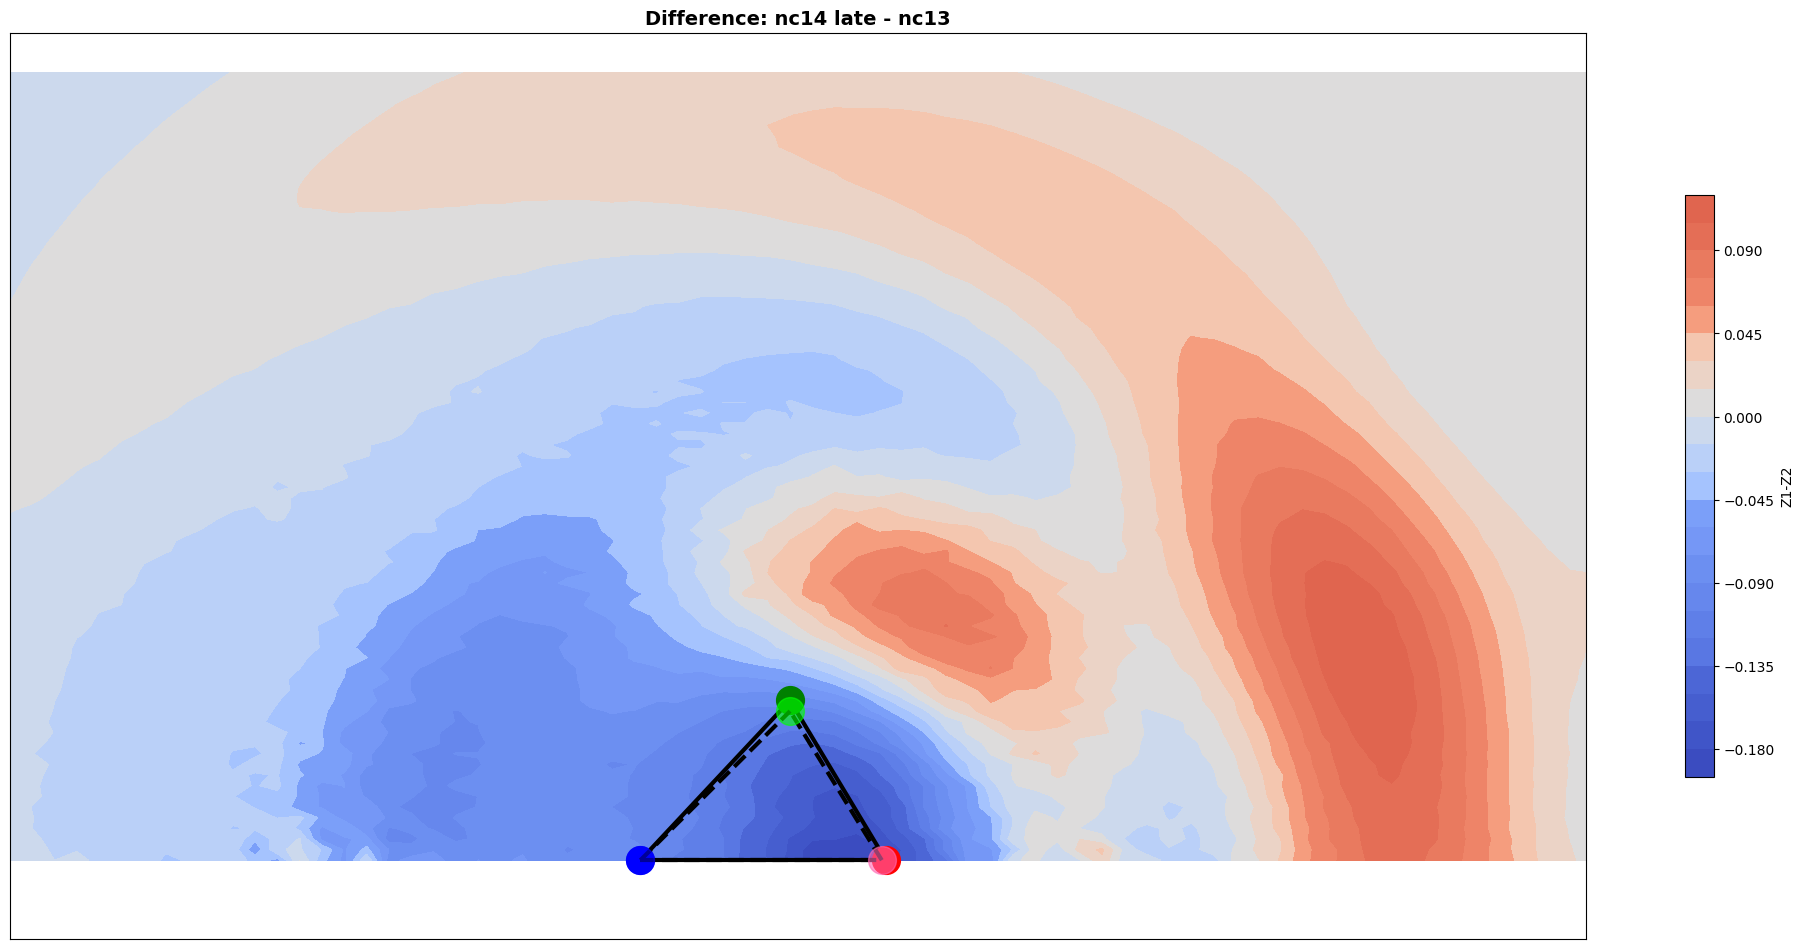

In [142]:
plot_difference_contour(Z_weighted_nc14_late_yw, X_grid_nc14_late_yw,Y_grid_nc14_late_yw, 
                        Z_weighted_nc13_yw, X_grid_nc13_yw,Y_grid_nc13_yw,
                        E1_yw_nc14_late, E2_yw_nc14_late, PPE_yw_nc14_late,
                        E1_yw_nc13, E2_yw_nc13, PPE_yw_nc13,
                        title="Difference: nc14 late - nc13")

## Contour difference PPE nc13 vs pre-nc13: nc13 - pre nc13

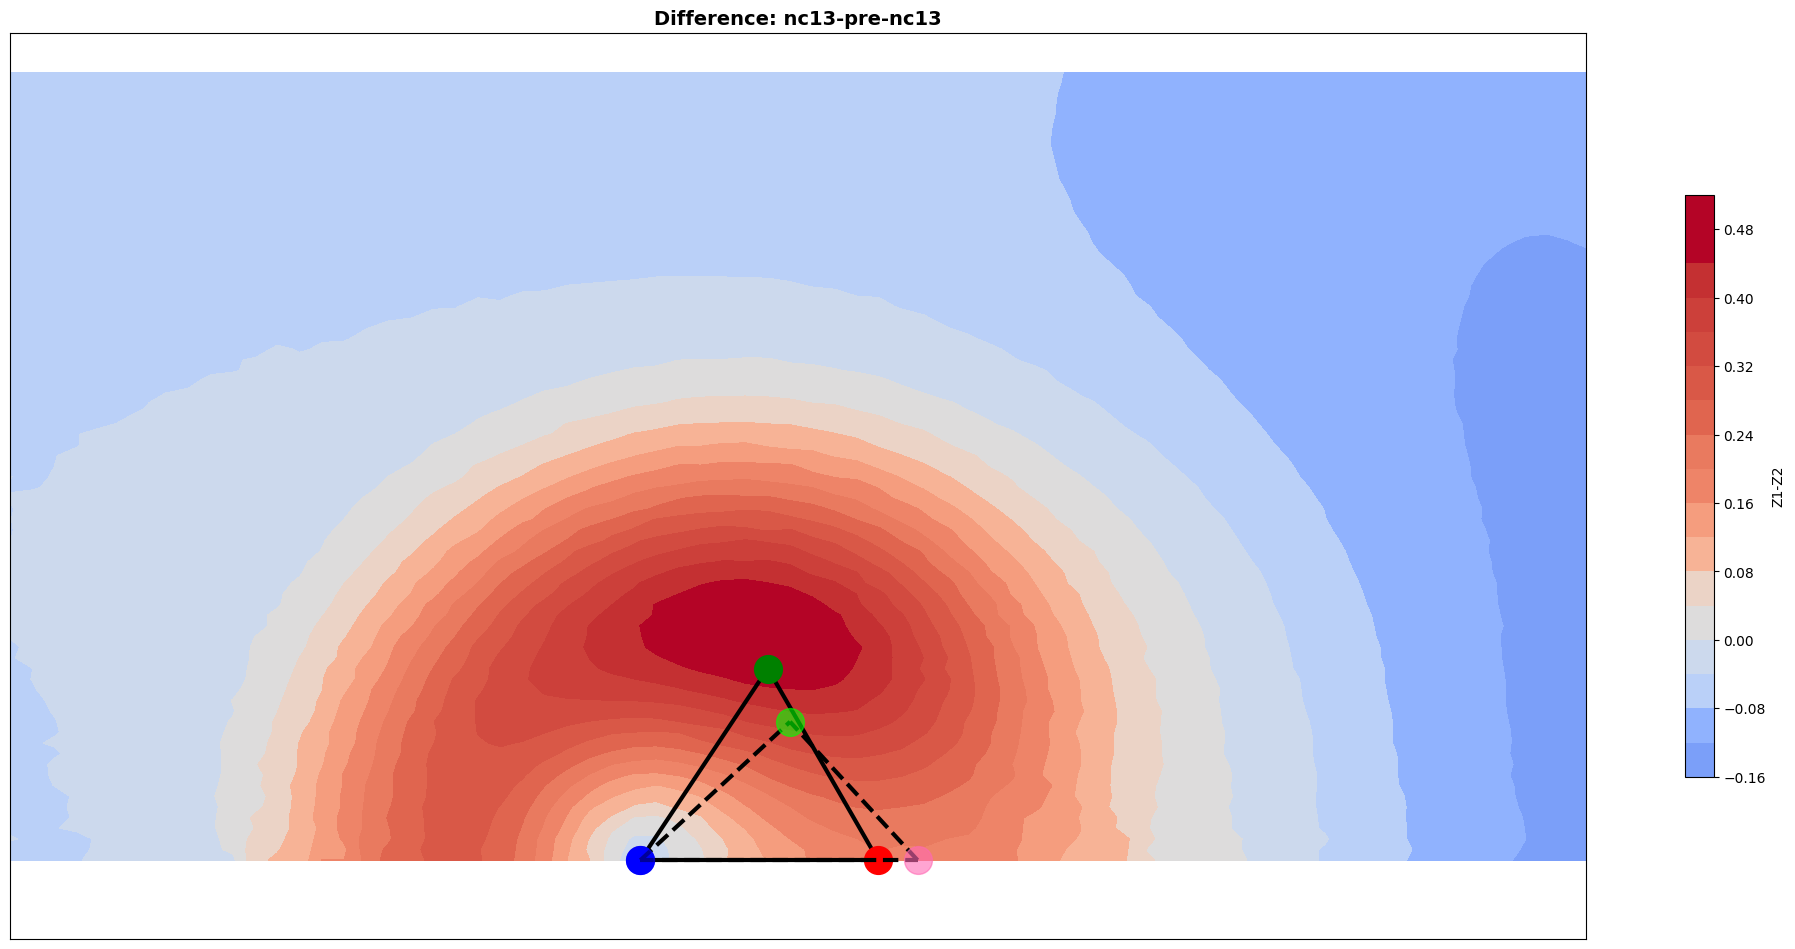

In [143]:
plot_difference_contour(Z_weighted_nc13_ppe, X_grid_nc13_ppe,Y_grid_nc13_ppe,
                        Z_weighted_pre_nc13_ppe, X_grid_pre_nc13_ppe,Y_grid_pre_nc13_ppe,
                        E1_ppe_nc13, E2_ppe_nc13, PPE_ppe_nc13,
                        E1_ppe_pre_nc13, E2_ppe_pre_nc13, PPE_ppe_pre_nc13,
                        title="Difference: nc13-pre-nc13")

## Contour difference WT nc13 vs PPE nc14 early: PPE nc14 early - WT nc13

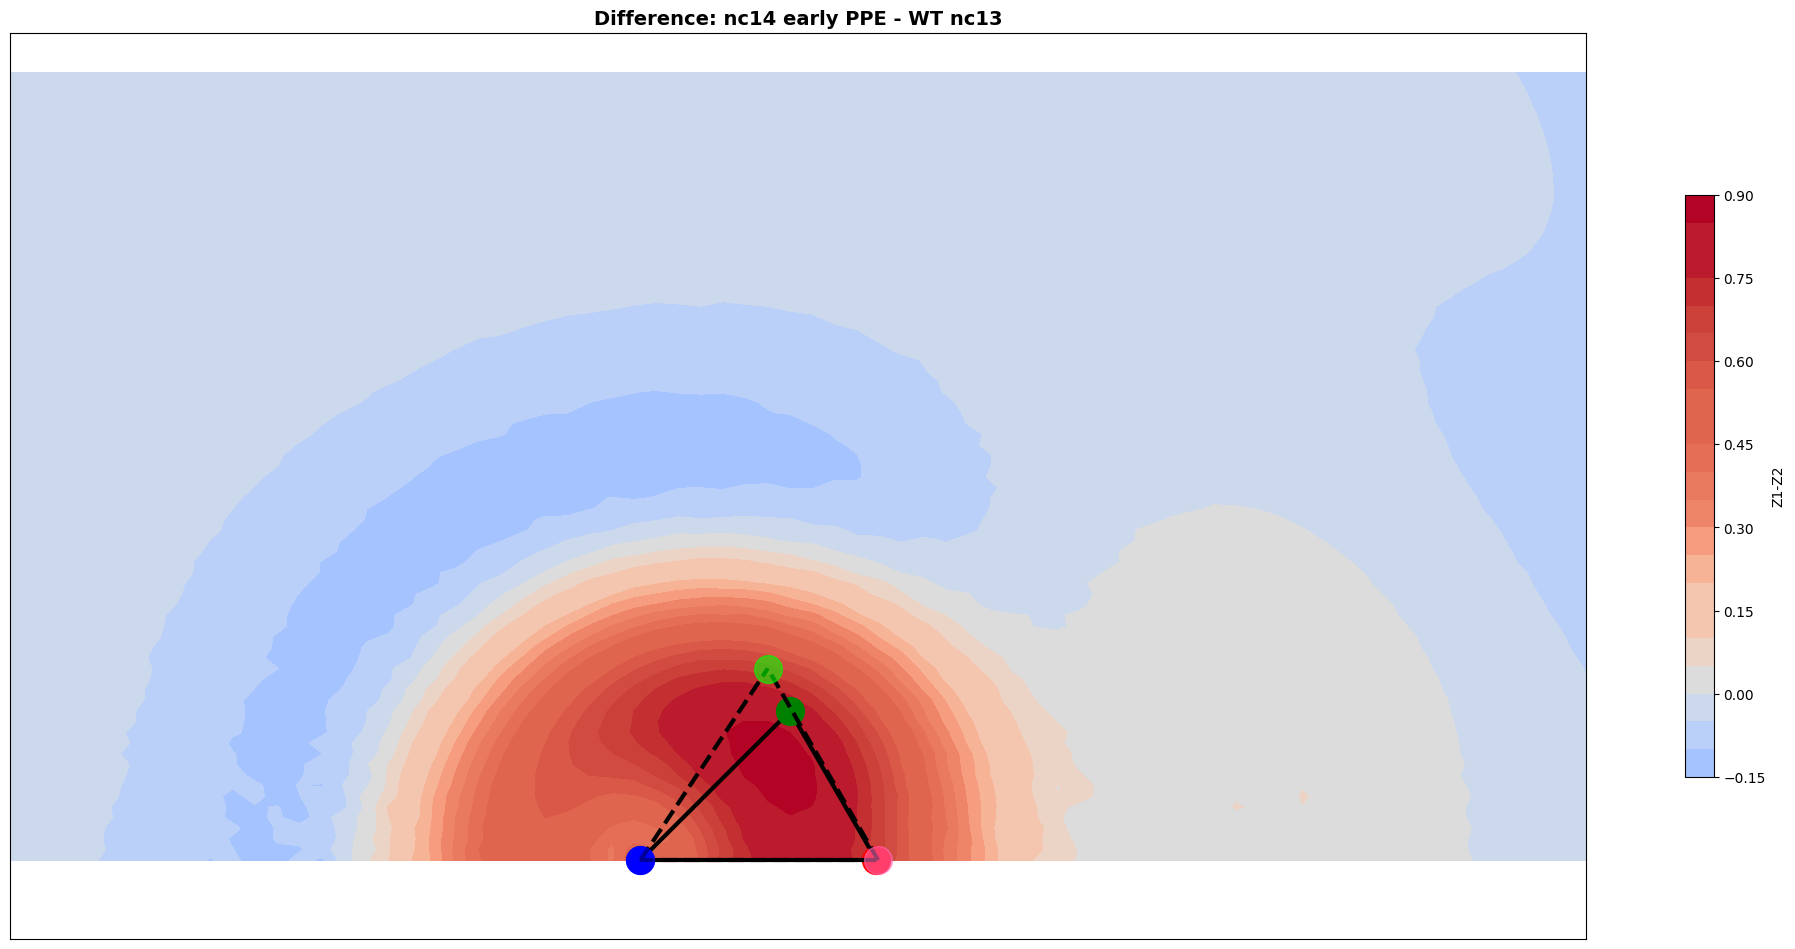

In [144]:
plot_difference_contour(Z_weighted_nc14_early_ppe, X_grid_nc14_early_ppe,Y_grid_nc14_early_ppe,
                        Z_weighted_nc13_ppe, X_grid_nc13_ppe,Y_grid_nc13_ppe,
                        E1_yw_nc14_early, E2_yw_nc14_early, PPE_yw_nc14_early,
                        E1_ppe_nc13, E2_ppe_nc13, PPE_ppe_nc13,
                        title="Difference: nc14 early PPE - WT nc13")

## Contour difference WT nc14 early vs PPE nc14 late: PPE nc14 late - WT nc14 early

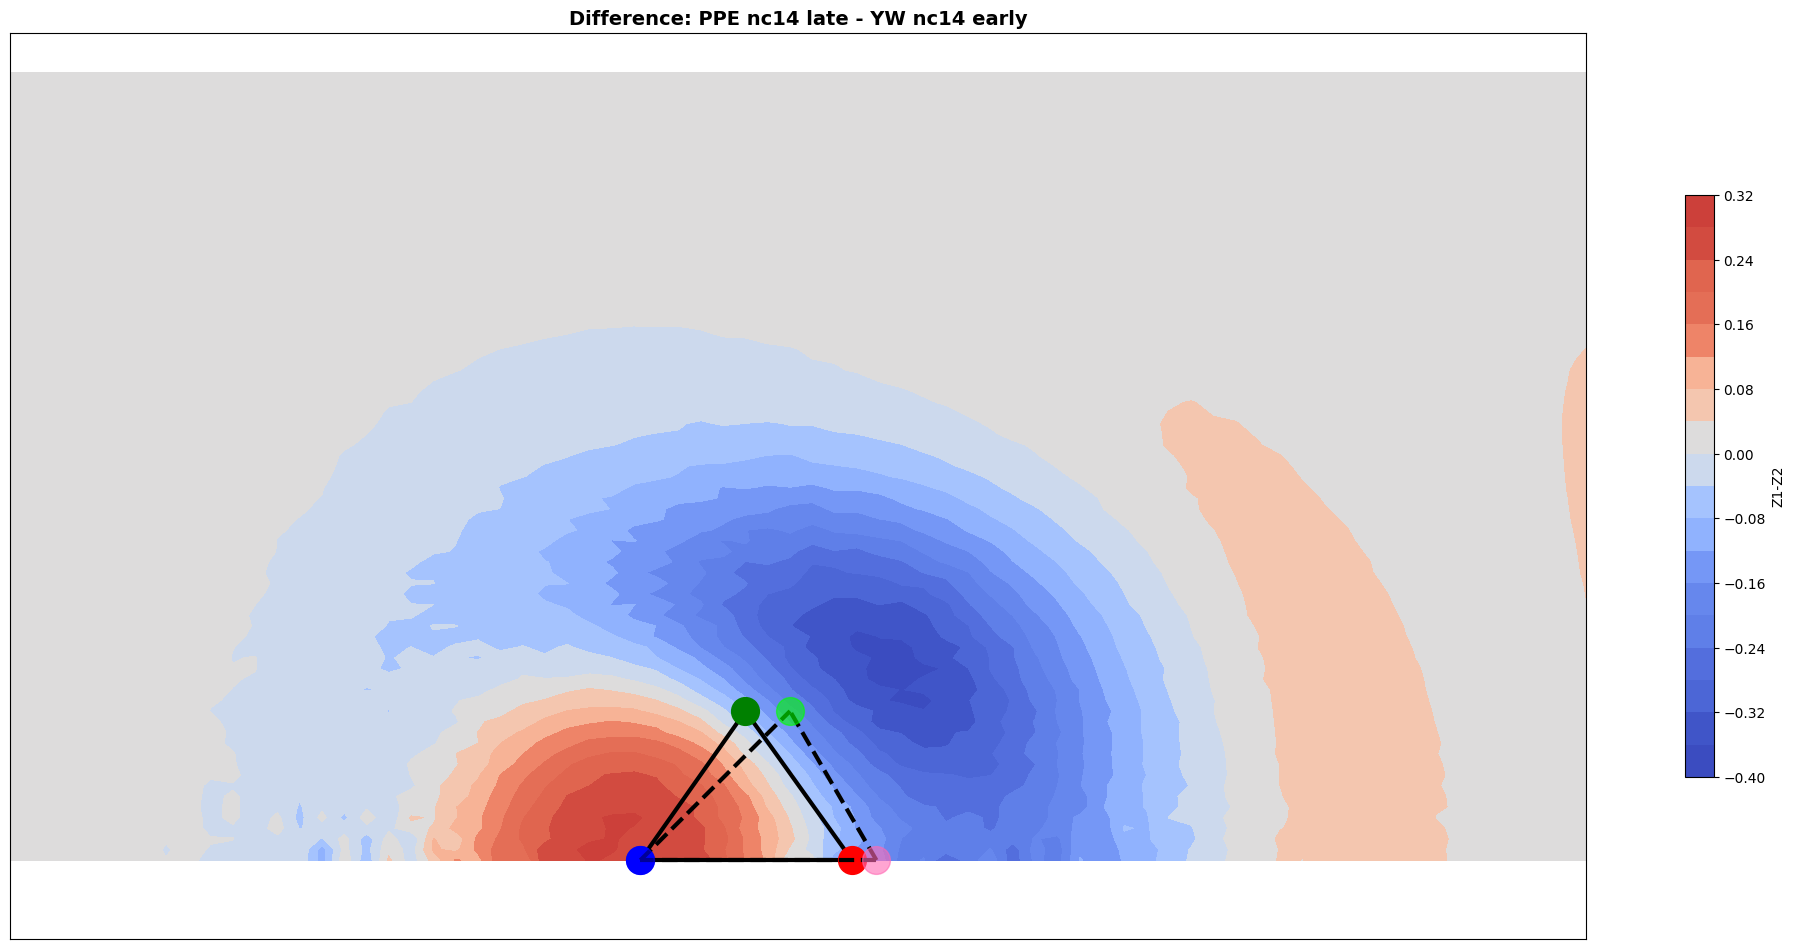

In [145]:
plot_difference_contour(Z_weighted_nc14_late_ppe, X_grid_nc14_late_ppe,Y_grid_nc14_late_ppe,
                        Z_weighted_nc14_early_yw, X_grid_nc14_early_yw,Y_grid_nc14_early_yw,
                        E1_ppe_nc14_late, E2_ppe_nc14_late, PPE_ppe_nc14_late,
                        E1_yw_nc14_early, E2_yw_nc14_early, PPE_yw_nc14_early,
                        title="Difference: PPE nc14 late - YW nc14 early")

## YW vs MIMIC

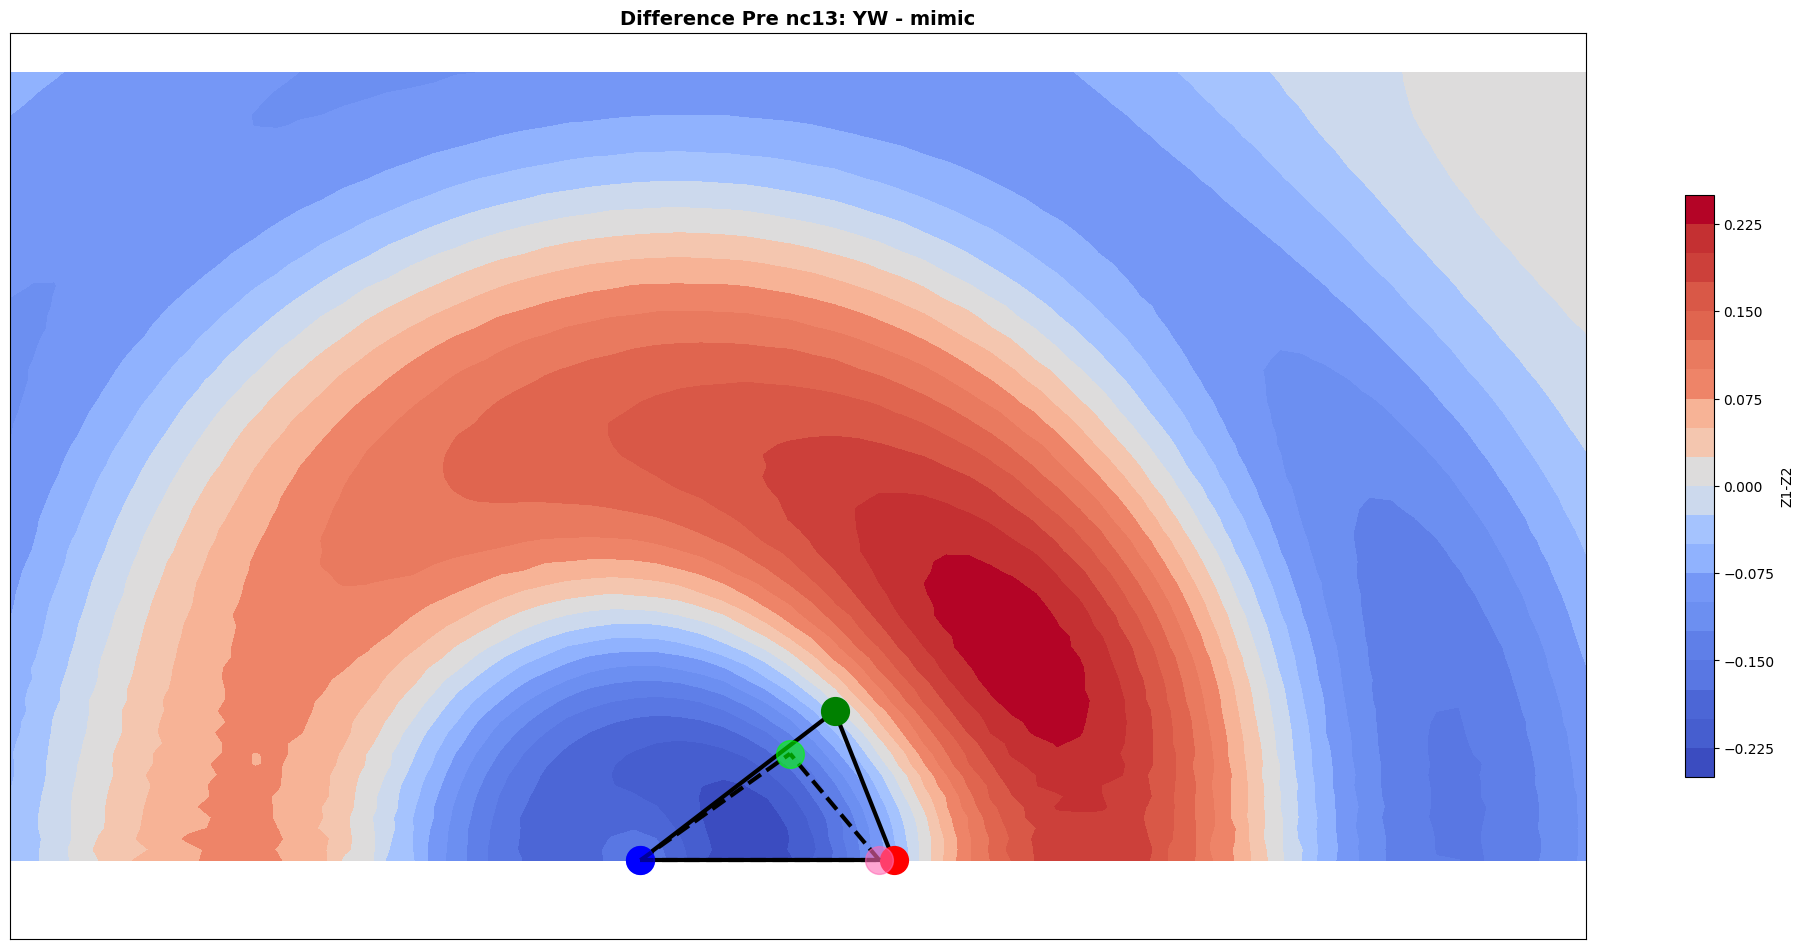

In [146]:
plot_difference_contour(Z_weighted_pre_nc13_yw, X_grid_pre_nc13_yw,Y_grid_pre_nc13_yw,
                        Z_weighted_pre_nc13_mimic, X_grid_pre_nc13_mimic,Y_grid_pre_nc13_mimic, 
                        E1_yw_pre_nc13, E2_yw_pre_nc13, PPE_yw_pre_nc13,
                        E1_mimic_pre_nc13, E2_mimic_pre_nc13, PPE_mimic_pre_nc13,
                        title="Difference Pre nc13: YW - mimic")

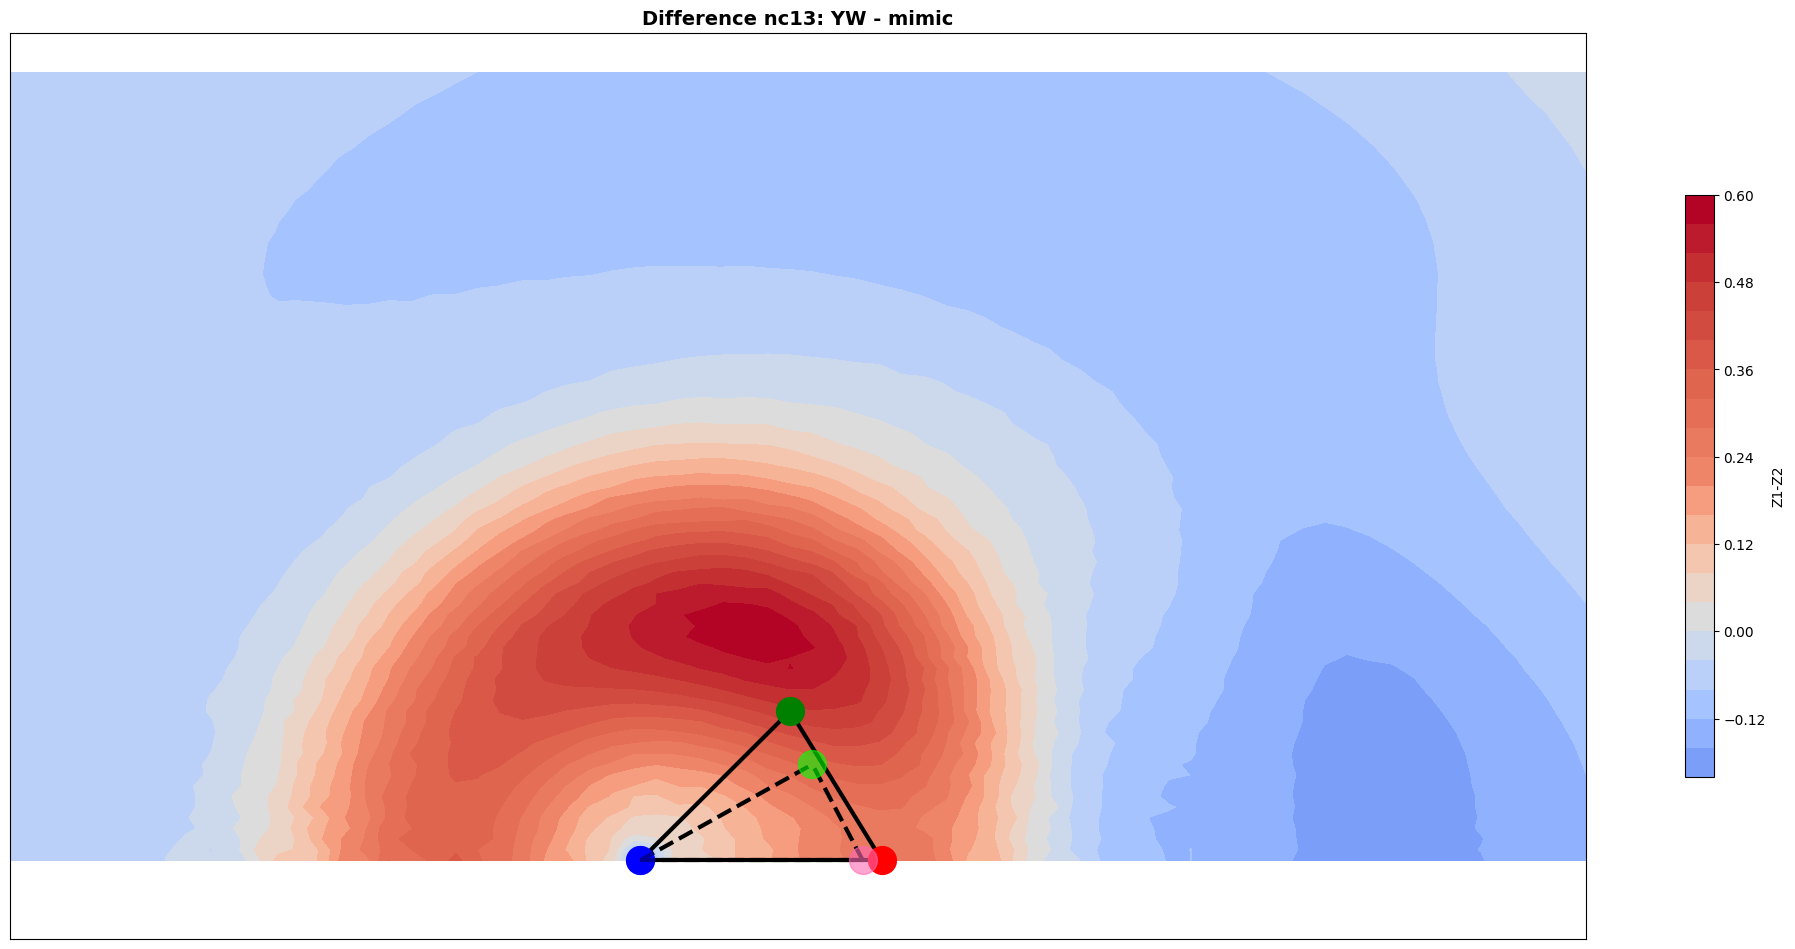

In [147]:
plot_difference_contour(Z_weighted_nc13_yw, X_grid_nc13_yw,Y_grid_nc13_yw,
                        Z_weighted_nc13_mimic, X_grid_nc13_mimic,Y_grid_nc13_mimic,
                        E1_yw_nc13, E2_yw_nc13, PPE_yw_nc13,
                        E1_mimic_nc13, E2_mimic_nc13, PPE_mimic_nc13,
                        title="Difference nc13: YW - mimic")

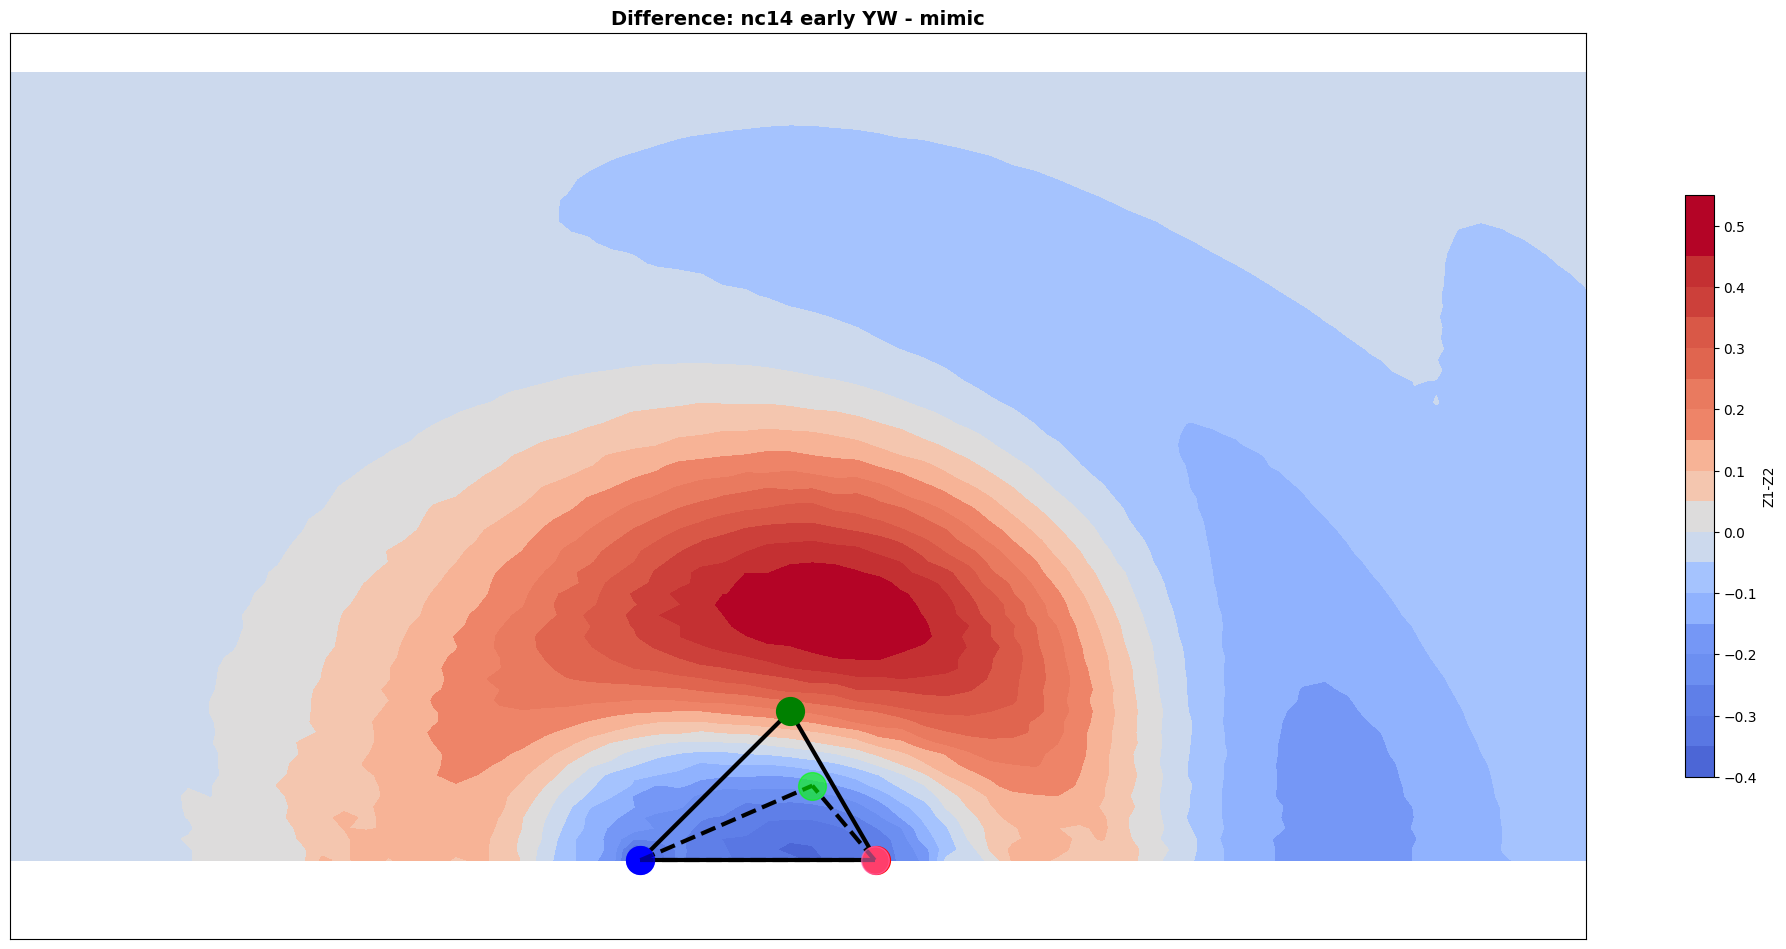

In [148]:
plot_difference_contour(Z_weighted_nc14_early_yw, X_grid_nc14_early_yw,Y_grid_nc14_early_yw,
                        Z_weighted_nc14_early_mimic, X_grid_nc14_early_mimic,Y_grid_nc14_early_mimic, 
                        E1_yw_nc14_early, E2_yw_nc14_early, PPE_yw_nc14_early,
                        E1_mimic_nc14_early, E2_mimic_nc14_early, PPE_mimic_nc14_early,
                        title="Difference: nc14 early YW - mimic")

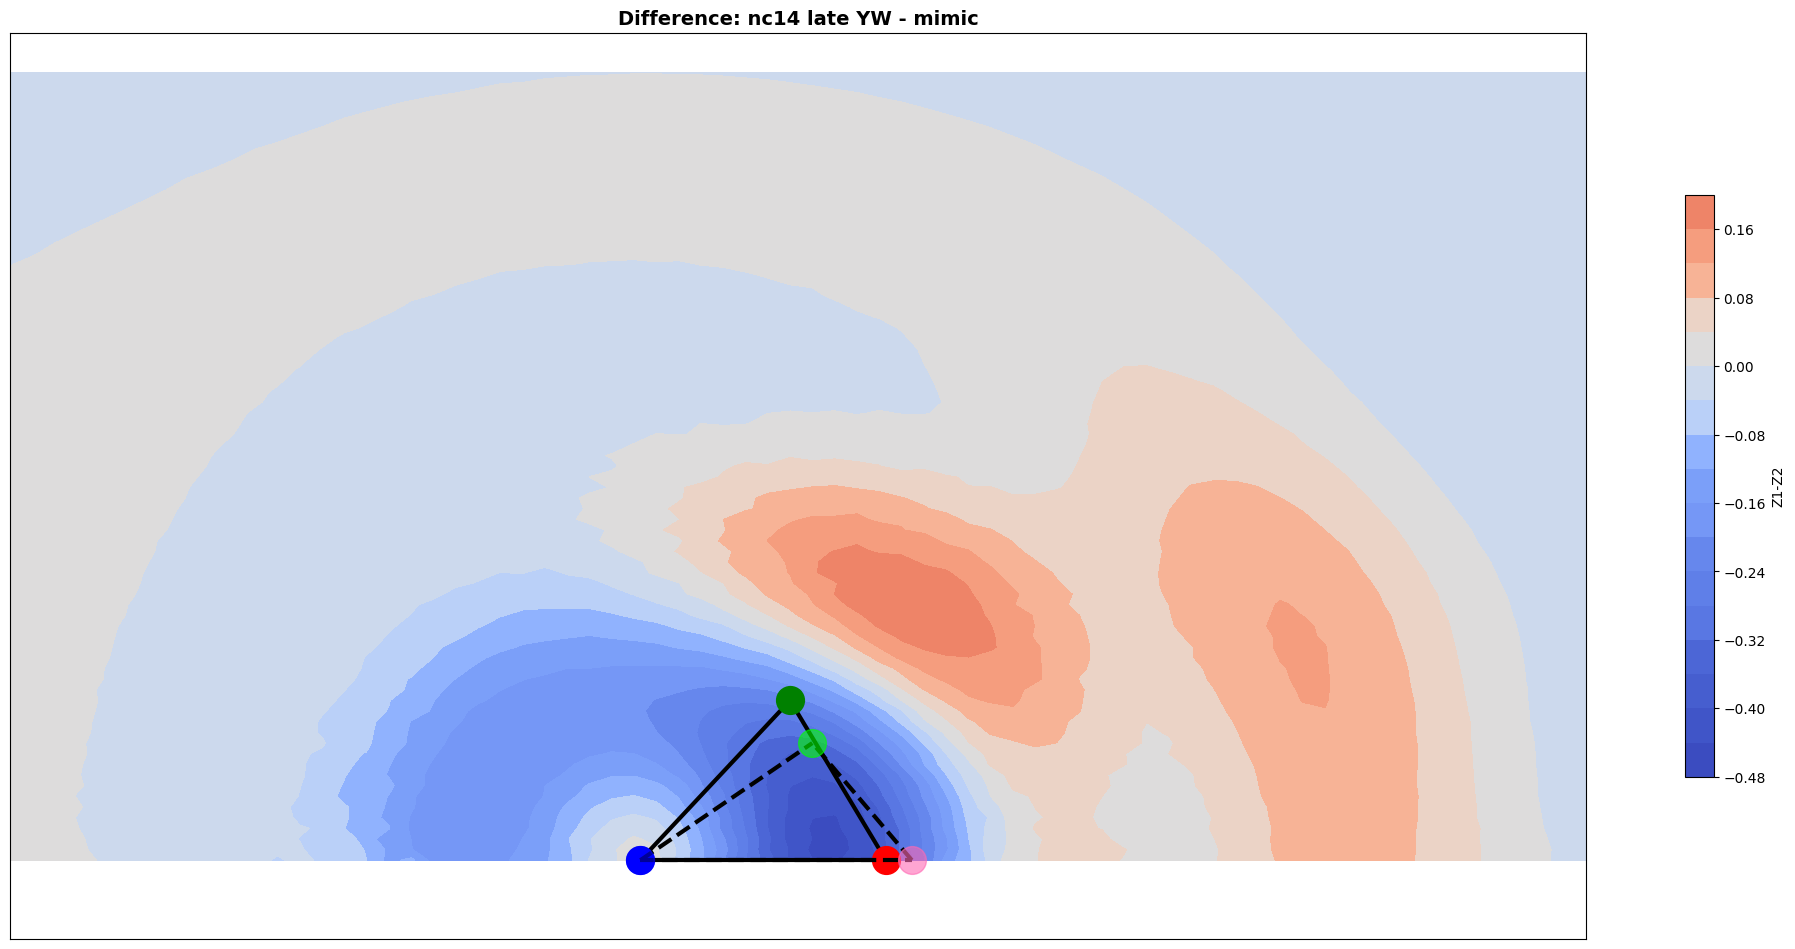

In [149]:
plot_difference_contour(Z_weighted_nc14_late_yw, X_grid_nc14_late_yw,Y_grid_nc14_late_yw,
                        Z_weighted_nc14_late_mimic, X_grid_nc14_late_mimic,Y_grid_nc14_late_mimic,
                        E1_yw_nc14_late, E2_yw_nc14_late, PPE_yw_nc14_late,
                        E1_mimic_nc14_late, E2_mimic_nc14_late, PPE_mimic_nc14_late,
                        title="Difference: nc14 late YW - mimic")

## PPE vs MIMIC nc14 late

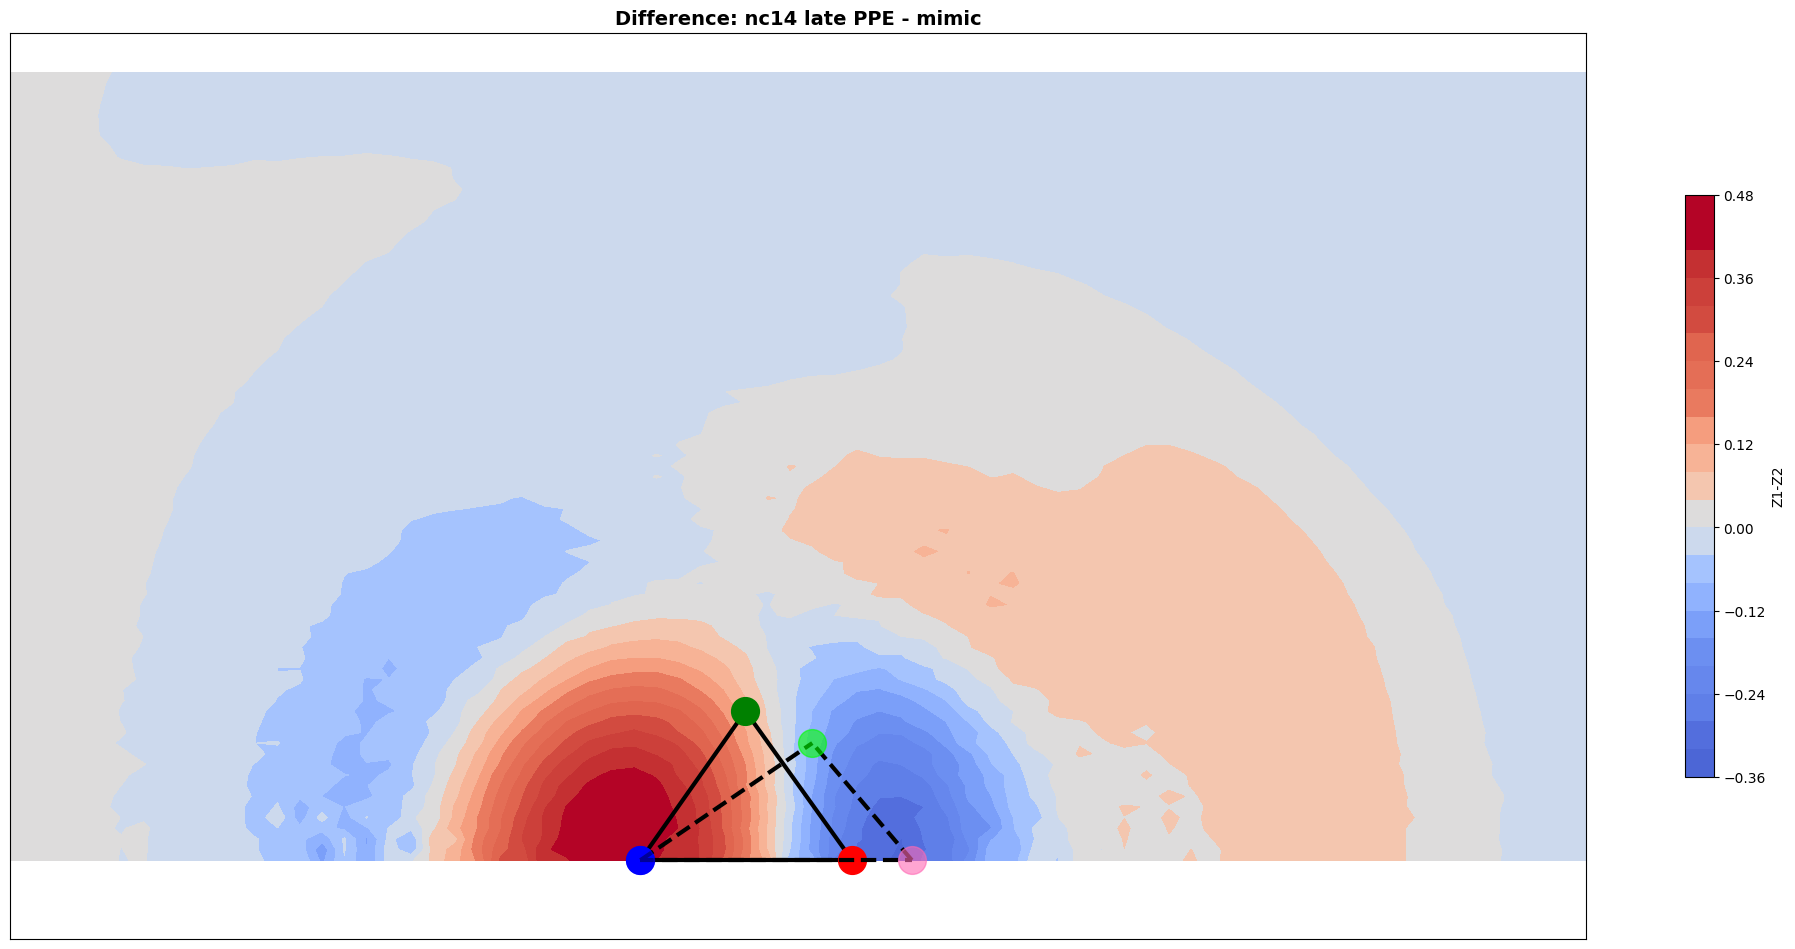

In [150]:
plot_difference_contour(Z_weighted_nc14_late_ppe, X_grid_nc14_late_ppe,Y_grid_nc14_late_ppe,
                        Z_weighted_nc14_late_mimic, X_grid_nc14_late_mimic,Y_grid_nc14_late_mimic,
                        E1_ppe_nc14_late, E2_ppe_nc14_late, PPE_ppe_nc14_late,
                        E1_mimic_nc14_late, E2_mimic_nc14_late, PPE_mimic_nc14_late,
                        title="Difference: nc14 late PPE - mimic")

## PPE vs MIMIC nc13

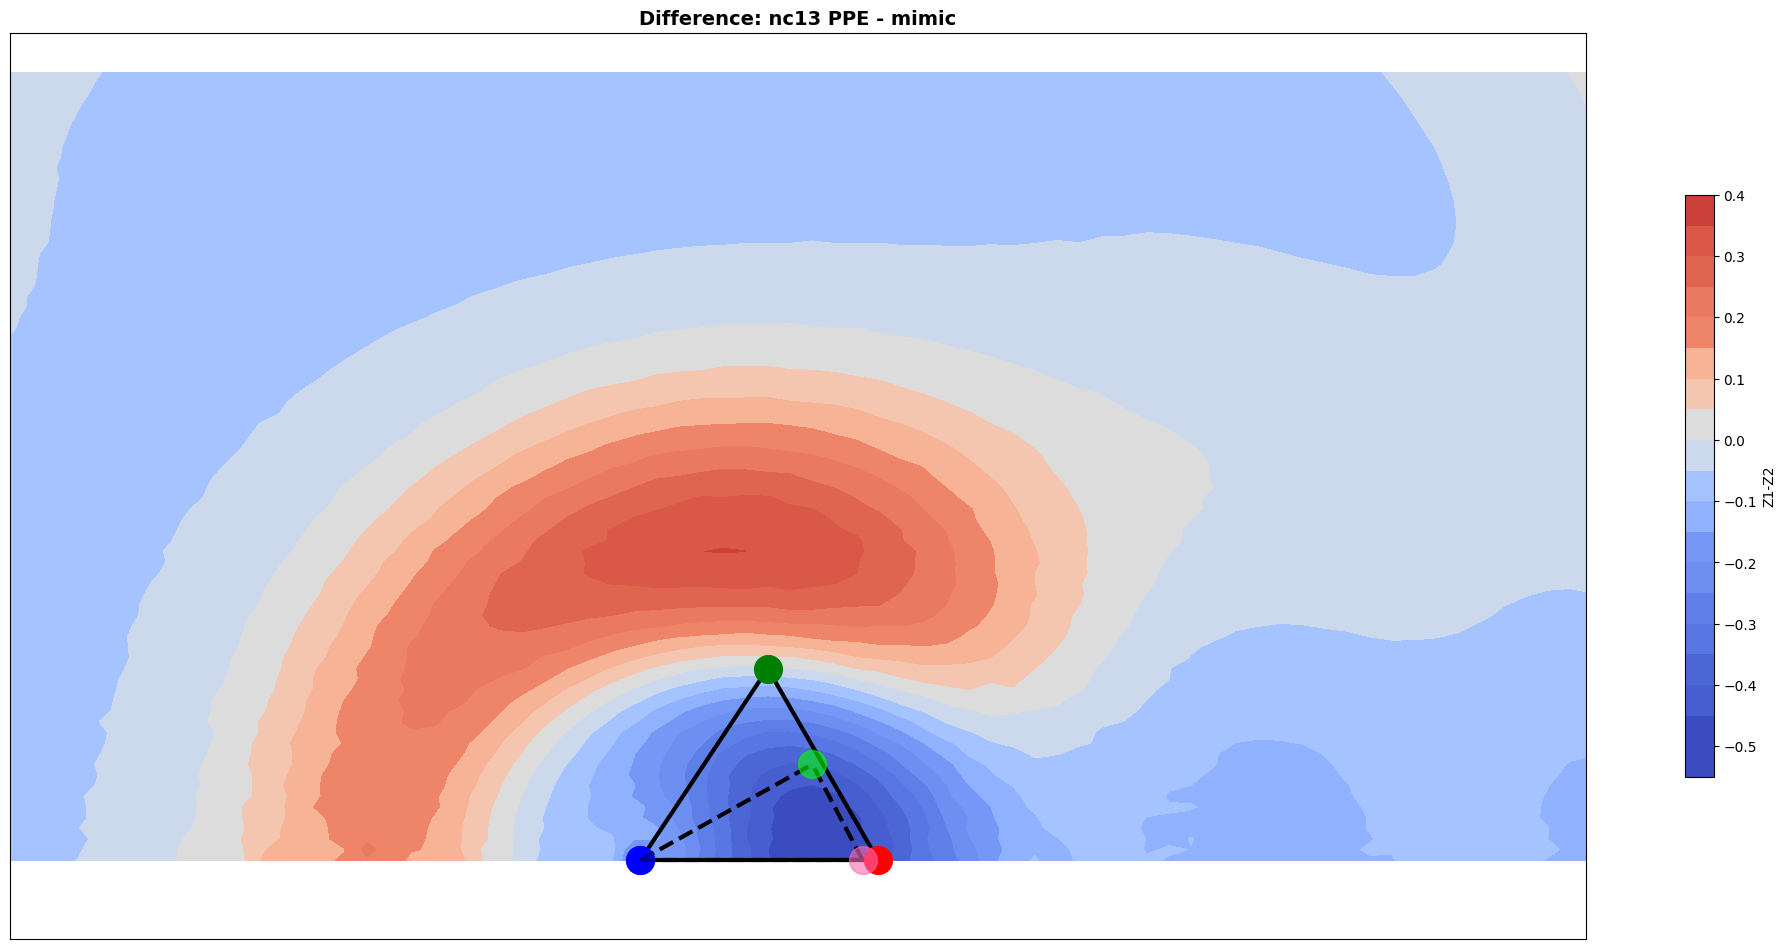

In [151]:
plot_difference_contour(Z_weighted_nc13_ppe, X_grid_nc13_ppe,Y_grid_nc13_ppe,
                        Z_weighted_nc13_mimic, X_grid_nc13_mimic,Y_grid_nc13_mimic,
                        E1_ppe_nc13, E2_ppe_nc13, PPE_ppe_nc13,
                        E1_mimic_nc13, E2_mimic_nc13, PPE_mimic_nc13,
                        title="Difference: nc13 PPE - mimic")

# 3D contours

In [152]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm  # For colormaps

# Define custom colormap
white_purple_hot_orange = LinearSegmentedColormap.from_list(
    "white_purple_hot_orange",
    [
        (0.0, "white"),
        (0.15, "#D8BFD8"),   # lighter purple sooner
        (0.25, "purple"),    # narrower purple
        (0.55, "#FFD580"),   # expand soft orange
        (0.8, "#FF8C00"),    # strong orange
        (1.0, "#FF4500")     # fire orange
    ]
)


def plot_3d_pdf_surface(X_grid, Y_grid, Z_weighted, title, vmin=None, vmax=None):
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create 3D surface
    surf = ax.plot_surface(
        X_grid, Y_grid, Z_weighted,
        cmap=white_purple_hot_orange,
        edgecolor='none',
        antialiased=True,
        linewidth=0,
        vmin=vmin, vmax=vmax
        
    )

    # Add color bar
    fig.colorbar(surf, shrink=0.5, aspect=10)

    # Labels and title
    ax.set_xlabel('X (relative E1–E2 axis)', fontsize=12, labelpad=10)
    ax.set_ylabel('Y (orthogonal to E1–E2)', fontsize=12, labelpad=10)
    ax.set_zlabel('Probability Density', fontsize=12, labelpad=10)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
   # --- Fixed axis limits for consistency ---
    ax.set_xlim(-1, 2.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_zlim(0.0, 2.5)

    # View angle (optional)
    ax.view_init(elev=30, azim=105)  # Change angles to adjust mountain view
    plt.tight_layout()
    plt.show()

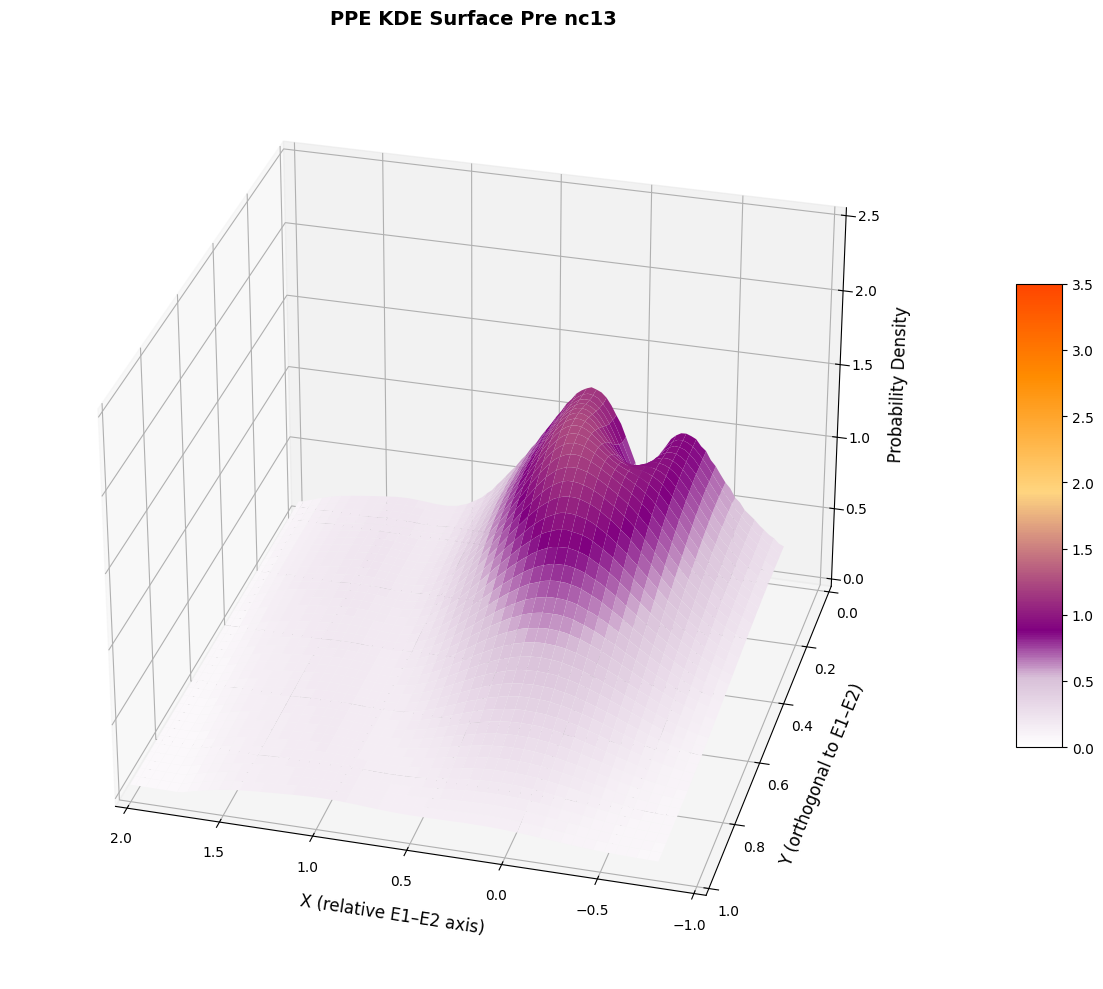

In [153]:
plot_3d_pdf_surface(X_grid_pre_nc13_yw, Y_grid_pre_nc13_yw, Z_weighted_pre_nc13_yw, title="PPE KDE Surface Pre nc13", vmin=0., vmax=3.5)

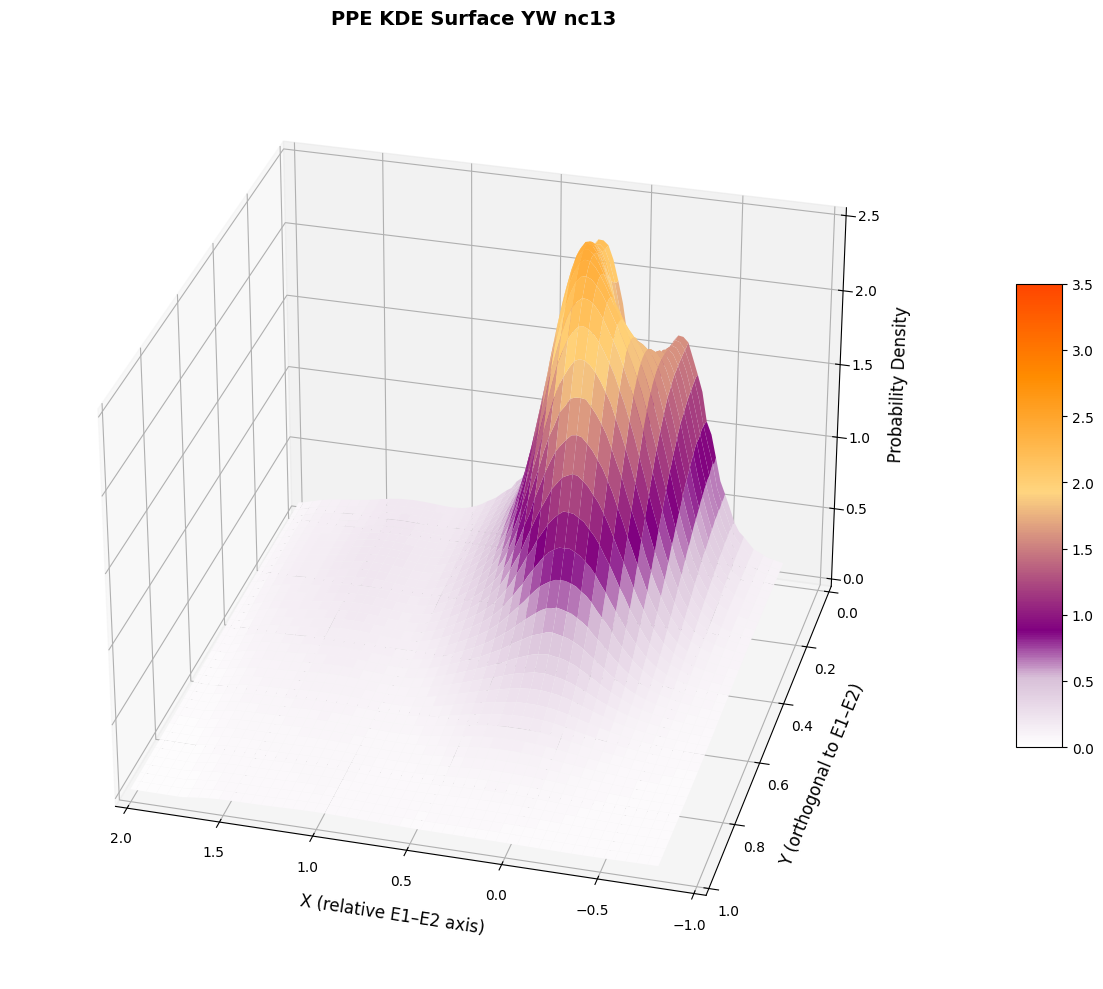

In [154]:
plot_3d_pdf_surface(X_grid_nc13_yw, Y_grid_nc13_yw, Z_weighted_nc13_yw, title="PPE KDE Surface YW nc13", vmin=0., vmax=3.5)

In [155]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm  # For colormaps

# Define custom colormap
white_purple_hot_orange = LinearSegmentedColormap.from_list(
    "white_purple_hot_orange",
    [
        (0.0, "white"),
        (0.15, "#D8BFD8"),   # lighter purple sooner
        (0.25, "purple"),    # narrower purple
        (0.55, "#FFD580"),   # expand soft orange
        (0.8, "#FF8C00"),    # strong orange
        (1.0, "#FF4500")     # fire orange
    ]
)


def plot_3d_pdf_surface(X_grid, Y_grid, Z_weighted, title, vmin=None, vmax=None):
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create 3D surface
    surf = ax.plot_surface(
        X_grid, Y_grid, Z_weighted,
        cmap=white_purple_hot_orange,
        edgecolor='none',
        antialiased=True,
        linewidth=0,
        vmin=vmin, vmax=vmax
        
    )

    # Add color bar
    fig.colorbar(surf, shrink=0.5, aspect=10)

    # Labels and title
    ax.set_xlabel('X (relative E1–E2 axis)', fontsize=12, labelpad=10)
    ax.set_ylabel('Y (orthogonal to E1–E2)', fontsize=12, labelpad=10)
    ax.set_zlabel('Probability Density', fontsize=12, labelpad=10)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
   # --- Fixed axis limits for consistency ---
    ax.set_xlim(-1, 2.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_zlim(0.0, 2.5)

    # View angle (optional)
    ax.view_init(elev=30, azim=285)  # Change angles to adjust mountain view
    plt.tight_layout()
    plt.show()

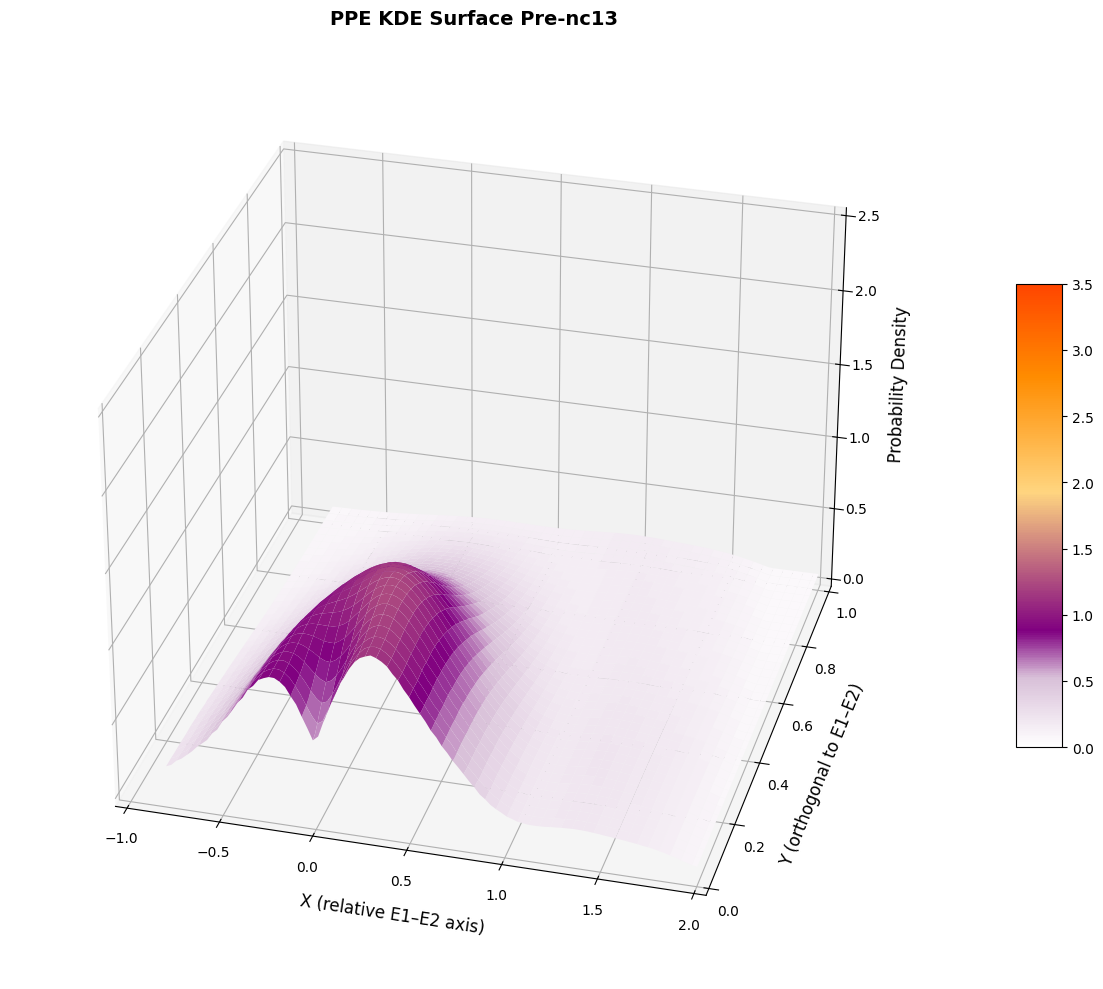

In [156]:
plot_3d_pdf_surface(X_grid_pre_nc13_yw, Y_grid_pre_nc13_yw, Z_weighted_pre_nc13_yw, title="PPE KDE Surface Pre-nc13", vmin=0., vmax=3.5)

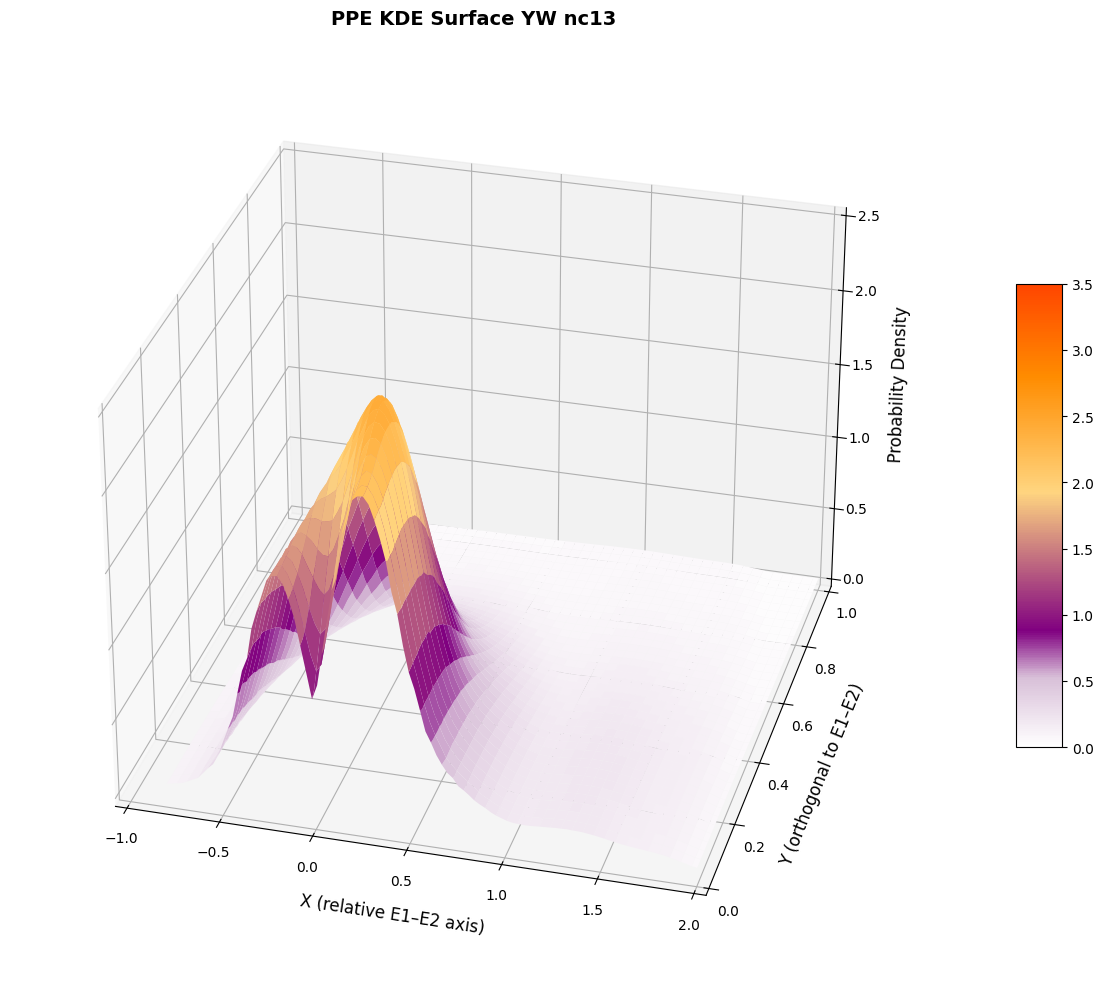

In [157]:
plot_3d_pdf_surface(X_grid_nc13_yw, Y_grid_nc13_yw, Z_weighted_nc13_yw, title="PPE KDE Surface YW nc13", vmin=0., vmax=3.5)